# Capstone Project
## Using Machine Learning in Trading Futures

Cell below is loading data obtained from [quandl.com](https://quandl.com). You can check how the resulting csv file was produced from raw trading data of futures contracts across multiple years. Workbook data-preparation.ipynb contains all the code.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

fee = 1.5

delta = 0.95
account_size = 10000
stop_loss = 550

trading_days_in_year = 252

start_date = datetime.date(year=2006, month=6, day=13)
end_date = datetime.date(year=2018, month=12, day=30)
validation_date = datetime.date(year=2018, month=1, day=1)

gold = pd.read_csv('data/gold_daily.csv', index_col='Date')
gold_cot = pd.read_csv('data/gold_cot.csv', index_col='Date')

corn = pd.read_csv('data/corn_daily.csv', index_col='Date')
corn_cot = pd.read_csv('data/corn_cot.csv', index_col='Date')

coffee = pd.read_csv('data/coffee_daily.csv', index_col='Date')
coffee_cot = pd.read_csv('data/coffee_cot.csv', index_col='Date')

dow = pd.read_csv('data/dow_daily.csv', index_col='Date')
nasdaq = pd.read_csv('data/nasdaq_daily.csv', index_col='Date')

Convert index to date type.

In [2]:
gold.index = pd.DatetimeIndex(data=gold.index)
gold_cot.index = pd.DatetimeIndex(data=gold_cot.index)

corn.index = pd.DatetimeIndex(data=corn.index)
corn_cot.index = pd.DatetimeIndex(data=corn_cot.index)

coffee.index = pd.DatetimeIndex(data=coffee.index)
coffee_cot.index = pd.DatetimeIndex(data=coffee_cot.index)

dow.index = pd.DatetimeIndex(data=dow.index)
nasdaq.index = pd.DatetimeIndex(data=nasdaq.index)

Ensure that dataframe is sorted by index (date).

In [3]:
gold = gold.sort_index(kind='mergesort')
gold_cot = gold_cot.sort_index(kind='mergesort')
corn = corn.sort_index(kind='mergesort')
corn_cot = corn_cot.sort_index(kind='mergesort')
coffee = coffee.sort_index(kind='mergesort')
coffee_cot = coffee_cot.sort_index(kind='mergesort')
dow = dow.sort_index(kind='mergesort')
nasdaq = nasdaq.sort_index(kind='mergesort')

Remove older dataframe - because we are missing COT.

In [4]:
gold = gold.loc[gold.index >= '2006-06-13']
corn = corn.loc[corn.index >= '2006-06-13']
coffee = coffee.loc[coffee.index >= '2006-06-13']

In [5]:
gold_cot.head(10)

,Open Interest,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,
2006-06-13,382474.0,42587.0,128892.0,19370.0,66611.0,22998.0,103211.0,30916.0,46704.0,33230.0,10656.0,58412.0,326513.0,365190.0,55961.0,17284.0
2006-06-20,390281.0,47440.0,126992.0,22404.0,64682.0,25806.0,94632.0,30963.0,48730.0,32947.0,11142.0,64458.0,336417.0,372774.0,53864.0,17507.0
2006-06-27,384321.0,48449.0,121890.0,22425.0,62640.0,25151.0,91042.0,32287.0,49614.0,31307.0,11386.0,59762.0,327749.0,362729.0,56572.0,21592.0
2006-07-03,392868.0,48087.0,122568.0,22720.0,69714.0,26352.0,92545.0,30452.0,50821.0,32874.0,8677.0,63514.0,336914.0,372098.0,55955.0,20771.0
2006-07-11,427008.0,54509.0,130618.0,21840.0,79217.0,28805.0,104213.0,27624.0,54922.0,33165.0,11194.0,70944.0,368398.0,403323.0,58611.0,23685.0
2006-07-18,443519.0,49863.0,131166.0,21681.0,83183.0,33352.0,107413.0,24296.0,62395.0,31760.0,9442.0,74272.0,380737.0,418105.0,62782.0,25414.0
2006-07-25,432413.0,52859.0,133290.0,22956.0,85604.0,28832.0,99087.0,22386.0,64810.0,29740.0,6244.0,73980.0,372265.0,415146.0,60148.0,17266.0
2006-08-01,394609.0,45161.0,135988.0,21250.0,73244.0,23643.0,99330.0,24391.0,54618.0,32195.0,4758.0,57618.0,333815.0,374260.0,60795.0,20350.0
2006-08-08,402899.0,46203.0,142240.0,20703.0,72061.0,24259.0,104600.0,24271.0,57785.0,33123.0,6489.0,57914.0,344587.0,385020.0,58312.0,17880.0


### COT Feature engineering
Determine how far we are from top across last 2 years (730 days).

In [6]:
def percentage_from_max(sr):
    mx = sr.max()
    mn = sr.min()
    return (sr[-1]-mn)/(mx-mn)

def max_positions_percentage(df):
    df['Prod_net_position'] = df['Producer/Merchant/Processor/User Longs'] - df['Producer/Merchant/Processor/User Shorts']
    df['Prod_net_position_perc'] = df.rolling('730d')['Prod_net_position'].apply(percentage_from_max, raw=False)
    df['Money_manager_net_position'] = df['Money Manager Longs'] - df['Money Manager Shorts']
    df['Money_manager_net_position_perc'] = df.rolling('730d')['Money_manager_net_position'].apply(percentage_from_max, raw=False)
    df = df[['Prod_net_position_perc', 'Money_manager_net_position_perc']]
    return df

In [7]:
gold_cot = max_positions_percentage(gold_cot)
corn_cot = max_positions_percentage(corn_cot)
coffee_cot = max_positions_percentage(coffee_cot)

### Williams %R
Create feature with Williams %R indicator

In the end I decided not to use any indicator.

In [8]:
# code from stockstats pypy package
def get_wr(df, n_days):
    """ Williams Overbought/Oversold Index
    WMS=[(Hn—Ct)/(Hn—Ln)] ×100
    Ct - the close price
    Hn - N days high
    Ln - N days low
    :param df: data
    :param n_days: N days
    :return: None
    """
    n_days = int(n_days)
    ln = df['Low'].rolling(min_periods=1, window=n_days,
                           center=False).min()
    hn = df['High'].rolling(min_periods=1, window=n_days,
                            center=False).max()
    column_name = 'wr_{}'.format(n_days)
    column_name = 'wr'
    df[column_name] = (hn - df['Settle']) / (hn - ln) * 100

### Create Targets
Based on the threshold, fee and delta calculate targets used for supervised learning.

In [9]:
def calculate_target(row, threshold):
    global fee, delta, stop_loss
    volatility = (row['Settle']-row['Open'])*delta
    if abs(volatility) > fee + threshold:
        if volatility > 0:
            return 1
        else:
            return -1
    else:
        return 0
    return df


def create_trade_outcomes(df, contracts, threshold):
    ans_df = pd.DataFrame([])
    ans_df['gains'] = (df['Settle'] - df['Open'])*0.95*contracts
    ans_df = pd.concat([ans_df, df[['Open', 'High', 'Low', 'Settle']]*contracts], axis=1)
    ans_df['target'] = ans_df.apply(lambda x: calculate_target(x, threshold), axis=1)
    print(ans_df.head(5))
    return ans_df.shift(-1)

In [10]:
threshold = 500
contracts = 100
gold_gains = create_trade_outcomes(gold, contracts, threshold)
gold_gains_train = gold_gains.loc[gold_gains.index < '2018-1-1']
# gold_gains.head(20)

             gains     Open     High      Low   Settle  target
Date                                                          
2006-06-13 -2251.5  59050.0  59500.0  56550.0  56680.0      -1
2006-06-14  -332.5  57000.0  57550.0  56540.0  56650.0       0
2006-06-15  -304.0  57350.0  57950.0  56950.0  57030.0       0
2006-06-16    47.5  58120.0  58250.0  57050.0  58170.0       0
2006-06-19   -38.0  57280.0  57840.0  57100.0  57240.0       0


In [11]:
# get_wr(gold, 14)
gold = pd.concat([gold, gold_gains[['target']]], axis=1)
gold.head(15)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,target
Date,,,,,,,
2006-06-13,590.5,595.0,565.5,566.8,93899.0,192616.0,0.0
2006-06-14,570.0,575.5,565.4,566.5,68729.0,192917.0,0.0
2006-06-15,573.5,579.5,569.5,570.3,52628.0,193887.0,0.0
2006-06-16,581.2,582.5,570.5,581.7,43947.0,189585.0,0.0
2006-06-19,572.8,578.4,571.0,572.4,27362.0,189168.0,1.0
2006-06-20,572.0,581.0,567.8,580.5,39962.0,187696.0,1.0
2006-06-21,577.0,591.5,573.5,591.0,43918.0,187072.0,0.0
2006-06-22,588.0,593.5,584.5,585.4,42916.0,187027.0,1.0
2006-06-23,574.5,589.0,574.5,588.0,33705.0,181290.0,0.0


### Trade gains investigation

Ivestigate trade gains
- have a look at all gains (regardless of label)
- analyze gains for long trades (label 1)
- analyze gains for short trades (label -1)

### Trade labels distribution

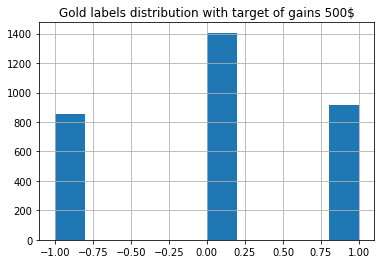

In [12]:
from matplotlib.pyplot import savefig

ax = gold['target'].hist()
ax.set_title('Gold labels distribution with target of gains 500$')
savefig('figures/gold_target_distribution.eps')

In [13]:
gold_gains_train.gains.describe()

count     2921.000000
mean        -6.878637
std       1225.716089
min     -11390.500000
25%       -560.500000
50%         28.500000
75%        627.000000
max       6555.000000
Name: gains, dtype: float64

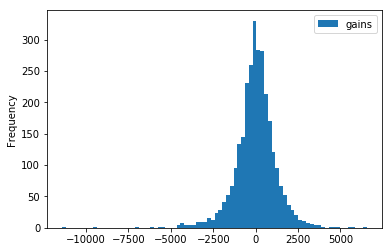

In [14]:
gold_gains_train[['gains']].plot.hist(bins=80)

In [15]:
def stop_loss_gen(df):
    df['Open_High'] = df['High'] - df['Open']
    df['Open_Low'] = df['Open'] - df['Low']
    return df

In [16]:
gold_gains_train = stop_loss_gen(gold_gains_train)

/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
def plot_histogram_cumsum(df, column):
    df[column].hist(bins=50, density=True, cumulative=-1, figsize=(10,5))
    df[column].hist(bins=50, density=True, linewidth=1.5, cumulative=True, histtype='step', figsize=(10,5))
    ax = plt.plot([0, df[column].max()], [0.9, 0.9], lw=1, color='r')
    return ax

### Investigate suitable stop-loss value

Below are cumulative curves.
Red line denotes 90% mark. What stop-loss should you use when you want 90% of trades to get completed (trade from open  to close)?

Following curves are investigating stop losses based on the label.

| trade | commodity | stop loss |
|-------|-----------|-----------|
| long  |      gold |      1000 |
| short |      gold |       800 |
| long  |      corn |       300 |
| short |      corn |       300 |
| long  |    coffee |       800 |
| short |    coffee |       800 |



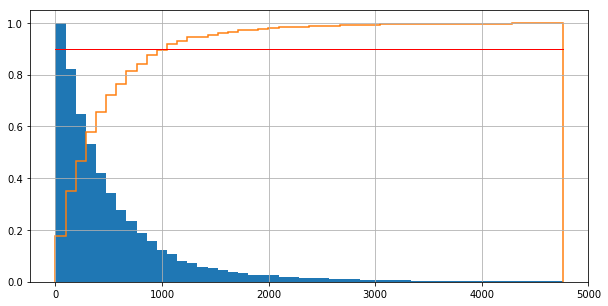

In [18]:
ax = plot_histogram_cumsum(gold_gains_train[gold_gains_train.target == 1], 'Open_Low')
# print(type(ax[0]))
# print(type(ax))
# ax.set_title('Gold stop loss long trades')
savefig('figures/gold_stop_loss_long_trades.eps')

In [19]:
gold_gains_train[gold_gains_train.target == 1].Open_Low.describe()

count     860.000000
mean      472.825581
std       538.691375
min         0.000000
25%       130.000000
50%       310.000000
75%       640.000000
max      4760.000000
Name: Open_Low, dtype: float64

In [20]:
gold_gains_train[gold_gains_train.target == -1].Open_High.describe()

count     802.000000
mean      429.077307
std       439.462157
min         0.000000
25%       150.000000
50%       310.000000
75%       570.000000
max      4380.000000
Name: Open_High, dtype: float64

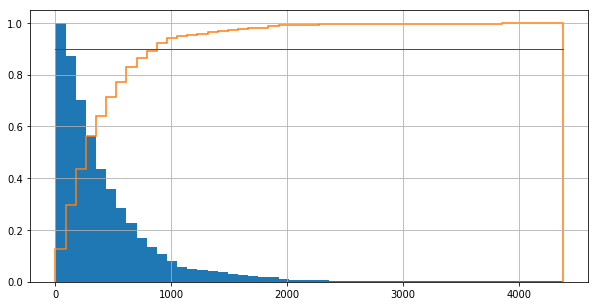

In [21]:
plot_histogram_cumsum(gold_gains_train[gold_gains_train.target == -1], 'Open_High')
savefig('figures/gold_stop_loss_short_trades.eps')

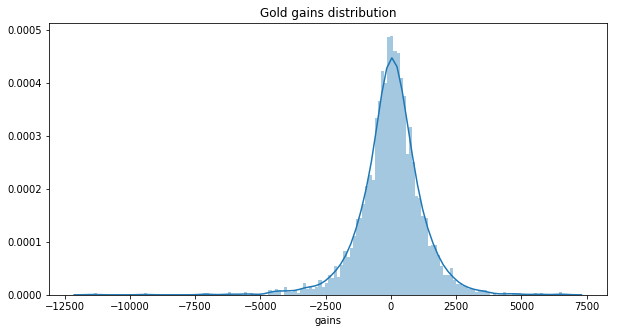

In [22]:
sr = gold_gains_train.gains
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(sr, bins=150, ax=ax)
ax.set_title('Gold gains distribution')
savefig('figures/gold_gains_distribution.eps')

In [23]:
# Corn Contract has 5000 bushels contract is in cents therefore 50 contracts are producing desired values
contracts = 50
threshold = 150
corn_gains = create_trade_outcomes(corn, contracts, threshold)
corn_gains_train = corn_gains.loc[corn_gains.index < '2018-1-1']

              gains     Open     High      Low   Settle  target
Date                                                           
2006-06-13 -213.750  12387.5  12400.0  12112.5  12162.5      -1
2006-06-14 -332.500  12200.0  12262.5  11837.5  11850.0      -1
2006-06-15 -213.750  11875.0  11937.5  11600.0  11650.0      -1
2006-06-16   71.250  12987.5  13137.5  12962.5  13062.5       0
2006-06-19 -154.375  12950.0  13050.0  12750.0  12787.5      -1


In [24]:
corn_gains_train.gains.describe()

count    2917.000000
mean        6.122729
std       411.069273
min     -1983.125000
25%      -190.000000
50%        11.875000
75%       213.750000
max      1888.125000
Name: gains, dtype: float64

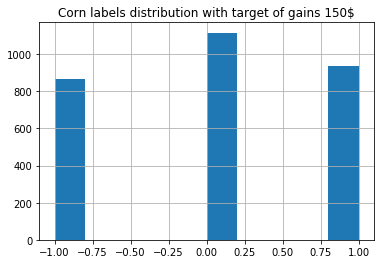

In [25]:
# get_wr(corn, 14)
corn = pd.concat([corn, corn_gains[['target']]], axis=1)

ax = corn.loc[corn.index < '2018-1-1'].target.hist()
ax.set_title('Corn labels distribution with target of gains 150$')
savefig('figures/corn_target_distribution.eps')

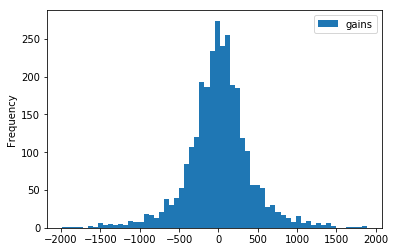

In [26]:
ax = corn_gains_train[['gains']].plot.hist(bins=60)

In [27]:
corn_gains_train.head(10)

,gains,Open,High,Low,Settle,target
Date,,,,,,
2006-06-13,-332.500,12200.0,12262.5,11837.5,11850.0,-1.0
2006-06-14,-213.750,11875.0,11937.5,11600.0,11650.0,-1.0
2006-06-15,71.250,12987.5,13137.5,12962.5,13062.5,0.0
2006-06-16,-154.375,12950.0,13050.0,12750.0,12787.5,-1.0
2006-06-19,-23.750,12825.0,12837.5,12675.0,12800.0,0.0
2006-06-20,142.500,12800.0,12975.0,12775.0,12950.0,0.0
2006-06-21,-95.000,12950.0,13025.0,12800.0,12850.0,0.0
2006-06-22,-83.125,12850.0,12887.5,12737.5,12762.5,0.0
2006-06-23,-225.625,12687.5,12687.5,12387.5,12450.0,-1.0


In [28]:
corn_gains = stop_loss_gen(corn_gains)
corn_gains_train = corn_gains[corn_gains.index < '2018-1-1']

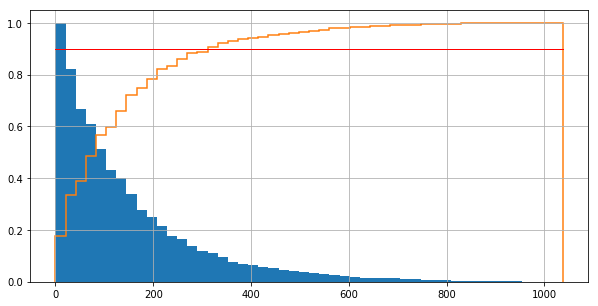

In [29]:
plot_histogram_cumsum(corn_gains_train[corn_gains_train.target == 1], 'Open_Low')
savefig('figures/corn_stop_loss_long_trades.eps')

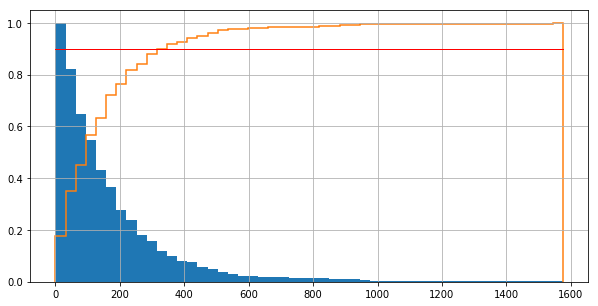

In [30]:
plot_histogram_cumsum(corn_gains_train[corn_gains_train.target == -1], 'Open_High')
savefig('figures/corn_stop_loss_short_trades.eps')

/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


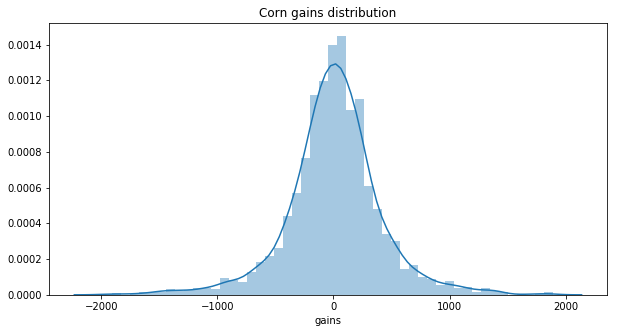

In [31]:
sr = corn_gains_train.gains
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(sr, ax=ax)
ax.set_title('Corn gains distribution')
savefig('figures/corn_gains_distribution.eps')

/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


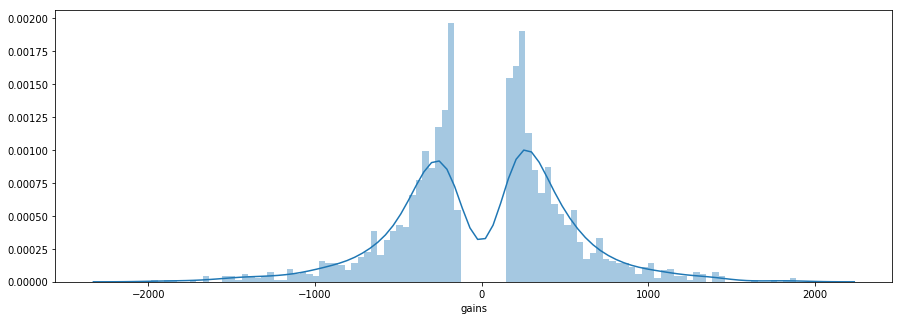

In [32]:
sr = corn_gains_train[corn_gains.gains.abs() > 150].gains
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sr, bins=100, ax=ax)

In [33]:
# coffee contract size is 37,500 pounds price is in cents per pound
contracts = 375
threshold = 275
coffee_gains = create_trade_outcomes(coffee, contracts, threshold)
coffee_gains = stop_loss_gen(coffee_gains)
coffee_gains_train = coffee_gains.loc[coffee_gains.index < '2018-1-1']

            gains      Open     High      Low    Settle  target
Date                                                           
2006-06-13    0.0  36731.25  37050.0  36712.5  36731.25       0
2006-06-14    0.0  36918.75  37275.0  36600.0  36918.75       0
2006-06-15    0.0  37106.25  37425.0  36937.5  37106.25       0
2006-06-16    0.0  36637.50  37350.0  36337.5  36637.50       0
2006-06-19    0.0  36468.75  36712.5  36375.0  36468.75       0


In [34]:
coffee_gains_train.gains.describe()

count    2908.000000
mean      -11.546273
std      1070.462227
min     -5236.875000
25%      -516.562500
50%         0.000000
75%       498.750000
max      6341.250000
Name: gains, dtype: float64

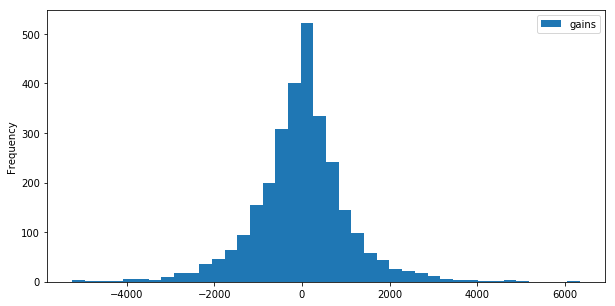

In [35]:
coffee_gains_train[['gains']].plot.hist(bins=40, figsize=(10, 5))

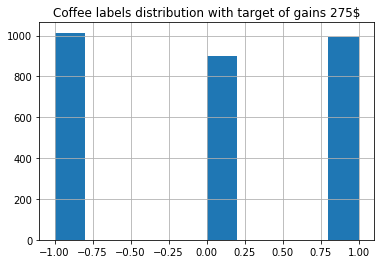

In [36]:
# get_wr(coffee, 14)
coffee = pd.concat([coffee, coffee_gains[['target']]], axis=1)
ax = coffee.loc[coffee.index < '2018-1-1'].target.hist()
ax.set_title('Coffee labels distribution with target of gains 275$')
savefig('figures/coffee_target_distribution.eps')

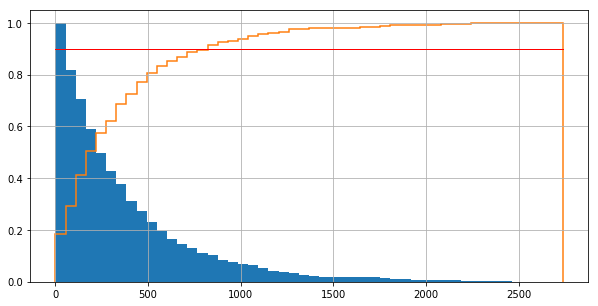

In [37]:
plot_histogram_cumsum(coffee_gains_train[coffee_gains_train.target == 1], 'Open_Low')
savefig('figures/coffee_stop_loss_long_trades.eps')

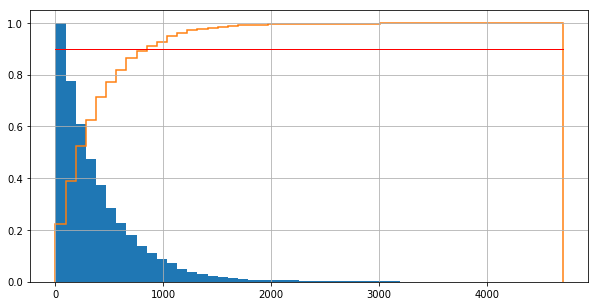

In [38]:
plot_histogram_cumsum(coffee_gains_train[coffee_gains_train.target == -1], 'Open_High')
savefig('figures/coffee_stop_loss_short_trades.eps')

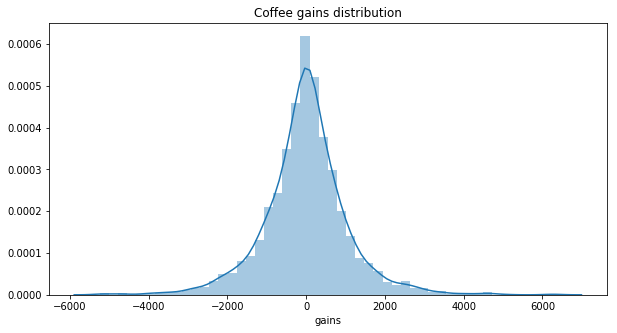

In [39]:
sr = coffee_gains_train.gains
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(sr, ax=ax)
ax.set_title('Coffee gains distribution')
savefig('figures/coffee_gains_distribution.eps')

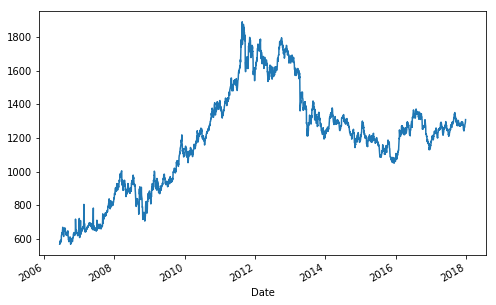

In [40]:
ax = gold.loc[gold.index < '2018-01-01']['Settle'].plot(figsize=(8, 5))
savefig('figures/gold.eps')

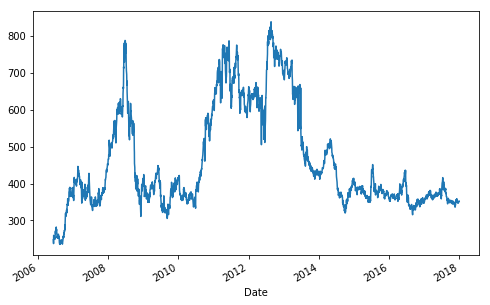

In [41]:
corn.loc[corn.index < '2018-01-01']['Open'].plot(figsize=(8, 5))
savefig('figures/corn.eps')

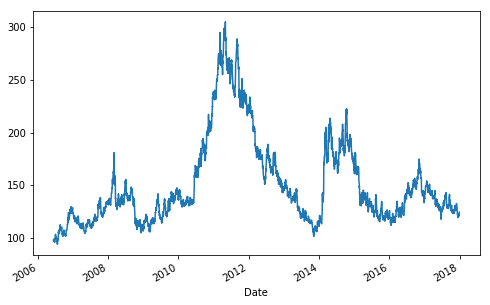

In [42]:
coffee.loc[coffee.index < '2018-01-01']['Open'].plot(figsize=(8, 5))
savefig('figures/coffee.eps')

# Feature Engineering

Code below create date features. In order to capture cyclicality I have transformed features as trading day of month or day of week into $sin$ and $cos$ values.
I am not sure whether this transformation grants subsequent PCA usage.

In [43]:
import numpy as np
import holidays

def trading_day_of_month(tm):
    ts = (tm - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
    dt = datetime.datetime.fromtimestamp(ts)
    di = datetime.date(year=dt.year, month=dt.month, day=1)
    us_holidays = holidays.UnitedStates()
    cnt = 1
    for i in range(1, 32):
        if i == dt.day:
            break
        if di.weekday() in [0, 1, 2, 3, 4] and dt not in us_holidays:
            cnt += 1
        di += datetime.timedelta(days=1)
    return cnt


def create_cycle(x, period):
    sn = np.sin(x*(2.*np.pi/period))
    cs = np.cos(x*(2.*np.pi/period))
    return sn, cs


def create_vectors(df, df_cot):
    global trading_days_in_year
    nv = df.shape[1]-2
    i_t = df.shape[1]-1
    ans_dct = {}
    for i in range(df.shape[0]):
        if i < 2*trading_days_in_year:
            continue
        mtrx = df.iloc[i-2*trading_days_in_year:i, 0:nv].values
        size = np.prod(mtrx.shape)
        mtrx = list(mtrx.reshape(size))
        idx = df.index.values[i]
        # add COT report to the end of list
        mtrx_cot = df_cot[df_cot.index < idx].values[-8:]
        size = np.prod(mtrx_cot.shape)
        mtrx_cot = list(mtrx_cot.reshape(size))
        if size < 16:
            mtrx_cot += [0 for i in range(16-size)]
        # Date Features
        ts = (idx - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
        dt = datetime.datetime.fromtimestamp(ts)
        wsn, wcs = create_cycle(dt.weekday(), 5)
        # period for trading day in month is at most 23
        tsn, tcs = create_cycle(trading_day_of_month(idx), 23)
        dsn, dcs = create_cycle(dt.month, 12)
        qsn, qcs = create_cycle((dt.month-1)//3, 4)
        mtrx_date = [wsn, wcs, tsn, tcs, dsn, dcs, qsn, qcs]
        # mtrx_date = [wsn, wcs, tsn, tcs, dsn, dcs, qsn, qcs, df.loc[idx].wr]
        # mtrx_date = [dt.weekday(), trading_day_of_month(idx), dt.month, (dt.month-1)//3, df.loc[idx].wr]
        # Combine list
        mtrx = mtrx + mtrx_cot + mtrx_date
        mtrx.append(df.iloc[i, i_t])
        ans_dct[idx] = mtrx
    return pd.DataFrame.from_dict(ans_dct, orient='index')

In [44]:
gold_data = create_vectors(gold, gold_cot)
gold_data = gold_data.loc[:end_date]
corn_data = create_vectors(corn, corn_cot)
corn_data = corn_data.loc[:end_date]
coffee_data = create_vectors(coffee, coffee_cot)
coffee_data = coffee_data.loc[:end_date]

cols = list(range(2544))
gold_data_reg = gold_data[cols].join(gold_gains[['gains']].rename(columns={"gains": 2544}))
corn_data_reg = corn_data[cols].join(corn_gains[['gains']].rename(columns={"gains": 2544}))
coffee_data_reg = coffee_data[cols].join(corn_gains[['gains']].rename(columns={"gains": 2544}))

In [45]:
gold_data.tail()

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2018-12-21,1134.0,1138.8,1131.0,1133.2,110023.0,1133.2,1135.5,1128.6,1130.7,115561.0,...,0.346733,-0.951057,0.309017,-0.816970,-0.576680,-2.449294e-16,1.0,-1.0,-1.836970e-16,1.0
2018-12-24,1133.2,1135.5,1128.6,1130.7,115561.0,1130.0,1137.3,1129.5,1133.6,71039.0,...,0.346733,0.000000,1.000000,-0.942261,-0.334880,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0
2018-12-26,1130.0,1137.3,1129.5,1133.6,71039.0,1135.3,1151.7,1132.8,1138.8,102763.0,...,0.346733,0.587785,-0.809017,-0.979084,0.203456,-2.449294e-16,1.0,-1.0,-1.836970e-16,1.0
2018-12-27,1135.3,1151.7,1132.8,1138.8,102763.0,1139.3,1145.1,1137.1,1140.9,100470.0,...,0.346733,-0.587785,-0.809017,-0.887885,0.460065,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0
2018-12-28,1139.3,1145.1,1137.1,1140.9,100470.0,1143.1,1160.6,1142.6,1158.1,153065.0,...,0.346733,-0.951057,0.309017,-0.730836,0.682553,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0


In [46]:
gold_data_reg.head()

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2008-06-06,590.5,595.0,565.5,566.8,93899.0,570.0,575.5,565.4,566.5,68729.0,...,0.698322,-0.951057,0.309017,0.979084,0.203456,1.224647e-16,-1.0,1.0,6.123234e-17,-760.0
2008-06-09,570.0,575.5,565.4,566.5,68729.0,573.5,579.5,569.5,570.3,52628.0,...,0.698322,0.000000,1.000000,0.997669,-0.068242,1.224647e-16,-1.0,1.0,6.123234e-17,-2213.5
2008-06-10,573.5,579.5,569.5,570.3,52628.0,581.2,582.5,570.5,581.7,43947.0,...,0.698322,0.951057,0.309017,0.942261,-0.334880,1.224647e-16,-1.0,1.0,6.123234e-17,1111.5
2008-06-11,581.2,582.5,570.5,581.7,43947.0,572.8,578.4,571.0,572.4,27362.0,...,0.584221,0.587785,-0.809017,0.816970,-0.576680,1.224647e-16,-1.0,1.0,6.123234e-17,-1092.5
2008-06-12,572.8,578.4,571.0,572.4,27362.0,572.0,581.0,567.8,580.5,39962.0,...,0.584221,-0.587785,-0.809017,0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,199.5


Removing Nan from data

In [47]:
gold_data.shape

(2668, 2545)

In [48]:
gold_data = gold_data.dropna()
gold_data.shape

(2668, 2545)

In [49]:
print(corn_data.shape)
corn_data = corn_data.dropna()
corn_data.shape

(2664, 2545)


(2664, 2545)

In [50]:
print(coffee_data.shape)
coffee_data = coffee_data.dropna()
coffee_data.shape

(2655, 2545)


(2655, 2545)

In [51]:
print(gold_data_reg.shape)
gold_data_reg = gold_data_reg.dropna()
gold_data_reg.shape

(2668, 2545)


(2668, 2545)

In [52]:
print(corn_data_reg.shape)
corn_data_reg = corn_data_reg.dropna()
corn_data_reg.shape

(2664, 2545)


(2664, 2545)

In [53]:
print(coffee_data_reg.shape)
coffee_data_reg = coffee_data_reg.dropna()
coffee_data_reg.shape

(2655, 2545)


(2654, 2545)

In [54]:
gold_cot.head(5)

,Prod_net_position_perc,Money_manager_net_position_perc
Date,,
2006-06-13,NaN,NaN
2006-06-20,1.000000,0.000000
2006-06-27,1.000000,0.000000
2006-07-03,0.919154,0.246529
2006-07-11,0.792600,1.000000


In [55]:
gold_data = gold_data.loc[gold_data.index >= '2007-01-01']
corn_data = corn_data.loc[corn_data.index >= '2007-01-01']
coffee_data = coffee_data.loc[coffee_data.index >= '2007-01-01']

gold_data_reg = gold_data_reg.loc[gold_data_reg.index >= '2007-01-01']
corn_data_reg = corn_data_reg.loc[corn_data_reg.index >= '2007-01-01']
coffee_data_reg = coffee_data_reg.loc[coffee_data_reg.index >= '2007-01-01']

In [56]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FactorAnalysis

validate_date = '2018-01-01'


def data_split_pca_transform(df):
    global validate_date
    label_index = 2544
    df_validate = df.loc[validate_date <= df.index]
    df_data_tt = df.loc[validate_date > df.index]
    df_train, df_test, label_train, label_test = train_test_split(df_data_tt[list(range(label_index))], df_data_tt[label_index], test_size=0.2, random_state=2242)
    
    pca = PCA(n_components=200, random_state=2234)
    # pca = FactorAnalysis(n_components=5, random_state=2234)
    pca.fit(df_train[list(range(label_index))])
    
    return df_train, df_test, label_train, label_test, df_validate[list(range(label_index))], df_validate[label_index], pca


def pca_transform(df, pca):
    label_index = 2544
    df_pca = pca.transform(df[list(range(label_index))])
    
    return df_pca

In [57]:
gold_train, gold_test, gold_label_train, gold_label_test, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
corn_train, corn_test, corn_label_train, corn_label_test, corn_validate, corn_label_validate, corn_pca = data_split_pca_transform(corn_data)
coffee_train, coffee_test, coffee_label_train, coffee_label_test, coffee_validate, coffee_label_validate, coffee_pca = data_split_pca_transform(coffee_data)

gold_reg_train, gold_reg_test, gold_reg_label_train, gold_reg_label_test, gold_reg_validate, gold_reg_label_validate, gold_reg_pca = data_split_pca_transform(gold_data_reg)
corn_reg_train, corn_reg_test, corn_reg_label_train, corn_reg_label_test, corn_reg_validate, corn_reg_label_validate, corn_reg_pca = data_split_pca_transform(corn_data_reg)
coffee_reg_train, coffee_reg_test, coffee_reg_label_train, coffee_reg_label_test, coffee_reg_validate, coffee_reg_label_validate, coffee_reg_pca = data_split_pca_transform(coffee_data_reg)

# Outlier detection
The code below is using random forest. I am relying on automatic outlier detection.

In [58]:
from sklearn.ensemble import IsolationForest
# from sklearn.neighbors import LocalOutlierFactor

pca_gold = pca_transform(gold_train, gold_pca)
out_gold = IsolationForest(contamination='auto', behaviour='new', random_state=428)
modified_gold = out_gold.fit_predict(pca_gold)

pca_corn = pca_transform(corn_train, corn_pca)
out_corn = IsolationForest(contamination='auto', behaviour='new', random_state=912)
modified_corn = out_corn.fit_predict(pca_corn)

pca_coffee = pca_transform(coffee_train, coffee_pca)
out_coffee = IsolationForest(contamination='auto', behaviour='new', random_state=832)
modified_coffee = out_coffee.fit_predict(pca_coffee)


def remove_outliers(arr, y, isolation):
    lst = out_gold.predict(X)
    a = []
    y_a = []
    for v, h, k in zip(lst, y, X):
        if v == 1:
            a.append(k)
            y_a.append(h)
    a = np.array(a)
    y_a = np.array(y_a)
    return a, y_a

In [59]:
def plot_hist_perc(x):
    df = pd.DataFrame(x)

    ln = df[0].count()
    dct = {}
    dct[-1] = df[df[0] == -1][0].count() / ln
    dct[1] = df[df[0] == 1][0].count() / ln
    
    print('outliers: ' + str(df[df[0] == -1][0].count()))
    print('inliers: ' + str(df[df[0] == 1][0].count()))

    rf = pd.DataFrame.from_dict(dct, orient='index')

    ax = rf.plot(kind='bar', figsize=(10,5), legend=False)
    for i in ax.patches:
        ax.text(i.get_x()-.2, i.get_height()-.05, \
                str(round(i.get_height(),4)), fontsize=15)

outliers: 6
inliers: 1927


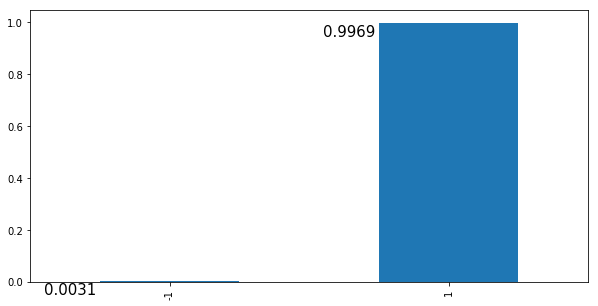

In [60]:
plot_hist_perc(modified_gold)
savefig('figures/gold_outliers.eps')

In [61]:
gold_out = []

for v in pca_gold:
    [p] = out_gold.predict([v])
    if p != 1:
        gold_out.append(v)

In [62]:
gold_out_orig = []

for index, row in gold_train.iterrows():
    [nv] = pca_transform(gold_train.loc[[index]], gold_pca)
    check = [1 for v in gold_out if np.allclose(v, nv)]
    if check:
        print(index)
        gold_out_orig.append(v)

2017-09-25 00:00:00
2017-11-14 00:00:00
2017-11-20 00:00:00
2017-12-05 00:00:00
2017-12-22 00:00:00
2017-12-12 00:00:00


outliers: 15
inliers: 1915


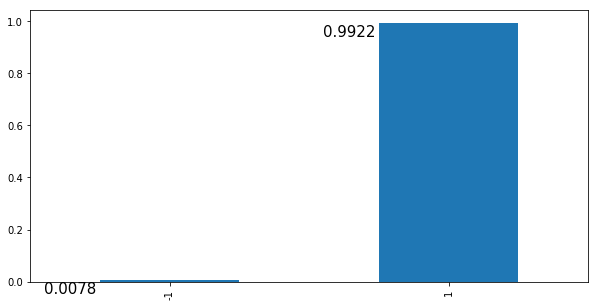

In [63]:
plot_hist_perc(modified_corn)
savefig('figures/corn_outliers.eps')

In [64]:
corn_out = []

for v in pca_corn:
    [p] = out_corn.predict([v])
    if p != 1:
        corn_out.append(v)
        
corn_out_orig = []

for index, row in corn_train.iterrows():
    [nv] = pca_transform(corn_train.loc[[index]], corn_pca)
    check = [1 for v in corn_out if np.allclose(v, nv)]
    if check:
        print(index)
        corn_out_orig.append(v)

2017-06-08 00:00:00
2017-09-28 00:00:00
2017-08-01 00:00:00
2017-03-24 00:00:00
2017-11-13 00:00:00
2017-09-01 00:00:00
2017-09-20 00:00:00
2017-10-30 00:00:00
2017-07-10 00:00:00
2017-06-16 00:00:00
2017-06-26 00:00:00
2017-10-10 00:00:00
2017-09-18 00:00:00
2017-11-02 00:00:00
2017-08-02 00:00:00


Coffee data contains unusually big number of outliers - maybe this could be modified by increasing number of PCA components.

outliers: 346
inliers: 1577


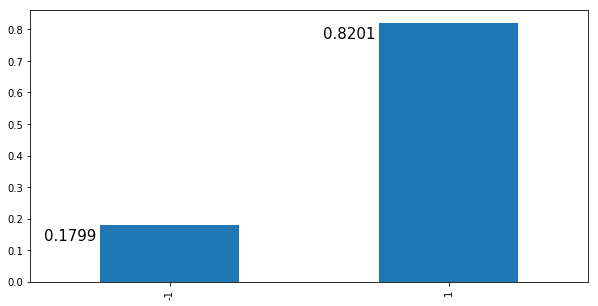

In [65]:
plot_hist_perc(modified_coffee)
savefig('figures/coffee_outliers.eps')

In [66]:
coffee_out = []

for v in pca_coffee:
    [p] = out_coffee.predict([v])
    if p != 1:
        coffee_out.append(v)
        
coffee_out_orig = []

for index, row in coffee_train.iterrows():
    [nv] = pca_transform(coffee_train.loc[[index]], coffee_pca)
    check = [1 for v in coffee_out if np.allclose(v, nv)]
    if check:
        print(index)
        coffee_out_orig.append(v)

2008-06-26 00:00:00
2010-01-07 00:00:00
2009-04-06 00:00:00
2008-08-28 00:00:00
2008-07-02 00:00:00
2008-11-25 00:00:00
2008-12-04 00:00:00
2008-09-16 00:00:00
2010-01-28 00:00:00
2009-08-12 00:00:00
2010-01-08 00:00:00
2008-09-15 00:00:00
2009-09-02 00:00:00
2009-02-09 00:00:00
2009-05-29 00:00:00
2009-07-20 00:00:00
2009-09-18 00:00:00
2009-07-08 00:00:00
2009-02-11 00:00:00
2008-11-03 00:00:00
2009-03-10 00:00:00
2009-12-10 00:00:00
2009-02-02 00:00:00
2009-04-01 00:00:00
2008-08-29 00:00:00
2009-02-20 00:00:00
2008-12-01 00:00:00
2008-12-24 00:00:00
2009-08-17 00:00:00
2009-06-25 00:00:00
2009-08-21 00:00:00
2010-03-02 00:00:00
2008-07-18 00:00:00
2009-08-19 00:00:00
2009-11-30 00:00:00
2008-12-19 00:00:00
2009-11-13 00:00:00
2009-09-08 00:00:00
2009-12-14 00:00:00
2009-06-18 00:00:00
2009-04-17 00:00:00
2009-10-23 00:00:00
2009-02-06 00:00:00
2009-11-03 00:00:00
2009-01-21 00:00:00
2009-05-28 00:00:00
2009-05-11 00:00:00
2008-12-30 00:00:00
2009-01-28 00:00:00
2008-10-20 00:00:00


In [67]:
def create_pca_training(df, df_pca, name, validation=0.2):
    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = np.array(list(map(lambda x: x if x >= 0 else 0, df.loc[df.index < '2018-1-1'][2544].values)))
    gdf['label'] = gdf.label.astype(int)
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_long_validation.csv', index=False)
    train_df.to_csv(name + '_long_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = np.array(list(map(lambda x: x if x >= 0 else 0, df.loc[df.index >= '2018-1-1'][2544].values)))
    gdf_test['label'] = gdf_test.label.astype(int)
    gdf_test.to_csv(name + '_long_test.csv', index=False)

    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = np.array(list(map(lambda x: 1 if x < 0 else 0, df.loc[df.index < '2018-1-1'][2544].values)))
    gdf['label'] = gdf.label.astype(int)
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_short_validation.csv', index=False)
    train_df.to_csv(name + '_short_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = np.array(list(map(lambda x: 1 if x < 0 else 0, df.loc[df.index >= '2018-1-1'][2544].values)))
    gdf_test['label'] = gdf_test.label.astype(int)
    gdf_test.to_csv(name + '_short_test.csv', index=False)


def create_pca_reg_training(df, df_pca, name, validation=0.2):
    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = df.loc[df.index < '2018-1-1'][2544].values
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_validation.csv', index=False)
    train_df.to_csv(name + '_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = df.loc[df.index >= '2018-1-1'][2544].values
    gdf_test.to_csv(name + '_test.csv', index=False)


create_pca_training(gold_data, gold_pca, 'data/gold_pca')
create_pca_training(corn_data, corn_pca, 'data/corn_pca')
create_pca_training(coffee_data, coffee_pca, 'data/coffee_pca')

create_pca_reg_training(gold_data_reg, gold_pca, 'data/gold_pca_reg')
create_pca_reg_training(corn_data_reg, corn_pca, 'data/corn_pca_reg')
create_pca_reg_training(coffee_data_reg, coffee_pca, 'data/coffee_pca_reg')

### Dimension reduction with PCA

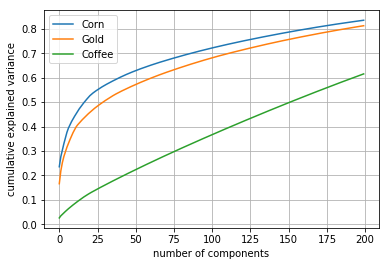

In [68]:
plt.plot(np.cumsum(corn_pca.explained_variance_ratio_), label='Corn')
plt.plot(np.cumsum(gold_pca.explained_variance_ratio_), label='Gold')
plt.plot(np.cumsum(coffee_pca.explained_variance_ratio_), label='Coffee')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid(True)
plt.legend()
# plt.show()
plt.savefig('figures/pca.eps')

It is interesting Corn is best explained by PCA transformation. It is probably due to clear seasonal patterns in trading.

I am surprised that gold is better explained by PCA transformation than Coffee. I would expect that coffee has stronger seasonal trading patterns than gold because of the growth cycle. Maybe gold mining is subject to the weather in similar way as agricultural commodities. Gold is still mostly recycled and new production has limited impact on total amount of traded gold.

Possible explanations:
- corn traded on CME is mostly US produced with stable harvest season
- production of coffee is very unpredictable depending on the conditions of a given year
- there are multiple producers around the world (coffee is more of a global market with limited US production) with different harvest periods https://driftaway.coffee/when-is-coffee-harvested/
- important difference between coffee and corn is price per unit corn is much less efficient to transport
    - 1 kg of corn is worth about 15¢
    - 1 kg of coffee is worth about 230¢
    
Based on this graph I think that PCA transformation is not suitable for coffee. Information in components is growing linearly. If we don't see sharp increase of cumulative explained variance with few first components, then PCA transformation is not suitable. Therefore, coffee should not be considered for trading. I will continue with coffee as well but based on this transformation I would not go ahead with trading unless I would find different transformation.

In [69]:
# np.cumsum(gold_pca.explained_variance_ratio_)[268]

In [70]:
gold_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2008-06-06,590.5,595.0,565.5,566.8,93899.0,570.0,575.5,565.4,566.5,68729.0,...,0.698322,-0.951057,0.309017,0.979084,0.203456,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-09,570.0,575.5,565.4,566.5,68729.0,573.5,579.5,569.5,570.3,52628.0,...,0.698322,0.000000,1.000000,0.997669,-0.068242,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-10,573.5,579.5,569.5,570.3,52628.0,581.2,582.5,570.5,581.7,43947.0,...,0.698322,0.951057,0.309017,0.942261,-0.334880,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-11,581.2,582.5,570.5,581.7,43947.0,572.8,578.4,571.0,572.4,27362.0,...,0.584221,0.587785,-0.809017,0.816970,-0.576680,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-12,572.8,578.4,571.0,572.4,27362.0,572.0,581.0,567.8,580.5,39962.0,...,0.584221,-0.587785,-0.809017,0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,0.0
2008-06-13,572.0,581.0,567.8,580.5,39962.0,577.0,591.5,573.5,591.0,43918.0,...,0.584221,-0.951057,0.309017,0.398401,-0.917211,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-16,577.0,591.5,573.5,591.0,43918.0,588.0,593.5,584.5,585.4,42916.0,...,0.584221,0.000000,1.000000,0.136167,-0.990686,1.224647e-16,-1.0,1.0,6.123234e-17,0.0
2008-06-17,588.0,593.5,584.5,585.4,42916.0,574.5,589.0,574.5,588.0,33705.0,...,0.584221,0.951057,0.309017,-0.136167,-0.990686,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-18,574.5,589.0,574.5,588.0,33705.0,586.2,589.5,580.0,587.7,30510.0,...,0.604415,0.587785,-0.809017,-0.398401,-0.917211,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-19,586.2,589.5,580.0,587.7,30510.0,589.5,599.0,583.7,584.4,47778.0,...,0.604415,-0.587785,-0.809017,-0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,0.0


In [71]:
import os
import platform

print(platform.platform())

if platform.system() == 'Darwin':
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

Linux-4.15.0-45-generic-x86_64-with-debian-buster-sid


In [72]:
def get_round_ceiling(sr):
    return (np.ceil(sr.max()+1000)//1000+1)*1000

In [73]:
from numpy import size
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score


def make_label(v, threshold, fee):
    if abs(v)-fee > threshold:
        if v > 0:
            return 1
        else:
            return -1
    return 0


def print_2d(f):
    return format(f, '.2f')


def earnings_per_trade(df):
    ans = 0
    if df[df.trade != 0].trade.count() != 0:
        ans = (df[df.trade != 0].gains.sum())/(df[df.trade != 0].trade.count())
    return ans


def earnings_per_shorts(df):
    ans = 0
    if df[df.trade == -1].trade.count() != 0:
        ans = (df[df.trade == -1].gains.sum())/(df[df.trade == -1].trade.count())
    return ans


def earnings_per_longs(df):
    ans = 0
    if df[df.trade == 1].trade.count() != 0:
        ans = (df[df.trade == 1].gains.sum())/(df[df.trade == 1].trade.count())
    return ans


def get_performance(model, pca, df_gains, df, labels, regression=False, target=200, stop_loss_long=1000, stop_loss_short=800, debug=False, name=''):
    df = pca_transform(df, pca)
    preds = model.predict(df)
    if regression and not np.isscalar(preds[0]):
        preds = np.reshape(preds, (preds.shape[0],))
    l = preds.shape[0]
    if regression:
        ax = sns.distplot(preds - df_gains.gains.values[:l], hist = False, kde = True,
                          kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Residual")
        title = ax.set_title('Kernel density of residuals', size=15)
        savefig('figures/' + name + '_kernel_density_residuals.eps')
        fig1, ax1 = plt.subplots()
        ax1 = sns.scatterplot(x=preds, y=df_gains.gains.values[:l])
        ax1.set_xlabel('Predictions')
        ax1.set_ylabel('Actuals')
        title = ax1.set_title('Actual vs Prediction scatter plot', size=15)
        savefig('figures/' + name + '_actual_prediction.eps')
        print("Predictions/Actual volatility correlation: ", np.corrcoef(preds, df_gains.gains.values[:l])[0][1])
    # print("Predictions/Actual volatility correlation for : ", np.corrcoef(preds, df_gains.gains.values[:l][0][1]))
    if debug:
        print(preds)
    predictions = []
    for v in preds:
        if not regression:
            i = pd.Series(v).idxmax()
            if i == 0:
                predictions.append(0)
            elif i == 1:
                predictions.append(-1)
            else:
                predictions.append(1)
        else:
            if abs(v) > target:
                if v > 0:
                    predictions.append(1)
                else:
                    predictions.append(-1)
            else:
                predictions.append(0)
    return get_account(predictions, df_gains, labels, stop_loss_long, stop_loss_short, regression, name, target)


def get_account(predictions, df_gains, labels, stop_loss_long=1000, stop_loss_short=800, regression=False, name='', target=0):
    global account_size, fee
    acc = account_size
    dct = {}
    dct['account'] = [acc]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['short'] = [0]
    dct['long'] = [0]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['stop_loss'] = [0]
    dct['gains'] = [0]
    dct['predicted_value'] = [0]
    dct['true_value'] = [0]
    for p, l, v in zip(predictions, labels, df_gains.values):
        short = 0
        long = 0
        s_l = 0
        gains = 0
        if p == -1.0:
            short = 1
            if (v[2] - v[1]) > stop_loss_short:
                gains = -stop_loss
                s_l = 1
            else:
                gains = -v[0] - fee
        elif p == 1.0:
            long = 1
            if (v[1] - v[3]) > stop_loss_long:
                gains = -stop_loss
                s_l = 1
            else:
                gains = v[0] - fee
        else:
            pass
        acc += gains
        dct['account'].append(acc)
        dct['short'].append(short)
        dct['long'].append(long)
        dct['stop_loss'].append(s_l)
        dct['trade'].append(float(p))
        dct['label'].append(l)
        dct['gains'].append(gains)
        dct['predicted_value'].append(p)
        dct['true_value'].append(v[0])
        if acc <= 0:
            break
    rf = pd.DataFrame.from_dict(dct)
    rf['id'] = rf.index.values
    rf['trade_visual'] = rf.trade*1000
    ax1 = rf[['account']].plot(grid=True, figsize=(15, 5))
    rf.plot(ax=ax1, x='id', y='trade_visual', color='g', grid=True)
    ax1.set_ylim(-2000, get_round_ceiling(rf.account))
    savefig('figures/' + name + '_account.eps')
    print("Returns ", print_2d((rf.account.values[-1]/rf.account.values[0])*100-100), "%")
    print("Number of trades: ", rf[rf.trade != 0].trade.count())
    print("Number of short trades: ", rf[rf.trade == -1].trade.count())
    print("Number of long trades: ", rf[rf.trade == 1].trade.count())
    print("Earnings per trade: ", print_2d(earnings_per_trade(rf)))
    print("Earnings per short trade: ", print_2d(earnings_per_shorts(rf)))
    print("Earnings per long trade: ", print_2d(earnings_per_longs(rf)))
    if regression:
        label = list(map(lambda x: make_label(x, target, fee), rf.label))
        # print(rf.label)
        # print(label)
    else:
        label = rf.label
    print("Precision score: ", precision_score(label, rf.trade, average=None))
    if not regression:
        # print("Precision score: ", precision_score(list(map(, rf.label)), rf.trade, average=None))
        fig3, ax3 = plt.subplots()
        cm = confusion_matrix(rf['label'].astype(int), rf['trade'].astype(int))
        sns.heatmap(cm, annot=True, fmt="d", ax=ax3)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        savefig('figures/' + name + '_heatmap.eps')
        fig4, ax4 = plt.subplots()
        sns.heatmap(cm, annot=True, fmt="f", ax=ax4)
    fig2, ax2 = plt.subplots()
    rf.trade.hist(ax=ax2)
    title = ax2.set_title('Histogram of trades -1 short, 0 no trade, 1 long', size=15)
    savefig('figures/' + name + '_trade_histogram.eps')
    return rf

# General strategy for training
I tried the same model for all three commodities (gold, corn and coffee). I am looking for classifier with the same parameters for any commodity. This way I can be sure that I have found some general classification and good results are not just a coincidence.

Following exploration can be split into:
- classificator
- regressor

# LightGBM Regressor
I tried training lightGBM classifier to train on data with created labels.

- gold 57% gains
- corn 2% gains
- coffee 34% gains

In [74]:
# %%capture cpt_gold_train
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold
import lightgbm as lgb
# import xgboost as xgb

# categoricals = [10, 11, 12, 13]
X = pca_transform(gold_reg_train, gold_reg_pca)
y = gold_reg_label_train
# train_data = lgb.Dataset(X, label=y, categorical_feature=categoricals) # categorical_feature=[3040,3041,3042,3043])
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(gold_reg_test, gold_reg_pca)
y_test = gold_reg_label_test
# test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categoricals)
test_data = lgb.Dataset(X_test, label=y_test)

param = {}
param['num_leaves'] = 40
param['objective'] = 'regression'
param['boosting'] = 'dart'
# param['metric'] = 'binary_error'
# param['metric'] = 'ROC'
param['metric'] = 'l2'
param['estimators'] = 1000
param['learning_rate'] = 0.001
param['num_class'] = 1
param['max_bin'] = 30
param['reg_alpha'] = 5
param['reg_lambda'] = 10
num_round = 1000

np.random.seed = 4567
gold_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's l2: 1.62038e+06
[2]	valid_0's l2: 1.62037e+06
[3]	valid_0's l2: 1.62036e+06
[4]	valid_0's l2: 1.62035e+06
[5]	valid_0's l2: 1.62034e+06
[6]	valid_0's l2: 1.62033e+06
[7]	valid_0's l2: 1.62032e+06
[8]	valid_0's l2: 1.62033e+06
[9]	valid_0's l2: 1.62032e+06
[10]	valid_0's l2: 1.62031e+06
[11]	valid_0's l2: 1.6203e+06
[12]	valid_0's l2: 1.6203e+06
[13]	valid_0's l2: 1.62029e+06
[14]	valid_0's l2: 1.62029e+06
[15]	valid_0's l2: 1.62028e+06
[16]	valid_0's l2: 1.62027e+06
[17]	valid_0's l2: 1.62026e+06
[18]	valid_0's l2: 1.62024e+06
[19]	valid_0's l2: 1.62024e+06
[20]	valid_0's l2: 1.62022e+06
[21]	valid_0's l2: 1.62022e+06
[22]	valid_0's l2: 1.6202e+06
[23]	valid_0's l2: 1.6202e+06
[24]	valid_0's l2: 1.62018e+06
[25]	valid_0's l2: 1.62017e+06
[26]	valid_0's l2: 1.62015e+06
[27]	valid_0's l2: 1.62015e+06
[28]	valid_0's l2: 1.62015e+06
[29]	valid_0's l2: 1.62014e+06
[30]	valid_0's l2: 1.62014e+06
[31]	valid_0's l2: 1.62014e+06
[32]	valid_0's l2: 1.62012e+06
[33]	valid_0's l2: 1.

[307]	valid_0's l2: 1.62213e+06
[308]	valid_0's l2: 1.62218e+06
[309]	valid_0's l2: 1.62216e+06
[310]	valid_0's l2: 1.62218e+06
[311]	valid_0's l2: 1.62223e+06
[312]	valid_0's l2: 1.6223e+06
[313]	valid_0's l2: 1.62232e+06
[314]	valid_0's l2: 1.6223e+06
[315]	valid_0's l2: 1.62228e+06
[316]	valid_0's l2: 1.62229e+06
[317]	valid_0's l2: 1.62235e+06
[318]	valid_0's l2: 1.62242e+06
[319]	valid_0's l2: 1.62239e+06
[320]	valid_0's l2: 1.62244e+06
[321]	valid_0's l2: 1.62242e+06
[322]	valid_0's l2: 1.62244e+06
[323]	valid_0's l2: 1.62247e+06
[324]	valid_0's l2: 1.62245e+06
[325]	valid_0's l2: 1.62249e+06
[326]	valid_0's l2: 1.62247e+06
[327]	valid_0's l2: 1.62251e+06
[328]	valid_0's l2: 1.62249e+06
[329]	valid_0's l2: 1.62255e+06
[330]	valid_0's l2: 1.62252e+06
[331]	valid_0's l2: 1.6225e+06
[332]	valid_0's l2: 1.62247e+06
[333]	valid_0's l2: 1.62245e+06
[334]	valid_0's l2: 1.62243e+06
[335]	valid_0's l2: 1.62246e+06
[336]	valid_0's l2: 1.62244e+06
[337]	valid_0's l2: 1.62249e+06
[338]	valid

[601]	valid_0's l2: 1.62573e+06
[602]	valid_0's l2: 1.6257e+06
[603]	valid_0's l2: 1.62577e+06
[604]	valid_0's l2: 1.62574e+06
[605]	valid_0's l2: 1.62571e+06
[606]	valid_0's l2: 1.62569e+06
[607]	valid_0's l2: 1.62567e+06
[608]	valid_0's l2: 1.62569e+06
[609]	valid_0's l2: 1.62573e+06
[610]	valid_0's l2: 1.62579e+06
[611]	valid_0's l2: 1.62585e+06
[612]	valid_0's l2: 1.62589e+06
[613]	valid_0's l2: 1.62586e+06
[614]	valid_0's l2: 1.62586e+06
[615]	valid_0's l2: 1.62594e+06
[616]	valid_0's l2: 1.626e+06
[617]	valid_0's l2: 1.62598e+06
[618]	valid_0's l2: 1.62604e+06
[619]	valid_0's l2: 1.62611e+06
[620]	valid_0's l2: 1.62613e+06
[621]	valid_0's l2: 1.62611e+06
[622]	valid_0's l2: 1.62608e+06
[623]	valid_0's l2: 1.62615e+06
[624]	valid_0's l2: 1.62612e+06
[625]	valid_0's l2: 1.62618e+06
[626]	valid_0's l2: 1.62625e+06
[627]	valid_0's l2: 1.62626e+06
[628]	valid_0's l2: 1.6263e+06
[629]	valid_0's l2: 1.62627e+06
[630]	valid_0's l2: 1.62624e+06
[631]	valid_0's l2: 1.62631e+06
[632]	valid_

[858]	valid_0's l2: 1.62919e+06
[859]	valid_0's l2: 1.62917e+06
[860]	valid_0's l2: 1.62921e+06
[861]	valid_0's l2: 1.62926e+06
[862]	valid_0's l2: 1.62934e+06
[863]	valid_0's l2: 1.62932e+06
[864]	valid_0's l2: 1.62929e+06
[865]	valid_0's l2: 1.62933e+06
[866]	valid_0's l2: 1.62939e+06
[867]	valid_0's l2: 1.62945e+06
[868]	valid_0's l2: 1.62942e+06
[869]	valid_0's l2: 1.62944e+06
[870]	valid_0's l2: 1.62941e+06
[871]	valid_0's l2: 1.62939e+06
[872]	valid_0's l2: 1.62939e+06
[873]	valid_0's l2: 1.62936e+06
[874]	valid_0's l2: 1.62934e+06
[875]	valid_0's l2: 1.62931e+06
[876]	valid_0's l2: 1.62934e+06
[877]	valid_0's l2: 1.62932e+06
[878]	valid_0's l2: 1.62936e+06
[879]	valid_0's l2: 1.62933e+06
[880]	valid_0's l2: 1.6293e+06
[881]	valid_0's l2: 1.62928e+06
[882]	valid_0's l2: 1.62934e+06
[883]	valid_0's l2: 1.62931e+06
[884]	valid_0's l2: 1.62936e+06
[885]	valid_0's l2: 1.6294e+06
[886]	valid_0's l2: 1.62948e+06
[887]	valid_0's l2: 1.62955e+06
[888]	valid_0's l2: 1.62962e+06
[889]	vali

Predictions/Actual volatility correlation:  0.09617259288031146
Returns  57.29 %
Number of trades:  45
Number of short trades:  27
Number of long trades:  18
Earnings per trade:  127.31
Earnings per short trade:  208.85
Earnings per long trade:  5.00
Precision score:  [0.55555556 0.19806763 0.38888889]


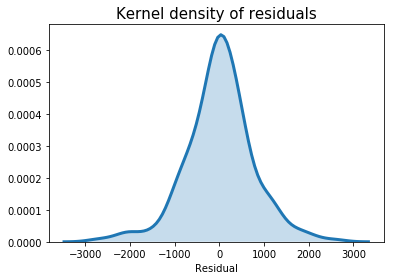

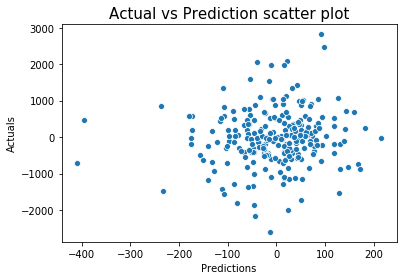

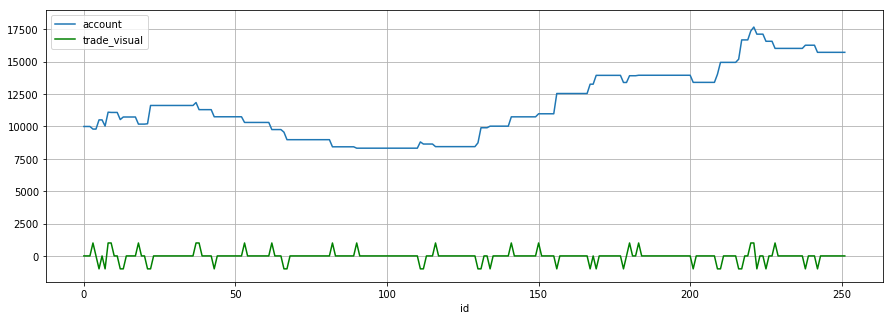

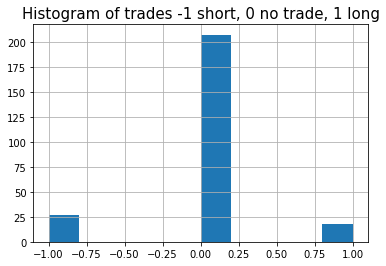

In [75]:
gold_account = get_performance(gold_clf, gold_reg_pca, gold_gains.loc[gold_gains.index > validate_date], gold_reg_validate, gold_reg_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True, target=100, name='gold_lgb')

In [76]:
X = pca_transform(corn_reg_train, corn_reg_pca)
y = corn_reg_label_train
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(corn_reg_test, corn_reg_pca)
y_test = corn_reg_label_test
test_data = lgb.Dataset(X_test, label=y_test)

corn_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's l2: 175904
[2]	valid_0's l2: 175905
[3]	valid_0's l2: 175907
[4]	valid_0's l2: 175908
[5]	valid_0's l2: 175900
[6]	valid_0's l2: 175902
[7]	valid_0's l2: 175894
[8]	valid_0's l2: 175893
[9]	valid_0's l2: 175895
[10]	valid_0's l2: 175887
[11]	valid_0's l2: 175889
[12]	valid_0's l2: 175888
[13]	valid_0's l2: 175881
[14]	valid_0's l2: 175883
[15]	valid_0's l2: 175876
[16]	valid_0's l2: 175877
[17]	valid_0's l2: 175870
[18]	valid_0's l2: 175872
[19]	valid_0's l2: 175866
[20]	valid_0's l2: 175869
[21]	valid_0's l2: 175867
[22]	valid_0's l2: 175860
[23]	valid_0's l2: 175863
[24]	valid_0's l2: 175856
[25]	valid_0's l2: 175859
[26]	valid_0's l2: 175853
[27]	valid_0's l2: 175855
[28]	valid_0's l2: 175855
[29]	valid_0's l2: 175850
[30]	valid_0's l2: 175852
[31]	valid_0's l2: 175852
[32]	valid_0's l2: 175847
[33]	valid_0's l2: 175849
[34]	valid_0's l2: 175849
[35]	valid_0's l2: 175850
[36]	valid_0's l2: 175850
[37]	valid_0's l2: 175852
[38]	valid_0's l2: 175849
[39]	valid_0's l2: 17

[333]	valid_0's l2: 175836
[334]	valid_0's l2: 175835
[335]	valid_0's l2: 175840
[336]	valid_0's l2: 175839
[337]	valid_0's l2: 175836
[338]	valid_0's l2: 175834
[339]	valid_0's l2: 175834
[340]	valid_0's l2: 175833
[341]	valid_0's l2: 175831
[342]	valid_0's l2: 175825
[343]	valid_0's l2: 175821
[344]	valid_0's l2: 175821
[345]	valid_0's l2: 175829
[346]	valid_0's l2: 175833
[347]	valid_0's l2: 175833
[348]	valid_0's l2: 175843
[349]	valid_0's l2: 175841
[350]	valid_0's l2: 175840
[351]	valid_0's l2: 175838
[352]	valid_0's l2: 175832
[353]	valid_0's l2: 175834
[354]	valid_0's l2: 175834
[355]	valid_0's l2: 175834
[356]	valid_0's l2: 175831
[357]	valid_0's l2: 175831
[358]	valid_0's l2: 175828
[359]	valid_0's l2: 175827
[360]	valid_0's l2: 175829
[361]	valid_0's l2: 175829
[362]	valid_0's l2: 175826
[363]	valid_0's l2: 175826
[364]	valid_0's l2: 175825
[365]	valid_0's l2: 175819
[366]	valid_0's l2: 175819
[367]	valid_0's l2: 175819
[368]	valid_0's l2: 175822
[369]	valid_0's l2: 175822
[

[640]	valid_0's l2: 175866
[641]	valid_0's l2: 175866
[642]	valid_0's l2: 175865
[643]	valid_0's l2: 175869
[644]	valid_0's l2: 175868
[645]	valid_0's l2: 175873
[646]	valid_0's l2: 175874
[647]	valid_0's l2: 175878
[648]	valid_0's l2: 175883
[649]	valid_0's l2: 175882
[650]	valid_0's l2: 175881
[651]	valid_0's l2: 175886
[652]	valid_0's l2: 175885
[653]	valid_0's l2: 175884
[654]	valid_0's l2: 175884
[655]	valid_0's l2: 175894
[656]	valid_0's l2: 175896
[657]	valid_0's l2: 175895
[658]	valid_0's l2: 175897
[659]	valid_0's l2: 175896
[660]	valid_0's l2: 175901
[661]	valid_0's l2: 175900
[662]	valid_0's l2: 175902
[663]	valid_0's l2: 175901
[664]	valid_0's l2: 175900
[665]	valid_0's l2: 175899
[666]	valid_0's l2: 175899
[667]	valid_0's l2: 175898
[668]	valid_0's l2: 175897
[669]	valid_0's l2: 175900
[670]	valid_0's l2: 175904
[671]	valid_0's l2: 175903
[672]	valid_0's l2: 175907
[673]	valid_0's l2: 175906
[674]	valid_0's l2: 175907
[675]	valid_0's l2: 175911
[676]	valid_0's l2: 175916
[

Predictions/Actual volatility correlation:  0.030004906267008552
Returns  2.48 %
Number of trades:  36
Number of short trades:  14
Number of long trades:  22
Earnings per trade:  6.89
Earnings per short trade:  43.29
Earnings per long trade:  -16.28
Precision score:  [0.64285714 0.1712963  0.40909091]


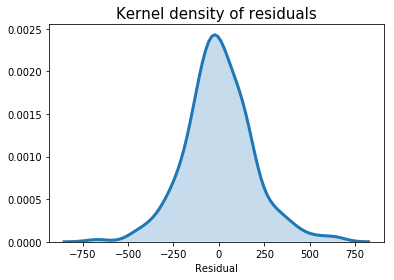

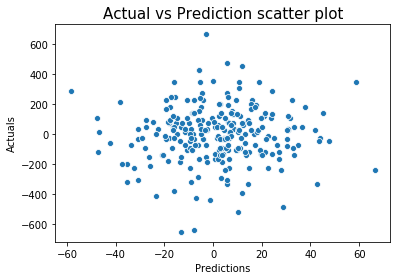

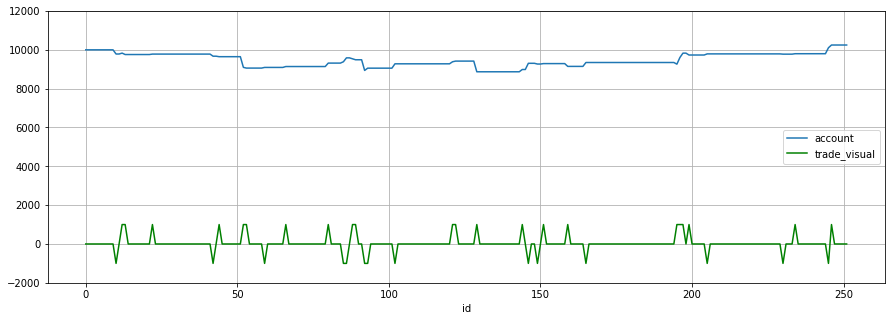

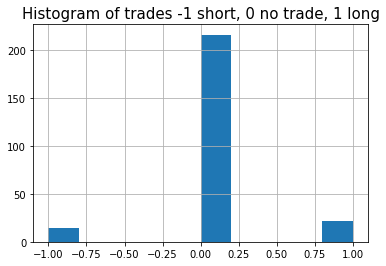

In [77]:
corn_account_lgb = get_performance(corn_clf, corn_reg_pca, corn_gains.loc[corn_gains.index > validate_date], corn_reg_validate, corn_reg_label_validate, stop_loss_long=300, stop_loss_short=300, regression=True, target=30, name='corn_lgb')

In [78]:
X = pca_transform(coffee_reg_train, coffee_reg_pca)
y = coffee_reg_label_train.values
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(coffee_reg_test, coffee_reg_pca)
y_test = coffee_reg_label_test.values
test_data = lgb.Dataset(X_test, label=y_test)

coffee_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's l2: 161691
[2]	valid_0's l2: 161691
[3]	valid_0's l2: 161691
[4]	valid_0's l2: 161692
[5]	valid_0's l2: 161693
[6]	valid_0's l2: 161693
[7]	valid_0's l2: 161695
[8]	valid_0's l2: 161695
[9]	valid_0's l2: 161695
[10]	valid_0's l2: 161697
[11]	valid_0's l2: 161701
[12]	valid_0's l2: 161700
[13]	valid_0's l2: 161701
[14]	valid_0's l2: 161704
[15]	valid_0's l2: 161706
[16]	valid_0's l2: 161709
[17]	valid_0's l2: 161700
[18]	valid_0's l2: 161704
[19]	valid_0's l2: 161695
[20]	valid_0's l2: 161699
[21]	valid_0's l2: 161698
[22]	valid_0's l2: 161690
[23]	valid_0's l2: 161694
[24]	valid_0's l2: 161685
[25]	valid_0's l2: 161690
[26]	valid_0's l2: 161692
[27]	valid_0's l2: 161686
[28]	valid_0's l2: 161684
[29]	valid_0's l2: 161685
[30]	valid_0's l2: 161679
[31]	valid_0's l2: 161679
[32]	valid_0's l2: 161685
[33]	valid_0's l2: 161683
[34]	valid_0's l2: 161683
[35]	valid_0's l2: 161683
[36]	valid_0's l2: 161684
[37]	valid_0's l2: 161690
[38]	valid_0's l2: 161688
[39]	valid_0's l2: 16

[322]	valid_0's l2: 161415
[323]	valid_0's l2: 161413
[324]	valid_0's l2: 161414
[325]	valid_0's l2: 161416
[326]	valid_0's l2: 161417
[327]	valid_0's l2: 161421
[328]	valid_0's l2: 161423
[329]	valid_0's l2: 161415
[330]	valid_0's l2: 161417
[331]	valid_0's l2: 161419
[332]	valid_0's l2: 161420
[333]	valid_0's l2: 161421
[334]	valid_0's l2: 161423
[335]	valid_0's l2: 161427
[336]	valid_0's l2: 161428
[337]	valid_0's l2: 161425
[338]	valid_0's l2: 161429
[339]	valid_0's l2: 161429
[340]	valid_0's l2: 161430
[341]	valid_0's l2: 161437
[342]	valid_0's l2: 161428
[343]	valid_0's l2: 161432
[344]	valid_0's l2: 161433
[345]	valid_0's l2: 161425
[346]	valid_0's l2: 161423
[347]	valid_0's l2: 161424
[348]	valid_0's l2: 161430
[349]	valid_0's l2: 161421
[350]	valid_0's l2: 161422
[351]	valid_0's l2: 161421
[352]	valid_0's l2: 161426
[353]	valid_0's l2: 161418
[354]	valid_0's l2: 161419
[355]	valid_0's l2: 161420
[356]	valid_0's l2: 161416
[357]	valid_0's l2: 161417
[358]	valid_0's l2: 161421
[

[663]	valid_0's l2: 161780
[664]	valid_0's l2: 161779
[665]	valid_0's l2: 161779
[666]	valid_0's l2: 161778
[667]	valid_0's l2: 161778
[668]	valid_0's l2: 161777
[669]	valid_0's l2: 161770
[670]	valid_0's l2: 161776
[671]	valid_0's l2: 161775
[672]	valid_0's l2: 161773
[673]	valid_0's l2: 161773
[674]	valid_0's l2: 161782
[675]	valid_0's l2: 161788
[676]	valid_0's l2: 161799
[677]	valid_0's l2: 161798
[678]	valid_0's l2: 161797
[679]	valid_0's l2: 161795
[680]	valid_0's l2: 161805
[681]	valid_0's l2: 161804
[682]	valid_0's l2: 161803
[683]	valid_0's l2: 161797
[684]	valid_0's l2: 161809
[685]	valid_0's l2: 161807
[686]	valid_0's l2: 161815
[687]	valid_0's l2: 161815
[688]	valid_0's l2: 161814
[689]	valid_0's l2: 161814
[690]	valid_0's l2: 161826
[691]	valid_0's l2: 161825
[692]	valid_0's l2: 161823
[693]	valid_0's l2: 161830
[694]	valid_0's l2: 161828
[695]	valid_0's l2: 161828
[696]	valid_0's l2: 161836
[697]	valid_0's l2: 161834
[698]	valid_0's l2: 161840
[699]	valid_0's l2: 161839
[

[998]	valid_0's l2: 162210
[999]	valid_0's l2: 162212
[1000]	valid_0's l2: 162212


Predictions/Actual volatility correlation:  -0.03164539084652848
Returns  34.10 %
Number of trades:  45
Number of short trades:  30
Number of long trades:  15
Earnings per trade:  75.78
Earnings per short trade:  158.71
Earnings per long trade:  -90.07
Precision score:  [0.46666667 0.0821256  0.26666667]


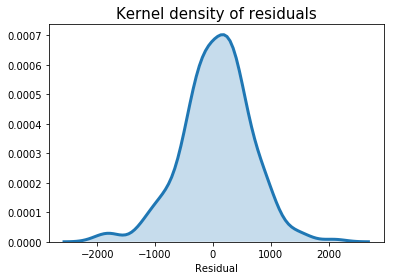

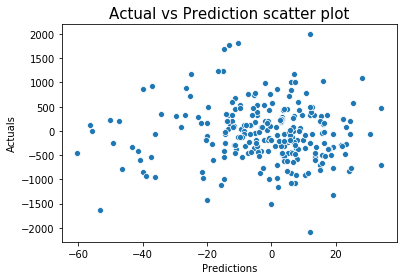

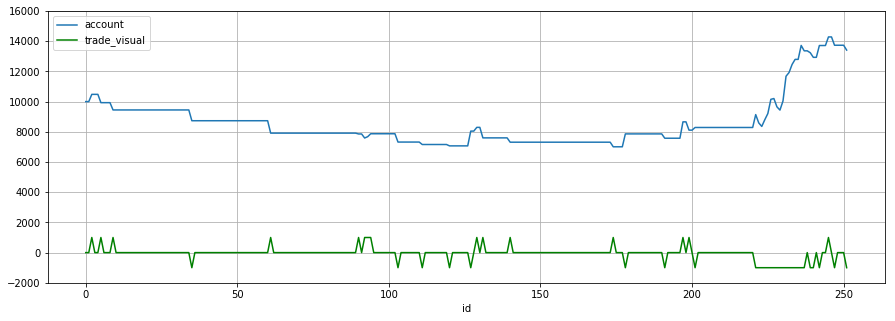

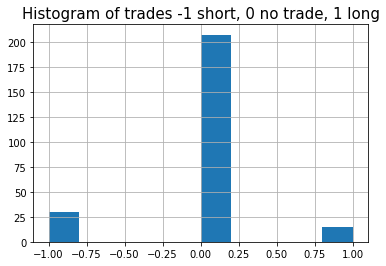

In [79]:
coffee_account_lgb = get_performance(coffee_clf, coffee_reg_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_reg_validate, coffee_reg_label_validate, stop_loss_long=1000, stop_loss_short=1000, regression=True, target=20, name='coffee_lgb')

# Neural Networks classifier
---


| commodity | gains % | earnings per trade | number of trades |
|-----------|---------|--------------------|------------------|
| gold      | 125     | 73.17              | 172              |
| corn      | 7       | 5.2                | 141              |
| coffee    | -100    | -90.6              | 111              |

In [133]:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/


def plot_training_history(history, name):
    # history = model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, verbose=0)
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('figures/' + name + '_keras_accuracy.eps')
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('figures/' + name + '_keras_loss.eps')

In [80]:
def create_target(x):
    if x == 1.0:
        return [0,0,1]
    elif x == 0.0:
        return [1,0,0]
    else:
        return [0,1,0]

In [126]:
X = pca_transform(gold_train, gold_pca)
y = gold_label_train
# remove outliers
X, y = remove_outliers(X, y, out_gold)

X_test = pca_transform(gold_test, gold_pca)
y_test = gold_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_gold)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

In [134]:
# %%capture training_gold
from keras.layers import Dropout, Flatten, Dense, Activation, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam
from keras.models import Sequential
from keras.metrics import categorical_accuracy, binary_accuracy, sparse_categorical_accuracy
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import RMSprop

input_shape = 200
num_classes = 3

def define_model(input_shape, num_classes):
    # Define a model
    opt = RMSprop(lr=0.0001)
    
    model = Sequential()  
    model.add(Dense(32, input_dim=input_shape, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Dense(8, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    model.add(Dense(num_classes))
    model.add(Activation('tanh'))

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# opt = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
# opt = Nadam(lr=0.002)
batch_size = 20
epochs = 500
model = define_model(input_shape, num_classes)

In [135]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.gold.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

In [136]:
# model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

model.summary()

Train on 1927 samples, validate on 484 samples
Epoch 1/500
1927/1927 [==============================] - ETA: 2:12 - loss: 84384448512.0000 - acc: 0.350 - ETA: 9s - loss: 77772024280.6154 - acc: 0.3192  - ETA: 4s - loss: 76954667089.9200 - acc: 0.316 - ETA: 2s - loss: 75040337366.4865 - acc: 0.316 - ETA: 1s - loss: 74169425664.0000 - acc: 0.320 - ETA: 0s - loss: 73844180514.1333 - acc: 0.320 - ETA: 0s - loss: 73604099086.0274 - acc: 0.317 - ETA: 0s - loss: 73955358888.6588 - acc: 0.316 - 2s 1ms/step - loss: 73393215397.6627 - acc: 0.3108 - val_loss: 70062563268.7603 - val_acc: 0.3120

Epoch 00001: val_loss improved from inf to 70062563268.76033, saving model to saved_models/weights.gold.hdf5
Epoch 2/500
1927/1927 [==============================] - ETA: 0s - loss: 59279454208.0000 - acc: 0.250 - ETA: 0s - loss: 70602449526.1538 - acc: 0.319 - ETA: 0s - loss: 69288732501.3333 - acc: 0.337 - ETA: 0s - loss: 68367907612.4444 - acc: 0.331 - ETA: 0s - loss: 68957788203.5745 - acc: 0.326 - ETA

1927/1927 [==============================] - ETA: 0s - loss: 22741745664.0000 - acc: 0.400 - ETA: 0s - loss: 23092368822.8571 - acc: 0.296 - ETA: 0s - loss: 22825187252.1481 - acc: 0.331 - ETA: 0s - loss: 22715758802.0513 - acc: 0.321 - ETA: 0s - loss: 22594821868.3077 - acc: 0.322 - ETA: 0s - loss: 22472633044.6769 - acc: 0.322 - ETA: 0s - loss: 22297123813.7436 - acc: 0.321 - ETA: 0s - loss: 22111804268.0889 - acc: 0.318 - 0s 221us/step - loss: 22153632252.5459 - acc: 0.3207 - val_loss: 20822279430.3471 - val_acc: 0.3264

Epoch 00013: val_loss improved from 23247639907.43801 to 20822279430.34711, saving model to saved_models/weights.gold.hdf5
Epoch 14/500
1927/1927 [==============================] - ETA: 0s - loss: 19378417664.0000 - acc: 0.350 - ETA: 0s - loss: 20720153993.8462 - acc: 0.346 - ETA: 0s - loss: 20731382035.6923 - acc: 0.363 - ETA: 0s - loss: 20930244203.7895 - acc: 0.352 - ETA: 0s - loss: 20416839057.5686 - acc: 0.345 - ETA: 0s - loss: 20126868768.0000 - acc: 0.346 - E

1927/1927 [==============================] - ETA: 0s - loss: 5410822656.0000 - acc: 0.45 - ETA: 0s - loss: 5372119906.4615 - acc: 0.37 - ETA: 0s - loss: 5501270220.8000 - acc: 0.36 - ETA: 0s - loss: 5329413189.1892 - acc: 0.36 - ETA: 0s - loss: 5259958632.4898 - acc: 0.35 - ETA: 0s - loss: 5193151805.9355 - acc: 0.34 - ETA: 0s - loss: 5155412756.4800 - acc: 0.34 - ETA: 0s - loss: 5115073236.3636 - acc: 0.33 - 0s 224us/step - loss: 5093839484.6788 - acc: 0.3332 - val_loss: 4654852391.6694 - val_acc: 0.3533

Epoch 00025: val_loss improved from 5418191436.69421 to 4654852391.66942, saving model to saved_models/weights.gold.hdf5
Epoch 26/500
1927/1927 [==============================] - ETA: 0s - loss: 4872038912.0000 - acc: 0.25 - ETA: 0s - loss: 4799409896.7273 - acc: 0.31 - ETA: 0s - loss: 4673569152.0000 - acc: 0.32 - ETA: 0s - loss: 4589559086.5455 - acc: 0.31 - ETA: 0s - loss: 4575302184.7273 - acc: 0.31 - ETA: 0s - loss: 4526126898.2857 - acc: 0.31 - ETA: 0s - loss: 4486337710.3768 -

1927/1927 [==============================] - ETA: 0s - loss: 332688096.0000 - acc: 0.300 - ETA: 0s - loss: 248021380.9231 - acc: 0.300 - ETA: 0s - loss: 238871456.6154 - acc: 0.317 - ETA: 0s - loss: 225827058.8718 - acc: 0.306 - ETA: 0s - loss: 220702845.5385 - acc: 0.315 - ETA: 0s - loss: 213783061.6615 - acc: 0.326 - ETA: 0s - loss: 209670750.5641 - acc: 0.328 - ETA: 0s - loss: 204057304.7912 - acc: 0.325 - 0s 218us/step - loss: 201696167.2195 - acc: 0.3290 - val_loss: 143350096.5289 - val_acc: 0.3285

Epoch 00037: val_loss improved from 253202596.06612 to 143350096.52893, saving model to saved_models/weights.gold.hdf5
Epoch 38/500
1927/1927 [==============================] - ETA: 0s - loss: 123605168.0000 - acc: 0.400 - ETA: 0s - loss: 134347220.0000 - acc: 0.378 - ETA: 0s - loss: 131639018.0741 - acc: 0.335 - ETA: 0s - loss: 125315693.2000 - acc: 0.337 - ETA: 0s - loss: 121970742.3396 - acc: 0.327 - ETA: 0s - loss: 119216285.7846 - acc: 0.336 - ETA: 0s - loss: 115111851.4872 - acc:

1927/1927 [==============================] - ETA: 0s - loss: 177901.7969 - acc: 0.35 - ETA: 0s - loss: 210348.2768 - acc: 0.30 - ETA: 0s - loss: 208153.6064 - acc: 0.31 - ETA: 0s - loss: 193025.2522 - acc: 0.31 - ETA: 0s - loss: 184841.0780 - acc: 0.32 - ETA: 0s - loss: 188064.6184 - acc: 0.32 - ETA: 0s - loss: 186021.0164 - acc: 0.32 - ETA: 0s - loss: 184031.5432 - acc: 0.32 - 0s 223us/step - loss: 183069.7694 - acc: 0.3207 - val_loss: 180634.6711 - val_acc: 0.3574

Epoch 00049: val_loss did not improve from 166003.74408
Epoch 50/500
1927/1927 [==============================] - ETA: 0s - loss: 213937.7812 - acc: 0.35 - ETA: 0s - loss: 188458.6127 - acc: 0.34 - ETA: 0s - loss: 185750.7714 - acc: 0.33 - ETA: 0s - loss: 181152.7529 - acc: 0.34 - ETA: 0s - loss: 182150.7927 - acc: 0.33 - ETA: 0s - loss: 180056.1976 - acc: 0.33 - ETA: 0s - loss: 184819.4347 - acc: 0.34 - ETA: 0s - loss: 183239.6702 - acc: 0.34 - 0s 219us/step - loss: 181934.7660 - acc: 0.3389 - val_loss: 169781.6732 - val_

1927/1927 [==============================] - ETA: 0s - loss: 221690.9062 - acc: 0.10 - ETA: 0s - loss: 194670.3036 - acc: 0.34 - ETA: 0s - loss: 178800.7200 - acc: 0.33 - ETA: 0s - loss: 176185.8045 - acc: 0.34 - ETA: 0s - loss: 180655.4540 - acc: 0.33 - ETA: 0s - loss: 183800.0312 - acc: 0.33 - ETA: 0s - loss: 184393.8235 - acc: 0.34 - ETA: 0s - loss: 181558.0049 - acc: 0.33 - 0s 222us/step - loss: 181320.1558 - acc: 0.3321 - val_loss: 177546.3412 - val_acc: 0.3099

Epoch 00064: val_loss did not improve from 166003.74408
Epoch 65/500
1927/1927 [==============================] - ETA: 0s - loss: 158570.5000 - acc: 0.25 - ETA: 0s - loss: 174294.9916 - acc: 0.29 - ETA: 0s - loss: 189607.2882 - acc: 0.28 - ETA: 0s - loss: 181558.2955 - acc: 0.30 - ETA: 0s - loss: 181401.4142 - acc: 0.30 - ETA: 0s - loss: 184974.7081 - acc: 0.31 - ETA: 0s - loss: 181906.5692 - acc: 0.30 - ETA: 0s - loss: 183351.9385 - acc: 0.31 - 0s 223us/step - loss: 182957.2566 - acc: 0.3134 - val_loss: 188133.2527 - val_

Epoch 00078: val_loss did not improve from 159054.64618
Epoch 79/500
1927/1927 [==============================] - ETA: 0s - loss: 199929.5156 - acc: 0.40 - ETA: 0s - loss: 191236.6205 - acc: 0.38 - ETA: 0s - loss: 189146.0577 - acc: 0.36 - ETA: 0s - loss: 184255.5677 - acc: 0.35 - ETA: 0s - loss: 184219.8747 - acc: 0.34 - ETA: 0s - loss: 182682.9281 - acc: 0.33 - ETA: 0s - loss: 182308.0657 - acc: 0.32 - ETA: 0s - loss: 181418.3820 - acc: 0.32 - 0s 220us/step - loss: 182419.6485 - acc: 0.3212 - val_loss: 187643.6015 - val_acc: 0.3244

Epoch 00079: val_loss did not improve from 159054.64618
Epoch 80/500
1927/1927 [==============================] - ETA: 0s - loss: 249526.8125 - acc: 0.25 - ETA: 0s - loss: 196870.3650 - acc: 0.30 - ETA: 0s - loss: 182147.4899 - acc: 0.34 - ETA: 0s - loss: 181529.4652 - acc: 0.35 - ETA: 0s - loss: 182505.5989 - acc: 0.34 - ETA: 0s - loss: 182931.4478 - acc: 0.34 - ETA: 0s - loss: 185519.7484 - acc: 0.34 - ETA: 0s - loss: 184089.7106 - acc: 0.34 - 0s 221us/

1927/1927 [==============================] - ETA: 0s - loss: 171144.1406 - acc: 0.30 - ETA: 0s - loss: 172013.0742 - acc: 0.33 - ETA: 0s - loss: 172854.0343 - acc: 0.36 - ETA: 0s - loss: 181131.7587 - acc: 0.36 - ETA: 0s - loss: 177591.1172 - acc: 0.36 - ETA: 0s - loss: 181752.7644 - acc: 0.35 - ETA: 0s - loss: 183967.3626 - acc: 0.35 - ETA: 0s - loss: 182234.7493 - acc: 0.34 - ETA: 0s - loss: 182334.8057 - acc: 0.34 - 0s 240us/step - loss: 182114.3002 - acc: 0.3477 - val_loss: 219302.6376 - val_acc: 0.3368

Epoch 00093: val_loss did not improve from 159054.64618
Epoch 94/500
1927/1927 [==============================] - ETA: 0s - loss: 231988.6562 - acc: 0.35 - ETA: 0s - loss: 217345.0228 - acc: 0.28 - ETA: 0s - loss: 198474.1613 - acc: 0.29 - ETA: 0s - loss: 187754.6508 - acc: 0.30 - ETA: 0s - loss: 184544.3514 - acc: 0.32 - ETA: 0s - loss: 184818.4206 - acc: 0.30 - ETA: 0s - loss: 183867.5756 - acc: 0.30 - ETA: 0s - loss: 183522.4496 - acc: 0.31 - 0s 228us/step - loss: 183421.7790 - 


Epoch 00107: val_loss did not improve from 159054.64618
Epoch 108/500
1927/1927 [==============================] - ETA: 0s - loss: 189974.4219 - acc: 0.35 - ETA: 0s - loss: 190548.9627 - acc: 0.30 - ETA: 0s - loss: 192227.1185 - acc: 0.30 - ETA: 0s - loss: 185066.9813 - acc: 0.29 - ETA: 0s - loss: 189187.8643 - acc: 0.30 - ETA: 0s - loss: 190341.9299 - acc: 0.30 - ETA: 0s - loss: 185639.4222 - acc: 0.30 - ETA: 0s - loss: 184704.6569 - acc: 0.30 - 0s 228us/step - loss: 183490.4667 - acc: 0.3067 - val_loss: 186928.2713 - val_acc: 0.2975

Epoch 00108: val_loss did not improve from 159054.64618
Epoch 109/500
1927/1927 [==============================] - ETA: 0s - loss: 223463.5938 - acc: 0.20 - ETA: 0s - loss: 184218.5011 - acc: 0.32 - ETA: 0s - loss: 188076.1800 - acc: 0.31 - ETA: 0s - loss: 186382.6965 - acc: 0.30 - ETA: 0s - loss: 181089.3892 - acc: 0.31 - ETA: 0s - loss: 180240.3111 - acc: 0.30 - ETA: 0s - loss: 183661.5405 - acc: 0.31 - ETA: 0s - loss: 180726.8118 - acc: 0.32 - 0s 218

1927/1927 [==============================] - ETA: 0s - loss: 168476.8281 - acc: 0.35 - ETA: 0s - loss: 184914.9944 - acc: 0.33 - ETA: 0s - loss: 177219.8383 - acc: 0.35 - ETA: 0s - loss: 172937.7660 - acc: 0.35 - ETA: 0s - loss: 179392.2751 - acc: 0.34 - ETA: 0s - loss: 181935.7309 - acc: 0.34 - ETA: 0s - loss: 182715.5113 - acc: 0.34 - ETA: 0s - loss: 180848.9242 - acc: 0.33 - 0s 227us/step - loss: 180059.6503 - acc: 0.3409 - val_loss: 177976.9591 - val_acc: 0.2851

Epoch 00122: val_loss did not improve from 152235.95692
Epoch 123/500
1927/1927 [==============================] - ETA: 0s - loss: 173919.9531 - acc: 0.35 - ETA: 0s - loss: 198667.0998 - acc: 0.33 - ETA: 0s - loss: 198697.7680 - acc: 0.35 - ETA: 0s - loss: 191552.7400 - acc: 0.34 - ETA: 0s - loss: 186717.0739 - acc: 0.33 - ETA: 0s - loss: 184254.7611 - acc: 0.34 - ETA: 0s - loss: 183514.0935 - acc: 0.33 - ETA: 0s - loss: 184149.0829 - acc: 0.32 - 0s 220us/step - loss: 184386.8315 - acc: 0.3290 - val_loss: 188005.4028 - val

1927/1927 [==============================] - ETA: 0s - loss: 181844.1406 - acc: 0.30 - ETA: 0s - loss: 197476.2632 - acc: 0.34 - ETA: 0s - loss: 198277.1923 - acc: 0.32 - ETA: 0s - loss: 190642.6034 - acc: 0.32 - ETA: 0s - loss: 179523.5631 - acc: 0.31 - ETA: 0s - loss: 183669.0800 - acc: 0.31 - ETA: 0s - loss: 184617.4111 - acc: 0.31 - ETA: 0s - loss: 181602.9296 - acc: 0.32 - 0s 220us/step - loss: 181845.3780 - acc: 0.3212 - val_loss: 241992.2502 - val_acc: 0.3492

Epoch 00137: val_loss did not improve from 152235.95692
Epoch 138/500
1927/1927 [==============================] - ETA: 0s - loss: 250123.7656 - acc: 0.35 - ETA: 0s - loss: 196893.6395 - acc: 0.35 - ETA: 0s - loss: 190087.1358 - acc: 0.34 - ETA: 0s - loss: 189783.8614 - acc: 0.34 - ETA: 0s - loss: 181674.8784 - acc: 0.34 - ETA: 0s - loss: 185690.0098 - acc: 0.34 - ETA: 0s - loss: 184417.4131 - acc: 0.33 - ETA: 0s - loss: 183886.0299 - acc: 0.33 - 0s 219us/step - loss: 183396.9266 - acc: 0.3389 - val_loss: 188399.7870 - val

1927/1927 [==============================] - ETA: 0s - loss: 176656.5156 - acc: 0.40 - ETA: 0s - loss: 187395.0012 - acc: 0.33 - ETA: 0s - loss: 196175.8017 - acc: 0.30 - ETA: 0s - loss: 191770.6278 - acc: 0.31 - ETA: 0s - loss: 181727.8738 - acc: 0.31 - ETA: 0s - loss: 182582.9043 - acc: 0.31 - ETA: 0s - loss: 183647.5671 - acc: 0.32 - ETA: 0s - loss: 183703.6063 - acc: 0.32 - 0s 219us/step - loss: 182180.9380 - acc: 0.3254 - val_loss: 180804.7304 - val_acc: 0.2913

Epoch 00152: val_loss did not improve from 152235.95692
Epoch 153/500
1927/1927 [==============================] - ETA: 0s - loss: 160066.3438 - acc: 0.20 - ETA: 0s - loss: 200266.4955 - acc: 0.32 - ETA: 0s - loss: 188413.2338 - acc: 0.31 - ETA: 0s - loss: 184406.5393 - acc: 0.33 - ETA: 0s - loss: 182592.8179 - acc: 0.32 - ETA: 0s - loss: 181030.1130 - acc: 0.33 - ETA: 0s - loss: 178235.8208 - acc: 0.32 - ETA: 0s - loss: 180373.6539 - acc: 0.31 - 0s 220us/step - loss: 181362.4194 - acc: 0.3212 - val_loss: 196610.9185 - val

1927/1927 [==============================] - ETA: 0s - loss: 179899.3438 - acc: 0.40 - ETA: 0s - loss: 193155.0180 - acc: 0.32 - ETA: 0s - loss: 182324.5250 - acc: 0.32 - ETA: 0s - loss: 181363.4960 - acc: 0.33 - ETA: 0s - loss: 181245.8264 - acc: 0.33 - ETA: 0s - loss: 181008.3630 - acc: 0.32 - ETA: 0s - loss: 185700.6344 - acc: 0.33 - ETA: 0s - loss: 184788.1799 - acc: 0.32 - 0s 221us/step - loss: 181893.9743 - acc: 0.3316 - val_loss: 167217.3048 - val_acc: 0.3409

Epoch 00167: val_loss did not improve from 152235.95692
Epoch 168/500
1927/1927 [==============================] - ETA: 0s - loss: 222122.4219 - acc: 0.10 - ETA: 0s - loss: 175674.9727 - acc: 0.32 - ETA: 0s - loss: 189351.7370 - acc: 0.32 - ETA: 0s - loss: 183444.2111 - acc: 0.31 - ETA: 0s - loss: 183108.1352 - acc: 0.31 - ETA: 0s - loss: 184550.2056 - acc: 0.31 - ETA: 0s - loss: 183672.2814 - acc: 0.31 - ETA: 0s - loss: 181172.5492 - acc: 0.30 - 0s 217us/step - loss: 181258.6393 - acc: 0.3098 - val_loss: 182097.8152 - val

1927/1927 [==============================] - ETA: 0s - loss: 169543.1875 - acc: 0.35 - ETA: 0s - loss: 196320.7366 - acc: 0.31 - ETA: 0s - loss: 189450.4188 - acc: 0.33 - ETA: 0s - loss: 193946.1780 - acc: 0.33 - ETA: 0s - loss: 192274.3585 - acc: 0.32 - ETA: 0s - loss: 189098.3633 - acc: 0.32 - ETA: 0s - loss: 182515.3998 - acc: 0.32 - ETA: 0s - loss: 184672.4101 - acc: 0.32 - 0s 220us/step - loss: 185666.0219 - acc: 0.3202 - val_loss: 188194.7560 - val_acc: 0.3368

Epoch 00182: val_loss did not improve from 152235.95692
Epoch 183/500
1927/1927 [==============================] - ETA: 0s - loss: 180523.0312 - acc: 0.35 - ETA: 0s - loss: 187516.1034 - acc: 0.32 - ETA: 0s - loss: 184913.6472 - acc: 0.34 - ETA: 0s - loss: 182667.1935 - acc: 0.33 - ETA: 0s - loss: 177360.7052 - acc: 0.33 - ETA: 0s - loss: 184364.8507 - acc: 0.33 - ETA: 0s - loss: 184042.1464 - acc: 0.33 - ETA: 0s - loss: 180926.4162 - acc: 0.32 - 0s 219us/step - loss: 180682.6100 - acc: 0.3280 - val_loss: 189019.6220 - val


Epoch 00196: val_loss did not improve from 152235.95692
Epoch 197/500
1927/1927 [==============================] - ETA: 0s - loss: 222269.4531 - acc: 0.45 - ETA: 0s - loss: 194144.4420 - acc: 0.35 - ETA: 0s - loss: 187148.4670 - acc: 0.32 - ETA: 0s - loss: 186644.8495 - acc: 0.31 - ETA: 0s - loss: 183823.7546 - acc: 0.31 - ETA: 0s - loss: 185437.0696 - acc: 0.32 - ETA: 0s - loss: 182721.3864 - acc: 0.32 - ETA: 0s - loss: 183096.5554 - acc: 0.32 - 0s 209us/step - loss: 184482.1323 - acc: 0.3243 - val_loss: 214572.1172 - val_acc: 0.2872

Epoch 00197: val_loss did not improve from 152235.95692
Epoch 198/500
1927/1927 [==============================] - ETA: 0s - loss: 160367.0938 - acc: 0.30 - ETA: 0s - loss: 183719.5502 - acc: 0.37 - ETA: 0s - loss: 181667.4280 - acc: 0.33 - ETA: 0s - loss: 180003.7132 - acc: 0.33 - ETA: 0s - loss: 177283.8224 - acc: 0.32 - ETA: 0s - loss: 181262.7532 - acc: 0.32 - ETA: 0s - loss: 182631.5494 - acc: 0.32 - ETA: 0s - loss: 180366.1756 - acc: 0.32 - 0s 210

Epoch 212/500
1927/1927 [==============================] - ETA: 0s - loss: 143059.2812 - acc: 0.40 - ETA: 0s - loss: 187186.4161 - acc: 0.32 - ETA: 0s - loss: 185070.5679 - acc: 0.31 - ETA: 0s - loss: 185134.1334 - acc: 0.30 - ETA: 0s - loss: 184232.5146 - acc: 0.30 - ETA: 0s - loss: 182621.3370 - acc: 0.31 - ETA: 0s - loss: 183799.8689 - acc: 0.31 - ETA: 0s - loss: 183361.8164 - acc: 0.31 - 0s 209us/step - loss: 182624.6334 - acc: 0.3171 - val_loss: 160146.7340 - val_acc: 0.3099

Epoch 00212: val_loss did not improve from 152235.95692
Epoch 213/500
1927/1927 [==============================] - ETA: 0s - loss: 148981.8281 - acc: 0.35 - ETA: 0s - loss: 185087.2823 - acc: 0.34 - ETA: 0s - loss: 184425.4068 - acc: 0.34 - ETA: 0s - loss: 185303.5578 - acc: 0.34 - ETA: 0s - loss: 181915.7806 - acc: 0.34 - ETA: 0s - loss: 184237.3798 - acc: 0.34 - ETA: 0s - loss: 182496.4176 - acc: 0.33 - ETA: 0s - loss: 182594.4522 - acc: 0.33 - 0s 209us/step - loss: 182286.3815 - acc: 0.3342 - val_loss: 171

1927/1927 [==============================] - ETA: 0s - loss: 161200.0625 - acc: 0.35 - ETA: 0s - loss: 181379.0984 - acc: 0.31 - ETA: 0s - loss: 181468.4782 - acc: 0.34 - ETA: 0s - loss: 180416.0556 - acc: 0.33 - ETA: 0s - loss: 177208.2683 - acc: 0.32 - ETA: 0s - loss: 175925.3446 - acc: 0.32 - ETA: 0s - loss: 179060.5045 - acc: 0.32 - ETA: 0s - loss: 179745.4690 - acc: 0.32 - 0s 210us/step - loss: 179308.3495 - acc: 0.3233 - val_loss: 192951.9606 - val_acc: 0.3471

Epoch 00227: val_loss did not improve from 152235.95692
Epoch 228/500
1927/1927 [==============================] - ETA: 0s - loss: 166800.3125 - acc: 0.35 - ETA: 0s - loss: 171186.1920 - acc: 0.29 - ETA: 0s - loss: 185996.2740 - acc: 0.32 - ETA: 0s - loss: 190032.7057 - acc: 0.32 - ETA: 0s - loss: 185072.9618 - acc: 0.33 - ETA: 0s - loss: 180549.7970 - acc: 0.33 - ETA: 0s - loss: 181699.3738 - acc: 0.33 - ETA: 0s - loss: 180494.1084 - acc: 0.34 - 0s 209us/step - loss: 180035.1334 - acc: 0.3461 - val_loss: 170154.2221 - val

1927/1927 [==============================] - ETA: 0s - loss: 300900.1562 - acc: 0.45 - ETA: 0s - loss: 211597.1864 - acc: 0.31 - ETA: 0s - loss: 193313.0388 - acc: 0.30 - ETA: 0s - loss: 183898.5189 - acc: 0.30 - ETA: 0s - loss: 183457.9706 - acc: 0.31 - ETA: 0s - loss: 181640.9562 - acc: 0.31 - ETA: 0s - loss: 181333.5020 - acc: 0.31 - ETA: 0s - loss: 182783.7035 - acc: 0.31 - 0s 208us/step - loss: 181925.0825 - acc: 0.3186 - val_loss: 171453.7754 - val_acc: 0.2996

Epoch 00242: val_loss did not improve from 143707.28070
Epoch 243/500
1927/1927 [==============================] - ETA: 0s - loss: 224114.0156 - acc: 0.40 - ETA: 0s - loss: 195929.9364 - acc: 0.35 - ETA: 0s - loss: 198858.0260 - acc: 0.32 - ETA: 0s - loss: 187821.8727 - acc: 0.32 - ETA: 0s - loss: 186909.4929 - acc: 0.31 - ETA: 0s - loss: 185008.0697 - acc: 0.31 - ETA: 0s - loss: 183785.9591 - acc: 0.32 - 0s 206us/step - loss: 182243.9776 - acc: 0.3300 - val_loss: 187471.9409 - val_acc: 0.3574

Epoch 00243: val_loss did no

1927/1927 [==============================] - ETA: 0s - loss: 191527.9531 - acc: 0.40 - ETA: 0s - loss: 194303.7698 - acc: 0.32 - ETA: 0s - loss: 189358.6133 - acc: 0.32 - ETA: 0s - loss: 183757.0343 - acc: 0.33 - ETA: 0s - loss: 182506.3509 - acc: 0.32 - ETA: 0s - loss: 182005.3270 - acc: 0.32 - ETA: 0s - loss: 183971.9497 - acc: 0.32 - ETA: 0s - loss: 184638.1436 - acc: 0.32 - 0s 210us/step - loss: 184246.1779 - acc: 0.3264 - val_loss: 188720.4541 - val_acc: 0.3326

Epoch 00257: val_loss did not improve from 143707.28070
Epoch 258/500
1927/1927 [==============================] - ETA: 0s - loss: 194593.7656 - acc: 0.35 - ETA: 0s - loss: 191820.9219 - acc: 0.33 - ETA: 0s - loss: 184810.5586 - acc: 0.33 - ETA: 0s - loss: 189253.7954 - acc: 0.33 - ETA: 0s - loss: 183025.6868 - acc: 0.33 - ETA: 0s - loss: 182318.6931 - acc: 0.32 - ETA: 0s - loss: 183233.8036 - acc: 0.33 - ETA: 0s - loss: 180441.8806 - acc: 0.33 - 0s 208us/step - loss: 180276.3774 - acc: 0.3332 - val_loss: 193122.0779 - val

1927/1927 [==============================] - ETA: 0s - loss: 192404.1719 - acc: 0.20 - ETA: 0s - loss: 189808.2885 - acc: 0.37 - ETA: 0s - loss: 183195.4475 - acc: 0.31 - ETA: 0s - loss: 179757.7329 - acc: 0.33 - ETA: 0s - loss: 179712.8793 - acc: 0.32 - ETA: 0s - loss: 178067.8994 - acc: 0.32 - ETA: 0s - loss: 179921.3348 - acc: 0.32 - ETA: 0s - loss: 182175.7768 - acc: 0.32 - 0s 209us/step - loss: 181517.1643 - acc: 0.3269 - val_loss: 174468.5763 - val_acc: 0.2831

Epoch 00272: val_loss did not improve from 143707.28070
Epoch 273/500
1927/1927 [==============================] - ETA: 0s - loss: 164951.5156 - acc: 0.35 - ETA: 0s - loss: 178730.1427 - acc: 0.32 - ETA: 0s - loss: 186478.6002 - acc: 0.31 - ETA: 0s - loss: 184107.1032 - acc: 0.32 - ETA: 0s - loss: 186522.3344 - acc: 0.33 - ETA: 0s - loss: 181894.4912 - acc: 0.34 - ETA: 0s - loss: 184590.8897 - acc: 0.33 - 0s 206us/step - loss: 182090.3488 - acc: 0.3383 - val_loss: 174936.1435 - val_acc: 0.3140

Epoch 00273: val_loss did no

1927/1927 [==============================] - ETA: 0s - loss: 157331.3594 - acc: 0.25 - ETA: 0s - loss: 179489.1406 - acc: 0.33 - ETA: 0s - loss: 195156.6060 - acc: 0.32 - ETA: 0s - loss: 191075.6150 - acc: 0.32 - ETA: 0s - loss: 188767.4674 - acc: 0.32 - ETA: 0s - loss: 184287.4378 - acc: 0.32 - ETA: 0s - loss: 185132.8721 - acc: 0.31 - 0s 207us/step - loss: 184051.5910 - acc: 0.3119 - val_loss: 173837.4230 - val_acc: 0.2831

Epoch 00287: val_loss did not improve from 143707.28070
Epoch 288/500
1927/1927 [==============================] - ETA: 0s - loss: 177354.6719 - acc: 0.35 - ETA: 0s - loss: 188679.6479 - acc: 0.38 - ETA: 0s - loss: 188975.1385 - acc: 0.32 - ETA: 0s - loss: 183067.8690 - acc: 0.31 - ETA: 0s - loss: 188524.6384 - acc: 0.32 - ETA: 0s - loss: 185364.5786 - acc: 0.32 - ETA: 0s - loss: 183050.0768 - acc: 0.32 - 0s 206us/step - loss: 182664.3060 - acc: 0.3280 - val_loss: 193438.5620 - val_acc: 0.2872

Epoch 00288: val_loss did not improve from 143707.28070
Epoch 289/500


1927/1927 [==============================] - ETA: 0s - loss: 158836.0781 - acc: 0.40 - ETA: 0s - loss: 184549.0823 - acc: 0.35 - ETA: 0s - loss: 187575.4559 - acc: 0.34 - ETA: 0s - loss: 183677.9129 - acc: 0.34 - ETA: 0s - loss: 177893.8179 - acc: 0.33 - ETA: 0s - loss: 181157.4085 - acc: 0.33 - ETA: 0s - loss: 183550.4630 - acc: 0.33 - ETA: 0s - loss: 185317.0737 - acc: 0.33 - 0s 209us/step - loss: 183931.6395 - acc: 0.3290 - val_loss: 164179.1917 - val_acc: 0.3058

Epoch 00302: val_loss did not improve from 143707.28070
Epoch 303/500
1927/1927 [==============================] - ETA: 0s - loss: 170182.4375 - acc: 0.30 - ETA: 0s - loss: 182551.8929 - acc: 0.33 - ETA: 0s - loss: 184774.9838 - acc: 0.32 - ETA: 0s - loss: 185376.6581 - acc: 0.34 - ETA: 0s - loss: 180148.9997 - acc: 0.32 - ETA: 0s - loss: 181749.0738 - acc: 0.32 - ETA: 0s - loss: 180002.5274 - acc: 0.32 - ETA: 0s - loss: 180980.4133 - acc: 0.31 - 0s 208us/step - loss: 181045.6460 - acc: 0.3166 - val_loss: 196449.4548 - val

1927/1927 [==============================] - ETA: 0s - loss: 162722.9219 - acc: 0.40 - ETA: 0s - loss: 186176.7154 - acc: 0.27 - ETA: 0s - loss: 188063.1499 - acc: 0.29 - ETA: 0s - loss: 187121.2391 - acc: 0.30 - ETA: 0s - loss: 185906.1978 - acc: 0.31 - ETA: 0s - loss: 181518.3723 - acc: 0.33 - ETA: 0s - loss: 183914.8478 - acc: 0.33 - ETA: 0s - loss: 184954.6253 - acc: 0.33 - 0s 210us/step - loss: 183956.6547 - acc: 0.3399 - val_loss: 165252.8202 - val_acc: 0.2769

Epoch 00317: val_loss did not improve from 143707.28070
Epoch 318/500
1927/1927 [==============================] - ETA: 0s - loss: 143826.9688 - acc: 0.30 - ETA: 0s - loss: 180408.5531 - acc: 0.30 - ETA: 0s - loss: 178432.7381 - acc: 0.31 - ETA: 0s - loss: 184147.9554 - acc: 0.33 - ETA: 0s - loss: 181172.8396 - acc: 0.34 - ETA: 0s - loss: 181417.3027 - acc: 0.34 - ETA: 0s - loss: 180350.6264 - acc: 0.34 - ETA: 0s - loss: 181281.6321 - acc: 0.35 - 0s 210us/step - loss: 180865.6901 - acc: 0.3498 - val_loss: 184548.0358 - val

1927/1927 [==============================] - ETA: 0s - loss: 153800.1406 - acc: 0.40 - ETA: 0s - loss: 182872.5502 - acc: 0.34 - ETA: 0s - loss: 181660.7130 - acc: 0.32 - ETA: 0s - loss: 186419.3016 - acc: 0.33 - ETA: 0s - loss: 182543.3562 - acc: 0.33 - ETA: 0s - loss: 185090.6133 - acc: 0.32 - ETA: 0s - loss: 184328.1757 - acc: 0.32 - ETA: 0s - loss: 184404.6442 - acc: 0.33 - 0s 210us/step - loss: 183791.1347 - acc: 0.3316 - val_loss: 164970.2351 - val_acc: 0.2975

Epoch 00332: val_loss did not improve from 143707.28070
Epoch 333/500
1927/1927 [==============================] - ETA: 0s - loss: 156542.7656 - acc: 0.35 - ETA: 0s - loss: 180997.1250 - acc: 0.30 - ETA: 0s - loss: 184163.5985 - acc: 0.33 - ETA: 0s - loss: 187881.7658 - acc: 0.32 - ETA: 0s - loss: 180935.0503 - acc: 0.32 - ETA: 0s - loss: 182082.5928 - acc: 0.32 - ETA: 0s - loss: 181753.7384 - acc: 0.33 - ETA: 0s - loss: 180786.2015 - acc: 0.32 - 0s 210us/step - loss: 180398.6937 - acc: 0.3202 - val_loss: 187517.4907 - val

1927/1927 [==============================] - ETA: 0s - loss: 179004.8906 - acc: 0.20 - ETA: 0s - loss: 199433.2635 - acc: 0.34 - ETA: 0s - loss: 191515.6239 - acc: 0.32 - ETA: 0s - loss: 185715.0854 - acc: 0.32 - ETA: 0s - loss: 190327.2694 - acc: 0.34 - ETA: 0s - loss: 191110.9736 - acc: 0.33 - ETA: 0s - loss: 187490.7335 - acc: 0.33 - ETA: 0s - loss: 185503.8599 - acc: 0.33 - 0s 208us/step - loss: 184979.3633 - acc: 0.3358 - val_loss: 181475.3784 - val_acc: 0.2727

Epoch 00347: val_loss did not improve from 143707.28070
Epoch 348/500
1927/1927 [==============================] - ETA: 0s - loss: 154147.1094 - acc: 0.45 - ETA: 0s - loss: 194693.5490 - acc: 0.34 - ETA: 0s - loss: 193927.9413 - acc: 0.33 - ETA: 0s - loss: 189052.6060 - acc: 0.34 - ETA: 0s - loss: 187807.3287 - acc: 0.34 - ETA: 0s - loss: 184002.0699 - acc: 0.35 - ETA: 0s - loss: 184694.4695 - acc: 0.35 - ETA: 0s - loss: 185607.0884 - acc: 0.35 - 0s 210us/step - loss: 185081.9747 - acc: 0.3596 - val_loss: 177650.6613 - val

1927/1927 [==============================] - ETA: 0s - loss: 135799.5938 - acc: 0.25 - ETA: 0s - loss: 192807.0167 - acc: 0.31 - ETA: 0s - loss: 190703.8694 - acc: 0.33 - ETA: 0s - loss: 183714.3262 - acc: 0.34 - ETA: 0s - loss: 188751.6100 - acc: 0.35 - ETA: 0s - loss: 182796.1066 - acc: 0.33 - ETA: 0s - loss: 183069.7329 - acc: 0.33 - ETA: 0s - loss: 182622.1431 - acc: 0.33 - 0s 210us/step - loss: 182080.9900 - acc: 0.3326 - val_loss: 176652.0614 - val_acc: 0.3099

Epoch 00362: val_loss did not improve from 143707.28070
Epoch 363/500
1927/1927 [==============================] - ETA: 0s - loss: 205112.7344 - acc: 0.40 - ETA: 0s - loss: 198743.6292 - acc: 0.30 - ETA: 0s - loss: 185876.2801 - acc: 0.32 - ETA: 0s - loss: 181921.0952 - acc: 0.31 - ETA: 0s - loss: 181502.9378 - acc: 0.31 - ETA: 0s - loss: 183364.3251 - acc: 0.31 - ETA: 0s - loss: 184698.0337 - acc: 0.31 - ETA: 0s - loss: 182372.5941 - acc: 0.32 - 0s 208us/step - loss: 181934.2598 - acc: 0.3259 - val_loss: 187654.8105 - val

1927/1927 [==============================] - ETA: 0s - loss: 203905.0469 - acc: 0.20 - ETA: 0s - loss: 183912.2016 - acc: 0.33 - ETA: 0s - loss: 184796.1761 - acc: 0.33 - ETA: 0s - loss: 183924.3302 - acc: 0.33 - ETA: 0s - loss: 187511.4544 - acc: 0.34 - ETA: 0s - loss: 183449.0100 - acc: 0.33 - ETA: 0s - loss: 182846.9525 - acc: 0.33 - ETA: 0s - loss: 182293.8807 - acc: 0.33 - 0s 209us/step - loss: 181787.5068 - acc: 0.3285 - val_loss: 173588.9527 - val_acc: 0.2789

Epoch 00377: val_loss did not improve from 143707.28070
Epoch 378/500
1927/1927 [==============================] - ETA: 0s - loss: 143027.2188 - acc: 0.20 - ETA: 0s - loss: 182416.7260 - acc: 0.38 - ETA: 0s - loss: 186464.5792 - acc: 0.35 - ETA: 0s - loss: 186999.2883 - acc: 0.35 - ETA: 0s - loss: 184099.4928 - acc: 0.35 - ETA: 0s - loss: 183128.9437 - acc: 0.34 - ETA: 0s - loss: 184367.2411 - acc: 0.33 - ETA: 0s - loss: 184983.3528 - acc: 0.33 - 0s 208us/step - loss: 184487.7452 - acc: 0.3389 - val_loss: 166712.3407 - val

1927/1927 [==============================] - ETA: 0s - loss: 156364.6875 - acc: 0.30 - ETA: 0s - loss: 187763.5569 - acc: 0.33 - ETA: 0s - loss: 199400.1574 - acc: 0.32 - ETA: 0s - loss: 190764.4520 - acc: 0.32 - ETA: 0s - loss: 183317.0491 - acc: 0.33 - ETA: 0s - loss: 183161.8420 - acc: 0.33 - ETA: 0s - loss: 181458.4720 - acc: 0.33 - ETA: 0s - loss: 183320.1903 - acc: 0.33 - 0s 210us/step - loss: 183468.6586 - acc: 0.3352 - val_loss: 181101.1211 - val_acc: 0.2624

Epoch 00392: val_loss did not improve from 143707.28070
Epoch 393/500
1927/1927 [==============================] - ETA: 0s - loss: 215028.9531 - acc: 0.40 - ETA: 0s - loss: 168650.3083 - acc: 0.32 - ETA: 0s - loss: 187296.3566 - acc: 0.31 - ETA: 0s - loss: 190288.1402 - acc: 0.31 - ETA: 0s - loss: 188569.0292 - acc: 0.33 - ETA: 0s - loss: 185126.7341 - acc: 0.33 - ETA: 0s - loss: 180286.3285 - acc: 0.34 - ETA: 0s - loss: 182742.1290 - acc: 0.34 - 0s 209us/step - loss: 182471.5817 - acc: 0.3435 - val_loss: 204918.0675 - val

1927/1927 [==============================] - ETA: 0s - loss: 223455.2031 - acc: 0.35 - ETA: 0s - loss: 203658.5179 - acc: 0.30 - ETA: 0s - loss: 199262.7291 - acc: 0.32 - ETA: 0s - loss: 187647.0983 - acc: 0.32 - ETA: 0s - loss: 181780.6451 - acc: 0.33 - ETA: 0s - loss: 185164.3804 - acc: 0.32 - ETA: 0s - loss: 182714.6954 - acc: 0.32 - ETA: 0s - loss: 182325.2998 - acc: 0.32 - 0s 208us/step - loss: 181869.6057 - acc: 0.3217 - val_loss: 196529.0088 - val_acc: 0.2851

Epoch 00407: val_loss did not improve from 143707.28070
Epoch 408/500
1927/1927 [==============================] - ETA: 0s - loss: 165977.0625 - acc: 0.35 - ETA: 0s - loss: 216239.2427 - acc: 0.31 - ETA: 0s - loss: 190588.7729 - acc: 0.31 - ETA: 0s - loss: 181495.0312 - acc: 0.30 - ETA: 0s - loss: 183397.8281 - acc: 0.31 - ETA: 0s - loss: 186048.3326 - acc: 0.32 - ETA: 0s - loss: 186026.1845 - acc: 0.32 - ETA: 0s - loss: 186524.9698 - acc: 0.32 - 0s 211us/step - loss: 185560.8274 - acc: 0.3264 - val_loss: 173847.1236 - val

1927/1927 [==============================] - ETA: 0s - loss: 138335.7344 - acc: 0.45 - ETA: 0s - loss: 187184.8912 - acc: 0.30 - ETA: 0s - loss: 190096.7393 - acc: 0.31 - ETA: 0s - loss: 194909.3596 - acc: 0.30 - ETA: 0s - loss: 193317.1199 - acc: 0.31 - ETA: 0s - loss: 185803.5344 - acc: 0.32 - ETA: 0s - loss: 185731.5007 - acc: 0.32 - ETA: 0s - loss: 182517.4244 - acc: 0.32 - 0s 210us/step - loss: 181354.7179 - acc: 0.3290 - val_loss: 181088.5554 - val_acc: 0.3223

Epoch 00422: val_loss did not improve from 143707.28070
Epoch 423/500
1927/1927 [==============================] - ETA: 0s - loss: 217066.5312 - acc: 0.40 - ETA: 0s - loss: 197904.4621 - acc: 0.32 - ETA: 0s - loss: 187755.1661 - acc: 0.34 - ETA: 0s - loss: 187677.3145 - acc: 0.32 - ETA: 0s - loss: 187260.9508 - acc: 0.32 - ETA: 0s - loss: 184842.7782 - acc: 0.33 - ETA: 0s - loss: 185522.6908 - acc: 0.32 - ETA: 0s - loss: 183650.6307 - acc: 0.33 - 0s 209us/step - loss: 183094.8575 - acc: 0.3300 - val_loss: 197135.6708 - val

1927/1927 [==============================] - ETA: 0s - loss: 221430.5469 - acc: 0.40 - ETA: 0s - loss: 190699.5161 - acc: 0.31 - ETA: 0s - loss: 195423.7621 - acc: 0.32 - ETA: 0s - loss: 191241.6973 - acc: 0.31 - ETA: 0s - loss: 186826.3874 - acc: 0.32 - ETA: 0s - loss: 184933.0360 - acc: 0.32 - ETA: 0s - loss: 184005.8066 - acc: 0.32 - ETA: 0s - loss: 183512.0026 - acc: 0.33 - 0s 208us/step - loss: 183123.9223 - acc: 0.3347 - val_loss: 187809.1920 - val_acc: 0.3368

Epoch 00437: val_loss did not improve from 143707.28070
Epoch 438/500
1927/1927 [==============================] - ETA: 0s - loss: 227169.4062 - acc: 0.40 - ETA: 0s - loss: 191380.6990 - acc: 0.35 - ETA: 0s - loss: 185184.2252 - acc: 0.33 - ETA: 0s - loss: 185960.4727 - acc: 0.34 - ETA: 0s - loss: 186973.2896 - acc: 0.34 - ETA: 0s - loss: 183960.7951 - acc: 0.33 - ETA: 0s - loss: 183461.1950 - acc: 0.33 - ETA: 0s - loss: 184973.2124 - acc: 0.33 - 0s 210us/step - loss: 184548.9650 - acc: 0.3352 - val_loss: 167955.0363 - val

1927/1927 [==============================] - ETA: 0s - loss: 156604.2188 - acc: 0.20 - ETA: 0s - loss: 203946.1453 - acc: 0.29 - ETA: 0s - loss: 189942.6635 - acc: 0.30 - ETA: 0s - loss: 186293.7400 - acc: 0.31 - ETA: 0s - loss: 186829.1070 - acc: 0.31 - ETA: 0s - loss: 183539.7630 - acc: 0.31 - ETA: 0s - loss: 182521.6995 - acc: 0.33 - ETA: 0s - loss: 183610.0931 - acc: 0.33 - 0s 210us/step - loss: 183429.0720 - acc: 0.3321 - val_loss: 199214.4715 - val_acc: 0.2913

Epoch 00452: val_loss did not improve from 143707.28070
Epoch 453/500
1927/1927 [==============================] - ETA: 0s - loss: 245925.2969 - acc: 0.10 - ETA: 0s - loss: 193658.3638 - acc: 0.27 - ETA: 0s - loss: 190307.1239 - acc: 0.29 - ETA: 0s - loss: 184283.9202 - acc: 0.31 - ETA: 0s - loss: 183575.0351 - acc: 0.31 - ETA: 0s - loss: 180310.1869 - acc: 0.32 - ETA: 0s - loss: 188286.8387 - acc: 0.31 - ETA: 0s - loss: 182560.1433 - acc: 0.32 - 0s 209us/step - loss: 182127.8107 - acc: 0.3249 - val_loss: 154293.4522 - val

1927/1927 [==============================] - ETA: 0s - loss: 143594.8906 - acc: 0.30 - ETA: 0s - loss: 178801.4740 - acc: 0.34 - ETA: 0s - loss: 181372.1451 - acc: 0.35 - ETA: 0s - loss: 183077.3240 - acc: 0.34 - ETA: 0s - loss: 182807.7401 - acc: 0.34 - ETA: 0s - loss: 181216.2688 - acc: 0.34 - ETA: 0s - loss: 177878.5589 - acc: 0.34 - ETA: 0s - loss: 181010.5558 - acc: 0.33 - 0s 209us/step - loss: 180635.8683 - acc: 0.3394 - val_loss: 208604.0451 - val_acc: 0.3182

Epoch 00467: val_loss did not improve from 143707.28070
Epoch 468/500
1927/1927 [==============================] - ETA: 0s - loss: 185321.7969 - acc: 0.40 - ETA: 0s - loss: 181764.4828 - acc: 0.34 - ETA: 0s - loss: 179304.5321 - acc: 0.32 - ETA: 0s - loss: 179429.5118 - acc: 0.33 - ETA: 0s - loss: 177861.2061 - acc: 0.33 - ETA: 0s - loss: 180596.8969 - acc: 0.33 - ETA: 0s - loss: 179443.7844 - acc: 0.32 - ETA: 0s - loss: 182748.2784 - acc: 0.33 - 0s 209us/step - loss: 182869.3326 - acc: 0.3300 - val_loss: 191059.5961 - val

1927/1927 [==============================] - ETA: 0s - loss: 183844.1094 - acc: 0.40 - ETA: 0s - loss: 220810.6323 - acc: 0.39 - ETA: 0s - loss: 203096.7288 - acc: 0.37 - ETA: 0s - loss: 192014.9706 - acc: 0.34 - ETA: 0s - loss: 191011.9136 - acc: 0.34 - ETA: 0s - loss: 184347.3320 - acc: 0.34 - ETA: 0s - loss: 183505.7378 - acc: 0.34 - ETA: 0s - loss: 185787.3191 - acc: 0.34 - 0s 208us/step - loss: 185251.4100 - acc: 0.3472 - val_loss: 183307.0994 - val_acc: 0.2810

Epoch 00482: val_loss did not improve from 143707.28070
Epoch 483/500
1927/1927 [==============================] - ETA: 0s - loss: 134724.4844 - acc: 0.60 - ETA: 0s - loss: 178491.1261 - acc: 0.29 - ETA: 0s - loss: 180147.8247 - acc: 0.29 - ETA: 0s - loss: 179276.9813 - acc: 0.31 - ETA: 0s - loss: 182166.2674 - acc: 0.31 - ETA: 0s - loss: 182595.9717 - acc: 0.31 - ETA: 0s - loss: 181777.2681 - acc: 0.31 - ETA: 0s - loss: 182510.9812 - acc: 0.31 - 0s 208us/step - loss: 182506.0511 - acc: 0.3160 - val_loss: 180041.8634 - val

1927/1927 [==============================] - ETA: 0s - loss: 182787.6406 - acc: 0.30 - ETA: 0s - loss: 189199.2469 - acc: 0.31 - ETA: 0s - loss: 192370.7166 - acc: 0.33 - ETA: 0s - loss: 187308.7046 - acc: 0.32 - ETA: 0s - loss: 187123.6270 - acc: 0.32 - ETA: 0s - loss: 185165.8650 - acc: 0.32 - ETA: 0s - loss: 180966.3282 - acc: 0.33 - 0s 206us/step - loss: 181985.4380 - acc: 0.3326 - val_loss: 200392.3973 - val_acc: 0.2996

Epoch 00497: val_loss did not improve from 143707.28070
Epoch 498/500
1927/1927 [==============================] - ETA: 0s - loss: 156048.3438 - acc: 0.30 - ETA: 0s - loss: 190350.6135 - acc: 0.30 - ETA: 0s - loss: 182161.4704 - acc: 0.32 - ETA: 0s - loss: 182751.3590 - acc: 0.31 - ETA: 0s - loss: 189368.7835 - acc: 0.32 - ETA: 0s - loss: 187864.6060 - acc: 0.33 - ETA: 0s - loss: 185782.9313 - acc: 0.33 - 0s 206us/step - loss: 185147.7193 - acc: 0.3441 - val_loss: 165702.5812 - val_acc: 0.3037

Epoch 00498: val_loss did not improve from 143707.28070
Epoch 499/500


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


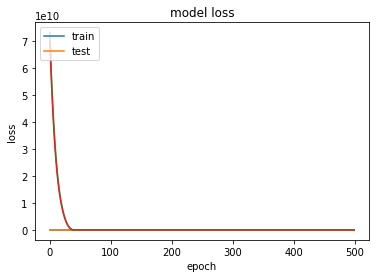

In [137]:
plot_training_history(history, 'gold_nn_clf')

In [138]:
model.load_weights('saved_models/weights.gold.hdf5')
gold_clf_nn = model

Returns  186.55 %
Number of trades:  184
Number of short trades:  27
Number of long trades:  157
Earnings per trade:  101.39
Earnings per short trade:  97.57
Earnings per long trade:  102.04
Precision score:  [0.18518519 0.52941176 0.22292994]


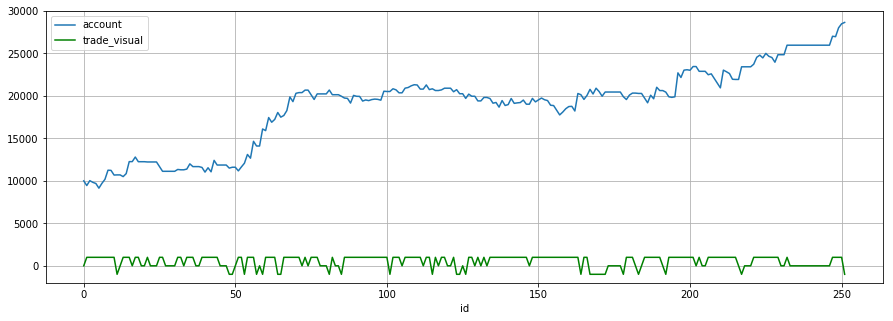

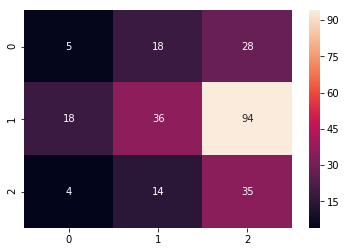

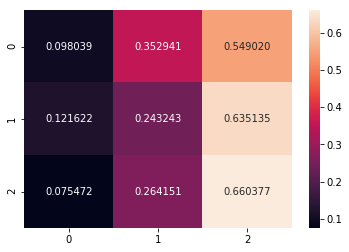

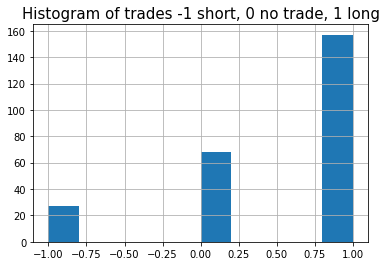

In [139]:
gold_account_nn = get_performance(gold_clf_nn, gold_pca, gold_gains.loc[gold_gains.index > validate_date], gold_validate, gold_label_validate, stop_loss_long=1000, stop_loss_short=800, name='gold_nn_cls', regression=False)

In [141]:
X = pca_transform(corn_train, corn_pca)
y = corn_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(corn_test, corn_pca)
y_test = corn_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_corn)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

model = define_model(input_shape, num_classes)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.corn.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

history = model.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

model.summary()
model.load_weights('saved_models/weights.corn.hdf5')
corn_clf_nn = model

Train on 1928 samples, validate on 483 samples
Epoch 1/500
1928/1928 [==============================] - ETA: 2:27 - loss: 68134785024.0000 - acc: 0.150 - ETA: 10s - loss: 73258362722.4615 - acc: 0.330 - ETA: 4s - loss: 71831887708.1600 - acc: 0.3300 - ETA: 2s - loss: 71274811284.2105 - acc: 0.319 - ETA: 1s - loss: 70573348290.5600 - acc: 0.321 - ETA: 0s - loss: 70331812002.5397 - acc: 0.321 - ETA: 0s - loss: 70236618536.4211 - acc: 0.323 - ETA: 0s - loss: 69813999476.3636 - acc: 0.317 - 2s 1ms/step - loss: 69464509265.7925 - acc: 0.3262 - val_loss: 65182452672.3975 - val_acc: 0.3168

Epoch 00001: val_loss improved from inf to 65182452672.39751, saving model to saved_models/weights.corn.hdf5
Epoch 2/500
1928/1928 [==============================] - ETA: 0s - loss: 65615749120.0000 - acc: 0.250 - ETA: 0s - loss: 64218020181.3333 - acc: 0.308 - ETA: 0s - loss: 65769862010.4348 - acc: 0.330 - ETA: 0s - loss: 65341315754.6667 - acc: 0.325 - ETA: 0s - loss: 65193000069.5652 - acc: 0.313 - ETA

1928/1928 [==============================] - ETA: 0s - loss: 22092967936.0000 - acc: 0.400 - ETA: 0s - loss: 20894221141.3333 - acc: 0.312 - ETA: 0s - loss: 21719473356.8000 - acc: 0.316 - ETA: 0s - loss: 21803674031.1579 - acc: 0.327 - ETA: 0s - loss: 21702784245.7600 - acc: 0.331 - ETA: 0s - loss: 21477229649.2698 - acc: 0.331 - ETA: 0s - loss: 21490733406.3158 - acc: 0.321 - ETA: 0s - loss: 21381323534.3820 - acc: 0.325 - 0s 224us/step - loss: 21293548106.3568 - acc: 0.3268 - val_loss: 19663724021.3996 - val_acc: 0.3106

Epoch 00012: val_loss improved from 22063910122.26915 to 19663724021.39959, saving model to saved_models/weights.corn.hdf5
Epoch 13/500
1928/1928 [==============================] - ETA: 0s - loss: 19390543872.0000 - acc: 0.350 - ETA: 0s - loss: 19666152228.5714 - acc: 0.325 - ETA: 0s - loss: 19940618808.8889 - acc: 0.298 - ETA: 0s - loss: 19862905446.4000 - acc: 0.302 - ETA: 0s - loss: 19523008531.3208 - acc: 0.301 - ETA: 0s - loss: 19361744706.9538 - acc: 0.311 - E

1928/1928 [==============================] - ETA: 0s - loss: 5239353344.0000 - acc: 0.35 - ETA: 0s - loss: 5691671113.1429 - acc: 0.32 - ETA: 0s - loss: 5617635233.1852 - acc: 0.35 - ETA: 0s - loss: 5619796710.4000 - acc: 0.36 - ETA: 0s - loss: 5565531619.0189 - acc: 0.33 - ETA: 0s - loss: 5495984608.9697 - acc: 0.33 - ETA: 0s - loss: 5387748475.1392 - acc: 0.34 - ETA: 0s - loss: 5319454281.1429 - acc: 0.33 - 0s 222us/step - loss: 5288003077.8423 - acc: 0.3397 - val_loss: 4750255229.2174 - val_acc: 0.2836

Epoch 00024: val_loss improved from 5435361635.77640 to 4750255229.21739, saving model to saved_models/weights.corn.hdf5
Epoch 25/500
1928/1928 [==============================] - ETA: 0s - loss: 5616752640.0000 - acc: 0.30 - ETA: 0s - loss: 4697643008.0000 - acc: 0.33 - ETA: 0s - loss: 4698635550.7200 - acc: 0.32 - ETA: 0s - loss: 4757270479.5676 - acc: 0.33 - ETA: 0s - loss: 4677850738.9388 - acc: 0.32 - ETA: 0s - loss: 4648630647.4667 - acc: 0.34 - ETA: 0s - loss: 4632647841.3151 -


Epoch 00036: val_loss improved from 498386849.92133 to 346460172.19876, saving model to saved_models/weights.corn.hdf5
Epoch 37/500
1928/1928 [==============================] - ETA: 0s - loss: 396843968.0000 - acc: 0.400 - ETA: 0s - loss: 358522717.7143 - acc: 0.292 - ETA: 0s - loss: 355101664.5926 - acc: 0.314 - ETA: 0s - loss: 342603425.2000 - acc: 0.325 - ETA: 0s - loss: 332901233.5385 - acc: 0.318 - ETA: 0s - loss: 318081832.3692 - acc: 0.311 - ETA: 0s - loss: 314922261.3333 - acc: 0.314 - ETA: 0s - loss: 309431599.8222 - acc: 0.317 - 0s 220us/step - loss: 304225425.4606 - acc: 0.3195 - val_loss: 224788045.6977 - val_acc: 0.2878

Epoch 00037: val_loss improved from 346460172.19876 to 224788045.69772, saving model to saved_models/weights.corn.hdf5
Epoch 38/500
1928/1928 [==============================] - ETA: 0s - loss: 282282624.0000 - acc: 0.400 - ETA: 0s - loss: 227726484.5714 - acc: 0.317 - ETA: 0s - loss: 220615781.9259 - acc: 0.350 - ETA: 0s - loss: 219287632.4103 - acc: 0.34

1928/1928 [==============================] - ETA: 0s - loss: 110802.4141 - acc: 0.45 - ETA: 0s - loss: 139368.5117 - acc: 0.32 - ETA: 0s - loss: 156526.9795 - acc: 0.34 - ETA: 0s - loss: 160313.6575 - acc: 0.33 - ETA: 0s - loss: 158654.4498 - acc: 0.33 - ETA: 0s - loss: 155959.5504 - acc: 0.33 - ETA: 0s - loss: 157572.2213 - acc: 0.33 - ETA: 0s - loss: 159522.2855 - acc: 0.33 - 0s 223us/step - loss: 158421.8341 - acc: 0.3299 - val_loss: 135246.4262 - val_acc: 0.3395

Epoch 00050: val_loss improved from 137464.10701 to 135246.42624, saving model to saved_models/weights.corn.hdf5
Epoch 51/500
1928/1928 [==============================] - ETA: 0s - loss: 138336.0781 - acc: 0.30 - ETA: 0s - loss: 150650.4035 - acc: 0.31 - ETA: 0s - loss: 153730.6704 - acc: 0.35 - ETA: 0s - loss: 153926.4475 - acc: 0.34 - ETA: 0s - loss: 148509.4850 - acc: 0.34 - ETA: 0s - loss: 153947.4897 - acc: 0.33 - ETA: 0s - loss: 155386.3324 - acc: 0.33 - ETA: 0s - loss: 154210.8384 - acc: 0.33 - 0s 222us/step - loss:


Epoch 00064: val_loss did not improve from 115538.40234
Epoch 65/500
1928/1928 [==============================] - ETA: 0s - loss: 139777.7031 - acc: 0.35 - ETA: 0s - loss: 152514.6719 - acc: 0.31 - ETA: 0s - loss: 152345.1293 - acc: 0.31 - ETA: 0s - loss: 152588.5453 - acc: 0.31 - ETA: 0s - loss: 156512.2736 - acc: 0.32 - ETA: 0s - loss: 154127.4989 - acc: 0.33 - ETA: 0s - loss: 152639.1767 - acc: 0.33 - ETA: 0s - loss: 155075.6001 - acc: 0.34 - 0s 219us/step - loss: 155318.0275 - acc: 0.3397 - val_loss: 165665.9730 - val_acc: 0.3478

Epoch 00065: val_loss did not improve from 115538.40234
Epoch 66/500
1928/1928 [==============================] - ETA: 0s - loss: 161318.5312 - acc: 0.25 - ETA: 0s - loss: 168599.9118 - acc: 0.28 - ETA: 0s - loss: 159245.0413 - acc: 0.31 - ETA: 0s - loss: 156043.6427 - acc: 0.32 - ETA: 0s - loss: 155331.5477 - acc: 0.31 - ETA: 0s - loss: 157663.0179 - acc: 0.31 - ETA: 0s - loss: 157902.6817 - acc: 0.30 - ETA: 0s - loss: 155472.7569 - acc: 0.31 - 0s 229us

1928/1928 [==============================] - ETA: 0s - loss: 176780.9062 - acc: 0.40 - ETA: 0s - loss: 171225.2455 - acc: 0.36 - ETA: 0s - loss: 164096.6388 - acc: 0.35 - ETA: 0s - loss: 162316.1392 - acc: 0.35 - ETA: 0s - loss: 158356.4725 - acc: 0.35 - ETA: 0s - loss: 157586.7508 - acc: 0.36 - ETA: 0s - loss: 156905.6985 - acc: 0.36 - ETA: 0s - loss: 158383.3335 - acc: 0.35 - 0s 221us/step - loss: 156501.0682 - acc: 0.3527 - val_loss: 142583.0080 - val_acc: 0.3230

Epoch 00080: val_loss did not improve from 115538.40234
Epoch 81/500
1928/1928 [==============================] - ETA: 0s - loss: 194780.3906 - acc: 0.60 - ETA: 0s - loss: 157719.3421 - acc: 0.35 - ETA: 0s - loss: 159588.1460 - acc: 0.35 - ETA: 0s - loss: 156680.5228 - acc: 0.33 - ETA: 0s - loss: 155767.5823 - acc: 0.32 - ETA: 0s - loss: 155969.1779 - acc: 0.32 - ETA: 0s - loss: 155053.0848 - acc: 0.32 - ETA: 0s - loss: 155539.1108 - acc: 0.32 - 0s 222us/step - loss: 157371.0522 - acc: 0.3273 - val_loss: 159915.5894 - val_

1928/1928 [==============================] - ETA: 0s - loss: 139736.5625 - acc: 0.50 - ETA: 0s - loss: 178586.4087 - acc: 0.31 - ETA: 0s - loss: 172007.5000 - acc: 0.31 - ETA: 0s - loss: 162855.4164 - acc: 0.33 - ETA: 0s - loss: 160722.9866 - acc: 0.32 - ETA: 0s - loss: 159711.0877 - acc: 0.32 - ETA: 0s - loss: 160143.6804 - acc: 0.32 - ETA: 0s - loss: 155912.0261 - acc: 0.33 - 0s 224us/step - loss: 154327.2754 - acc: 0.3330 - val_loss: 165753.4418 - val_acc: 0.3168

Epoch 00095: val_loss did not improve from 115538.40234
Epoch 96/500
1928/1928 [==============================] - ETA: 0s - loss: 202769.9844 - acc: 0.45 - ETA: 0s - loss: 175985.9327 - acc: 0.31 - ETA: 0s - loss: 170454.5744 - acc: 0.32 - ETA: 0s - loss: 171206.2644 - acc: 0.31 - ETA: 0s - loss: 167392.3931 - acc: 0.32 - ETA: 0s - loss: 165610.2207 - acc: 0.32 - ETA: 0s - loss: 161321.6855 - acc: 0.32 - ETA: 0s - loss: 159844.6652 - acc: 0.32 - 0s 221us/step - loss: 158819.3545 - acc: 0.3200 - val_loss: 161581.7542 - val_

1928/1928 [==============================] - ETA: 0s - loss: 141255.0000 - acc: 0.35 - ETA: 0s - loss: 158555.6044 - acc: 0.35 - ETA: 0s - loss: 158147.5969 - acc: 0.35 - ETA: 0s - loss: 156280.3020 - acc: 0.35 - ETA: 0s - loss: 155378.8431 - acc: 0.34 - ETA: 0s - loss: 158568.5510 - acc: 0.34 - ETA: 0s - loss: 157436.0511 - acc: 0.35 - ETA: 0s - loss: 157016.4218 - acc: 0.34 - 0s 226us/step - loss: 156781.0130 - acc: 0.3428 - val_loss: 142054.8056 - val_acc: 0.2899

Epoch 00110: val_loss did not improve from 115538.40234
Epoch 111/500
1928/1928 [==============================] - ETA: 0s - loss: 131200.6250 - acc: 0.50 - ETA: 0s - loss: 154124.3696 - acc: 0.29 - ETA: 0s - loss: 167008.4877 - acc: 0.33 - ETA: 0s - loss: 157847.5423 - acc: 0.35 - ETA: 0s - loss: 157492.6800 - acc: 0.35 - ETA: 0s - loss: 156986.7344 - acc: 0.35 - ETA: 0s - loss: 154472.8296 - acc: 0.35 - ETA: 0s - loss: 156582.7848 - acc: 0.34 - 0s 224us/step - loss: 156406.5501 - acc: 0.3465 - val_loss: 148736.0749 - val

1928/1928 [==============================] - ETA: 0s - loss: 173040.8594 - acc: 0.50 - ETA: 0s - loss: 160138.2076 - acc: 0.33 - ETA: 0s - loss: 156423.9334 - acc: 0.31 - ETA: 0s - loss: 154729.5084 - acc: 0.32 - ETA: 0s - loss: 158565.4686 - acc: 0.31 - ETA: 0s - loss: 162165.9727 - acc: 0.32 - ETA: 0s - loss: 156818.3438 - acc: 0.32 - ETA: 0s - loss: 156388.1067 - acc: 0.32 - 0s 222us/step - loss: 155932.5518 - acc: 0.3288 - val_loss: 154506.7060 - val_acc: 0.3002

Epoch 00125: val_loss did not improve from 115538.40234
Epoch 126/500
1928/1928 [==============================] - ETA: 0s - loss: 163546.7656 - acc: 0.30 - ETA: 0s - loss: 144802.6016 - acc: 0.32 - ETA: 0s - loss: 155799.5663 - acc: 0.33 - ETA: 0s - loss: 157519.2635 - acc: 0.32 - ETA: 0s - loss: 157417.5702 - acc: 0.32 - ETA: 0s - loss: 158320.6508 - acc: 0.32 - ETA: 0s - loss: 158050.5352 - acc: 0.32 - ETA: 0s - loss: 157361.8669 - acc: 0.32 - 0s 217us/step - loss: 156084.2529 - acc: 0.3237 - val_loss: 149294.6638 - val

1928/1928 [==============================] - ETA: 0s - loss: 197026.9375 - acc: 0.25 - ETA: 0s - loss: 174235.3058 - acc: 0.27 - ETA: 0s - loss: 167505.2584 - acc: 0.31 - ETA: 0s - loss: 165636.5317 - acc: 0.34 - ETA: 0s - loss: 164736.9303 - acc: 0.34 - ETA: 0s - loss: 165499.9461 - acc: 0.33 - ETA: 0s - loss: 165013.5241 - acc: 0.32 - ETA: 0s - loss: 162806.4862 - acc: 0.33 - ETA: 0s - loss: 161462.0026 - acc: 0.33 - ETA: 0s - loss: 159292.9032 - acc: 0.32 - ETA: 0s - loss: 159663.3241 - acc: 0.32 - ETA: 0s - loss: 158731.5936 - acc: 0.33 - ETA: 0s - loss: 160001.6571 - acc: 0.33 - ETA: 0s - loss: 160893.7987 - acc: 0.33 - ETA: 0s - loss: 160099.6335 - acc: 0.33 - 1s 427us/step - loss: 158122.2780 - acc: 0.3361 - val_loss: 138105.1065 - val_acc: 0.3064

Epoch 00138: val_loss did not improve from 115538.40234
Epoch 139/500
1928/1928 [==============================] - ETA: 0s - loss: 127056.5625 - acc: 0.40 - ETA: 0s - loss: 154055.1657 - acc: 0.33 - ETA: 0s - loss: 161532.6542 - acc: 

1928/1928 [==============================] - ETA: 0s - loss: 168414.0938 - acc: 0.50 - ETA: 0s - loss: 168593.6696 - acc: 0.33 - ETA: 0s - loss: 162308.5611 - acc: 0.32 - ETA: 0s - loss: 160885.6128 - acc: 0.32 - ETA: 0s - loss: 161134.8595 - acc: 0.30 - ETA: 0s - loss: 159676.9299 - acc: 0.31 - ETA: 0s - loss: 159750.3216 - acc: 0.31 - ETA: 0s - loss: 159406.2463 - acc: 0.32 - 0s 220us/step - loss: 160022.7882 - acc: 0.3257 - val_loss: 168360.2043 - val_acc: 0.2981

Epoch 00152: val_loss did not improve from 115538.40234
Epoch 153/500
1928/1928 [==============================] - ETA: 1s - loss: 159639.0156 - acc: 0.55 - ETA: 0s - loss: 155428.7254 - acc: 0.34 - ETA: 0s - loss: 157787.4175 - acc: 0.32 - ETA: 0s - loss: 156281.5931 - acc: 0.32 - ETA: 0s - loss: 160231.1725 - acc: 0.32 - ETA: 0s - loss: 161274.7000 - acc: 0.32 - ETA: 0s - loss: 156315.0946 - acc: 0.32 - ETA: 0s - loss: 155035.1679 - acc: 0.33 - 0s 223us/step - loss: 154253.1456 - acc: 0.3299 - val_loss: 152532.4748 - val

1928/1928 [==============================] - ETA: 0s - loss: 194693.2656 - acc: 0.30 - ETA: 0s - loss: 167155.2668 - acc: 0.32 - ETA: 0s - loss: 168278.0587 - acc: 0.31 - ETA: 0s - loss: 157614.5530 - acc: 0.31 - ETA: 0s - loss: 153950.8076 - acc: 0.32 - ETA: 0s - loss: 151894.7893 - acc: 0.33 - ETA: 0s - loss: 151774.5052 - acc: 0.33 - ETA: 0s - loss: 155056.2631 - acc: 0.34 - 0s 221us/step - loss: 154398.2862 - acc: 0.3418 - val_loss: 148691.8822 - val_acc: 0.3375

Epoch 00167: val_loss did not improve from 115538.40234
Epoch 168/500
1928/1928 [==============================] - ETA: 0s - loss: 192777.0938 - acc: 0.30 - ETA: 0s - loss: 157020.1987 - acc: 0.31 - ETA: 0s - loss: 154242.6010 - acc: 0.35 - ETA: 0s - loss: 154939.6820 - acc: 0.35 - ETA: 0s - loss: 160152.4493 - acc: 0.35 - ETA: 0s - loss: 158053.7835 - acc: 0.35 - ETA: 0s - loss: 158579.6261 - acc: 0.33 - ETA: 0s - loss: 158762.8588 - acc: 0.34 - 0s 217us/step - loss: 157870.8132 - acc: 0.3444 - val_loss: 150640.7426 - val

1928/1928 [==============================] - ETA: 0s - loss: 204754.1406 - acc: 0.30 - ETA: 0s - loss: 168295.9922 - acc: 0.37 - ETA: 0s - loss: 156359.9910 - acc: 0.34 - ETA: 0s - loss: 153037.6096 - acc: 0.32 - ETA: 0s - loss: 156780.5771 - acc: 0.33 - ETA: 0s - loss: 158445.8538 - acc: 0.32 - ETA: 0s - loss: 157854.0881 - acc: 0.33 - ETA: 0s - loss: 157797.0445 - acc: 0.33 - 0s 220us/step - loss: 157575.9800 - acc: 0.3377 - val_loss: 153751.1311 - val_acc: 0.3002

Epoch 00182: val_loss did not improve from 115538.40234
Epoch 183/500
1928/1928 [==============================] - ETA: 0s - loss: 176310.2656 - acc: 0.40 - ETA: 0s - loss: 161628.0748 - acc: 0.35 - ETA: 0s - loss: 162032.3429 - acc: 0.35 - ETA: 0s - loss: 160421.4698 - acc: 0.35 - ETA: 0s - loss: 159681.2816 - acc: 0.34 - ETA: 0s - loss: 155461.6406 - acc: 0.33 - ETA: 0s - loss: 156670.0395 - acc: 0.33 - ETA: 0s - loss: 159182.2296 - acc: 0.33 - 0s 224us/step - loss: 156425.0250 - acc: 0.3273 - val_loss: 128847.2257 - val

1928/1928 [==============================] - ETA: 0s - loss: 144474.2344 - acc: 0.20 - ETA: 0s - loss: 169490.0911 - acc: 0.33 - ETA: 0s - loss: 157954.0206 - acc: 0.35 - ETA: 0s - loss: 158120.0212 - acc: 0.35 - ETA: 0s - loss: 159282.8222 - acc: 0.36 - ETA: 0s - loss: 156047.8146 - acc: 0.35 - ETA: 0s - loss: 154717.0954 - acc: 0.34 - ETA: 0s - loss: 156470.8513 - acc: 0.34 - 0s 221us/step - loss: 156422.5713 - acc: 0.3392 - val_loss: 175746.0129 - val_acc: 0.3085

Epoch 00197: val_loss did not improve from 115538.40234
Epoch 198/500
1928/1928 [==============================] - ETA: 0s - loss: 173405.0000 - acc: 0.40 - ETA: 0s - loss: 168648.8522 - acc: 0.31 - ETA: 0s - loss: 154470.9002 - acc: 0.30 - ETA: 0s - loss: 155904.5705 - acc: 0.32 - ETA: 0s - loss: 157210.2701 - acc: 0.32 - ETA: 0s - loss: 159044.3948 - acc: 0.32 - ETA: 0s - loss: 157323.8129 - acc: 0.32 - ETA: 0s - loss: 156398.9131 - acc: 0.32 - 0s 218us/step - loss: 156313.6974 - acc: 0.3247 - val_loss: 171987.5806 - val

1928/1928 [==============================] - ETA: 0s - loss: 122918.0625 - acc: 0.10 - ETA: 0s - loss: 164441.6706 - acc: 0.28 - ETA: 0s - loss: 155228.1969 - acc: 0.28 - ETA: 0s - loss: 156858.9303 - acc: 0.30 - ETA: 0s - loss: 160160.6550 - acc: 0.31 - ETA: 0s - loss: 156958.1245 - acc: 0.32 - ETA: 0s - loss: 153902.9301 - acc: 0.32 - ETA: 0s - loss: 156369.5442 - acc: 0.32 - 0s 224us/step - loss: 157008.0862 - acc: 0.3262 - val_loss: 176869.0760 - val_acc: 0.3230

Epoch 00212: val_loss did not improve from 115538.40234
Epoch 213/500
1928/1928 [==============================] - ETA: 0s - loss: 257845.1719 - acc: 0.30 - ETA: 0s - loss: 169885.1911 - acc: 0.37 - ETA: 0s - loss: 158014.0577 - acc: 0.33 - ETA: 0s - loss: 159197.6905 - acc: 0.33 - ETA: 0s - loss: 158760.8848 - acc: 0.33 - ETA: 0s - loss: 157380.4754 - acc: 0.32 - ETA: 0s - loss: 157951.8371 - acc: 0.33 - ETA: 0s - loss: 157294.3914 - acc: 0.33 - 0s 217us/step - loss: 155902.9278 - acc: 0.3382 - val_loss: 134618.2523 - val

1928/1928 [==============================] - ETA: 0s - loss: 147539.2812 - acc: 0.40 - ETA: 0s - loss: 173406.7320 - acc: 0.33 - ETA: 0s - loss: 170098.3582 - acc: 0.32 - ETA: 0s - loss: 165954.1334 - acc: 0.32 - ETA: 0s - loss: 163804.6779 - acc: 0.32 - ETA: 0s - loss: 161981.7857 - acc: 0.33 - ETA: 0s - loss: 158889.6388 - acc: 0.32 - ETA: 0s - loss: 157571.7763 - acc: 0.32 - 0s 224us/step - loss: 157563.7478 - acc: 0.3247 - val_loss: 153917.8122 - val_acc: 0.3209

Epoch 00227: val_loss did not improve from 115538.40234
Epoch 228/500
1928/1928 [==============================] - ETA: 0s - loss: 151587.1094 - acc: 0.30 - ETA: 0s - loss: 163281.7788 - acc: 0.30 - ETA: 0s - loss: 160489.2046 - acc: 0.33 - ETA: 0s - loss: 150772.4119 - acc: 0.30 - ETA: 0s - loss: 156600.1611 - acc: 0.30 - ETA: 0s - loss: 151993.2728 - acc: 0.32 - ETA: 0s - loss: 159799.9591 - acc: 0.32 - ETA: 0s - loss: 158411.0388 - acc: 0.32 - 0s 221us/step - loss: 155835.7271 - acc: 0.3221 - val_loss: 120153.1702 - val

1928/1928 [==============================] - ETA: 0s - loss: 172122.2812 - acc: 0.30 - ETA: 0s - loss: 150262.4079 - acc: 0.31 - ETA: 0s - loss: 170814.6062 - acc: 0.30 - ETA: 0s - loss: 158655.9609 - acc: 0.31 - ETA: 0s - loss: 157119.6192 - acc: 0.32 - ETA: 0s - loss: 160787.3425 - acc: 0.32 - ETA: 0s - loss: 159444.2279 - acc: 0.32 - ETA: 0s - loss: 156392.6154 - acc: 0.32 - 0s 225us/step - loss: 156960.9931 - acc: 0.3288 - val_loss: 159265.3335 - val_acc: 0.3064

Epoch 00242: val_loss did not improve from 115538.40234
Epoch 243/500
1928/1928 [==============================] - ETA: 0s - loss: 150192.4688 - acc: 0.25 - ETA: 0s - loss: 164192.0000 - acc: 0.33 - ETA: 0s - loss: 162806.7909 - acc: 0.32 - ETA: 0s - loss: 164339.9455 - acc: 0.31 - ETA: 0s - loss: 160890.8012 - acc: 0.32 - ETA: 0s - loss: 155858.4277 - acc: 0.32 - ETA: 0s - loss: 157459.2352 - acc: 0.32 - ETA: 0s - loss: 157033.6545 - acc: 0.32 - 0s 225us/step - loss: 155822.9453 - acc: 0.3283 - val_loss: 152293.9828 - val

1928/1928 [==============================] - ETA: 0s - loss: 209428.7500 - acc: 0.35 - ETA: 0s - loss: 191356.6178 - acc: 0.35 - ETA: 0s - loss: 169826.9730 - acc: 0.33 - ETA: 0s - loss: 156724.1352 - acc: 0.33 - ETA: 0s - loss: 160857.4563 - acc: 0.33 - ETA: 0s - loss: 162862.8636 - acc: 0.33 - ETA: 0s - loss: 157647.0786 - acc: 0.33 - ETA: 0s - loss: 159944.4664 - acc: 0.32 - 0s 218us/step - loss: 159830.7368 - acc: 0.3231 - val_loss: 158216.1483 - val_acc: 0.3416

Epoch 00257: val_loss did not improve from 115538.40234
Epoch 258/500
1928/1928 [==============================] - ETA: 0s - loss: 147876.1875 - acc: 0.20 - ETA: 0s - loss: 148597.1311 - acc: 0.34 - ETA: 0s - loss: 148816.7584 - acc: 0.34 - ETA: 0s - loss: 151300.4574 - acc: 0.33 - ETA: 0s - loss: 156460.3723 - acc: 0.33 - ETA: 0s - loss: 156120.3214 - acc: 0.32 - ETA: 0s - loss: 155802.3643 - acc: 0.31 - ETA: 0s - loss: 155294.2958 - acc: 0.31 - 0s 225us/step - loss: 153792.0901 - acc: 0.3128 - val_loss: 142089.5223 - val

1928/1928 [==============================] - ETA: 0s - loss: 166191.5625 - acc: 0.15 - ETA: 0s - loss: 150124.5156 - acc: 0.33 - ETA: 0s - loss: 167527.0643 - acc: 0.31 - ETA: 0s - loss: 165078.1322 - acc: 0.31 - ETA: 0s - loss: 156287.0309 - acc: 0.31 - ETA: 0s - loss: 160179.5757 - acc: 0.31 - ETA: 0s - loss: 159949.5193 - acc: 0.31 - ETA: 0s - loss: 160123.4199 - acc: 0.31 - 0s 223us/step - loss: 158026.4011 - acc: 0.3185 - val_loss: 130187.9456 - val_acc: 0.2961

Epoch 00272: val_loss did not improve from 115538.40234
Epoch 273/500
1928/1928 [==============================] - ETA: 0s - loss: 149595.7969 - acc: 0.45 - ETA: 0s - loss: 155286.9718 - acc: 0.34 - ETA: 0s - loss: 156771.2539 - acc: 0.35 - ETA: 0s - loss: 159638.1408 - acc: 0.33 - ETA: 0s - loss: 159071.7025 - acc: 0.33 - ETA: 0s - loss: 157987.4207 - acc: 0.33 - ETA: 0s - loss: 153714.4583 - acc: 0.33 - ETA: 0s - loss: 154894.9265 - acc: 0.34 - 0s 221us/step - loss: 154472.7343 - acc: 0.3345 - val_loss: 169365.2945 - val

1928/1928 [==============================] - ETA: 0s - loss: 145545.7344 - acc: 0.30 - ETA: 0s - loss: 155184.4353 - acc: 0.34 - ETA: 0s - loss: 157836.1010 - acc: 0.33 - ETA: 0s - loss: 161234.4432 - acc: 0.34 - ETA: 0s - loss: 158739.7895 - acc: 0.34 - ETA: 0s - loss: 155800.9424 - acc: 0.34 - ETA: 0s - loss: 156145.0894 - acc: 0.34 - ETA: 0s - loss: 155215.5897 - acc: 0.34 - 0s 217us/step - loss: 154167.4617 - acc: 0.3460 - val_loss: 151448.8603 - val_acc: 0.3851

Epoch 00287: val_loss did not improve from 115538.40234
Epoch 288/500
1928/1928 [==============================] - ETA: 0s - loss: 161790.4219 - acc: 0.30 - ETA: 0s - loss: 164684.8795 - acc: 0.37 - ETA: 0s - loss: 163541.5182 - acc: 0.39 - ETA: 0s - loss: 166211.1486 - acc: 0.34 - ETA: 0s - loss: 161190.1591 - acc: 0.34 - ETA: 0s - loss: 157449.0129 - acc: 0.34 - ETA: 0s - loss: 156353.9686 - acc: 0.34 - ETA: 0s - loss: 158142.9142 - acc: 0.34 - 0s 222us/step - loss: 156597.5370 - acc: 0.3387 - val_loss: 150521.4290 - val

1928/1928 [==============================] - ETA: 0s - loss: 171597.3438 - acc: 0.50 - ETA: 0s - loss: 155563.8583 - acc: 0.37 - ETA: 0s - loss: 154950.0337 - acc: 0.35 - ETA: 0s - loss: 153724.6120 - acc: 0.34 - ETA: 0s - loss: 150383.4743 - acc: 0.34 - ETA: 0s - loss: 154305.0403 - acc: 0.35 - ETA: 0s - loss: 153386.0985 - acc: 0.34 - ETA: 0s - loss: 156934.7913 - acc: 0.33 - 0s 219us/step - loss: 156314.2761 - acc: 0.3340 - val_loss: 150473.1455 - val_acc: 0.3540

Epoch 00302: val_loss did not improve from 115538.40234
Epoch 303/500
1928/1928 [==============================] - ETA: 0s - loss: 142789.8594 - acc: 0.35 - ETA: 0s - loss: 148432.3065 - acc: 0.37 - ETA: 0s - loss: 159142.1617 - acc: 0.34 - ETA: 0s - loss: 159154.6825 - acc: 0.33 - ETA: 0s - loss: 156144.6044 - acc: 0.32 - ETA: 0s - loss: 156318.0069 - acc: 0.32 - ETA: 0s - loss: 159207.8797 - acc: 0.32 - ETA: 0s - loss: 158735.4029 - acc: 0.33 - 0s 228us/step - loss: 156815.1879 - acc: 0.3299 - val_loss: 150204.2792 - val

1928/1928 [==============================] - ETA: 0s - loss: 199540.5938 - acc: 0.45 - ETA: 0s - loss: 164810.0481 - acc: 0.34 - ETA: 0s - loss: 156441.0675 - acc: 0.35 - ETA: 0s - loss: 153406.5999 - acc: 0.32 - ETA: 0s - loss: 156928.6441 - acc: 0.32 - ETA: 0s - loss: 156579.8073 - acc: 0.32 - ETA: 0s - loss: 154941.7349 - acc: 0.32 - ETA: 0s - loss: 156320.2428 - acc: 0.33 - 0s 225us/step - loss: 155819.6164 - acc: 0.3314 - val_loss: 153858.8367 - val_acc: 0.3064

Epoch 00317: val_loss did not improve from 115538.40234
Epoch 318/500
1928/1928 [==============================] - ETA: 0s - loss: 167651.3750 - acc: 0.30 - ETA: 0s - loss: 165679.0757 - acc: 0.31 - ETA: 0s - loss: 162675.2323 - acc: 0.36 - ETA: 0s - loss: 158704.9163 - acc: 0.36 - ETA: 0s - loss: 158670.0639 - acc: 0.34 - ETA: 0s - loss: 157989.0422 - acc: 0.34 - ETA: 0s - loss: 158780.0308 - acc: 0.34 - ETA: 0s - loss: 158123.1997 - acc: 0.33 - 0s 222us/step - loss: 157473.0644 - acc: 0.3408 - val_loss: 154191.4860 - val

1928/1928 [==============================] - ETA: 0s - loss: 154081.7500 - acc: 0.20 - ETA: 0s - loss: 156273.4040 - acc: 0.33 - ETA: 0s - loss: 157776.8672 - acc: 0.32 - ETA: 0s - loss: 165743.6978 - acc: 0.32 - ETA: 0s - loss: 160124.4605 - acc: 0.34 - ETA: 0s - loss: 157561.9862 - acc: 0.34 - ETA: 0s - loss: 155320.7386 - acc: 0.34 - ETA: 0s - loss: 155249.6042 - acc: 0.34 - 0s 223us/step - loss: 155414.1132 - acc: 0.3475 - val_loss: 163254.2461 - val_acc: 0.3395

Epoch 00332: val_loss did not improve from 115538.40234
Epoch 333/500
1928/1928 [==============================] - ETA: 0s - loss: 150912.1719 - acc: 0.45 - ETA: 0s - loss: 176645.8717 - acc: 0.36 - ETA: 0s - loss: 173615.7118 - acc: 0.36 - ETA: 0s - loss: 163180.9269 - acc: 0.35 - ETA: 0s - loss: 155954.4044 - acc: 0.35 - ETA: 0s - loss: 151164.9618 - acc: 0.34 - ETA: 0s - loss: 154381.1055 - acc: 0.36 - ETA: 0s - loss: 158107.0562 - acc: 0.35 - 0s 224us/step - loss: 157075.9265 - acc: 0.3558 - val_loss: 163970.6785 - val

1928/1928 [==============================] - ETA: 0s - loss: 177045.3125 - acc: 0.35 - ETA: 0s - loss: 150570.4557 - acc: 0.31 - ETA: 0s - loss: 151042.7409 - acc: 0.34 - ETA: 0s - loss: 158644.0527 - acc: 0.34 - ETA: 0s - loss: 155871.2074 - acc: 0.35 - ETA: 0s - loss: 155932.9461 - acc: 0.35 - ETA: 0s - loss: 153562.7205 - acc: 0.34 - ETA: 0s - loss: 154296.3905 - acc: 0.34 - 0s 231us/step - loss: 153347.5894 - acc: 0.3382 - val_loss: 157600.9272 - val_acc: 0.3478

Epoch 00347: val_loss did not improve from 115538.40234
Epoch 348/500
1928/1928 [==============================] - ETA: 0s - loss: 129759.7891 - acc: 0.45 - ETA: 0s - loss: 181378.5162 - acc: 0.30 - ETA: 0s - loss: 169927.7578 - acc: 0.31 - ETA: 0s - loss: 164438.2884 - acc: 0.31 - ETA: 0s - loss: 161652.9770 - acc: 0.31 - ETA: 0s - loss: 158911.2475 - acc: 0.31 - ETA: 0s - loss: 155463.1363 - acc: 0.32 - ETA: 0s - loss: 158279.6465 - acc: 0.32 - 0s 232us/step - loss: 159838.9934 - acc: 0.3247 - val_loss: 170341.0972 - val

1928/1928 [==============================] - ETA: 0s - loss: 108603.0391 - acc: 0.40 - ETA: 0s - loss: 164137.0776 - acc: 0.36 - ETA: 0s - loss: 158097.3281 - acc: 0.35 - ETA: 0s - loss: 154315.0535 - acc: 0.33 - ETA: 0s - loss: 155855.0834 - acc: 0.34 - ETA: 0s - loss: 158313.5088 - acc: 0.33 - ETA: 0s - loss: 156508.9792 - acc: 0.33 - ETA: 0s - loss: 156269.0901 - acc: 0.33 - 0s 218us/step - loss: 155755.3561 - acc: 0.3356 - val_loss: 164290.9227 - val_acc: 0.3478

Epoch 00362: val_loss did not improve from 115538.40234
Epoch 363/500
1928/1928 [==============================] - ETA: 0s - loss: 153204.2500 - acc: 0.45 - ETA: 0s - loss: 163118.1445 - acc: 0.36 - ETA: 0s - loss: 159425.7347 - acc: 0.37 - ETA: 0s - loss: 166317.7756 - acc: 0.35 - ETA: 0s - loss: 158504.2381 - acc: 0.34 - ETA: 0s - loss: 156020.8075 - acc: 0.33 - ETA: 0s - loss: 157695.1076 - acc: 0.34 - ETA: 0s - loss: 161081.7051 - acc: 0.34 - 0s 219us/step - loss: 161239.0724 - acc: 0.3428 - val_loss: 181829.1413 - val

1928/1928 [==============================] - ETA: 0s - loss: 132143.3750 - acc: 0.35 - ETA: 0s - loss: 144834.8379 - acc: 0.30 - ETA: 0s - loss: 148357.0007 - acc: 0.33 - ETA: 0s - loss: 151044.4423 - acc: 0.32 - ETA: 0s - loss: 149950.6083 - acc: 0.32 - ETA: 0s - loss: 156234.4594 - acc: 0.34 - ETA: 0s - loss: 157792.8230 - acc: 0.34 - ETA: 0s - loss: 156883.4325 - acc: 0.34 - ETA: 0s - loss: 157565.2305 - acc: 0.34 - 0s 248us/step - loss: 157010.1531 - acc: 0.3454 - val_loss: 143808.0626 - val_acc: 0.3623

Epoch 00377: val_loss did not improve from 115538.40234
Epoch 378/500
1928/1928 [==============================] - ETA: 0s - loss: 158908.4844 - acc: 0.40 - ETA: 0s - loss: 182770.4026 - acc: 0.33 - ETA: 0s - loss: 165405.3444 - acc: 0.34 - ETA: 0s - loss: 159055.5709 - acc: 0.35 - ETA: 0s - loss: 158648.0088 - acc: 0.36 - ETA: 0s - loss: 153727.9938 - acc: 0.36 - ETA: 0s - loss: 152882.9308 - acc: 0.36 - ETA: 0s - loss: 156959.3174 - acc: 0.36 - ETA: 0s - loss: 153154.1019 - acc: 

1928/1928 [==============================] - ETA: 0s - loss: 180706.4531 - acc: 0.55 - ETA: 0s - loss: 176632.7188 - acc: 0.34 - ETA: 0s - loss: 164964.9474 - acc: 0.38 - ETA: 0s - loss: 158180.7967 - acc: 0.39 - ETA: 0s - loss: 158748.4369 - acc: 0.38 - ETA: 0s - loss: 156284.0435 - acc: 0.38 - ETA: 0s - loss: 157570.8653 - acc: 0.37 - ETA: 0s - loss: 157175.1604 - acc: 0.36 - 0s 222us/step - loss: 155442.2846 - acc: 0.3631 - val_loss: 139456.8816 - val_acc: 0.3747

Epoch 00391: val_loss did not improve from 115538.40234
Epoch 392/500
1928/1928 [==============================] - ETA: 0s - loss: 148070.5625 - acc: 0.30 - ETA: 0s - loss: 153343.2394 - acc: 0.28 - ETA: 0s - loss: 161631.7653 - acc: 0.31 - ETA: 0s - loss: 159062.7580 - acc: 0.32 - ETA: 0s - loss: 154347.0261 - acc: 0.33 - ETA: 0s - loss: 154869.9689 - acc: 0.33 - ETA: 0s - loss: 156963.5577 - acc: 0.33 - ETA: 0s - loss: 156438.2051 - acc: 0.34 - 0s 224us/step - loss: 155673.9458 - acc: 0.3428 - val_loss: 159654.9496 - val


Epoch 00405: val_loss did not improve from 115538.40234
Epoch 406/500
1928/1928 [==============================] - ETA: 0s - loss: 118383.7734 - acc: 0.25 - ETA: 0s - loss: 172284.5749 - acc: 0.39 - ETA: 0s - loss: 164514.2656 - acc: 0.34 - ETA: 0s - loss: 163039.7556 - acc: 0.33 - ETA: 0s - loss: 163830.8021 - acc: 0.32 - ETA: 0s - loss: 161047.5924 - acc: 0.32 - ETA: 0s - loss: 159213.7347 - acc: 0.32 - ETA: 0s - loss: 157891.6681 - acc: 0.32 - ETA: 0s - loss: 159582.0553 - acc: 0.32 - 0s 236us/step - loss: 159234.2862 - acc: 0.3283 - val_loss: 171963.9638 - val_acc: 0.4037

Epoch 00406: val_loss did not improve from 115538.40234
Epoch 407/500
1928/1928 [==============================] - ETA: 0s - loss: 198434.3438 - acc: 0.35 - ETA: 0s - loss: 186884.4654 - acc: 0.33 - ETA: 0s - loss: 167327.2425 - acc: 0.33 - ETA: 0s - loss: 157963.3982 - acc: 0.36 - ETA: 0s - loss: 160950.4542 - acc: 0.35 - ETA: 0s - loss: 155345.2988 - acc: 0.33 - ETA: 0s - loss: 155722.5061 - acc: 0.34 - ETA: 0


Epoch 00420: val_loss did not improve from 115538.40234
Epoch 421/500
1928/1928 [==============================] - ETA: 0s - loss: 144519.4844 - acc: 0.30 - ETA: 0s - loss: 151638.7148 - acc: 0.33 - ETA: 0s - loss: 169322.3441 - acc: 0.35 - ETA: 0s - loss: 162734.8409 - acc: 0.36 - ETA: 0s - loss: 158218.1985 - acc: 0.37 - ETA: 0s - loss: 155481.6012 - acc: 0.36 - ETA: 0s - loss: 156843.0107 - acc: 0.35 - ETA: 0s - loss: 156712.0948 - acc: 0.35 - 0s 219us/step - loss: 156969.7486 - acc: 0.3532 - val_loss: 165447.2397 - val_acc: 0.3478

Epoch 00421: val_loss did not improve from 115538.40234
Epoch 422/500
1928/1928 [==============================] - ETA: 0s - loss: 135384.5938 - acc: 0.40 - ETA: 0s - loss: 154926.9169 - acc: 0.33 - ETA: 0s - loss: 171184.1469 - acc: 0.33 - ETA: 0s - loss: 165279.8359 - acc: 0.33 - ETA: 0s - loss: 159344.3488 - acc: 0.33 - ETA: 0s - loss: 155886.6142 - acc: 0.33 - ETA: 0s - loss: 157693.2265 - acc: 0.33 - ETA: 0s - loss: 158045.0226 - acc: 0.33 - 0s 224

Epoch 436/500
1928/1928 [==============================] - ETA: 0s - loss: 126226.6016 - acc: 0.25 - ETA: 0s - loss: 163382.4794 - acc: 0.33 - ETA: 0s - loss: 172820.9465 - acc: 0.33 - ETA: 0s - loss: 171193.3982 - acc: 0.32 - ETA: 0s - loss: 162909.9810 - acc: 0.34 - ETA: 0s - loss: 161118.0073 - acc: 0.34 - ETA: 0s - loss: 161152.8270 - acc: 0.35 - ETA: 0s - loss: 161145.9190 - acc: 0.35 - 0s 219us/step - loss: 159530.1767 - acc: 0.3517 - val_loss: 167911.6381 - val_acc: 0.3602

Epoch 00436: val_loss did not improve from 115538.40234
Epoch 437/500
1928/1928 [==============================] - ETA: 0s - loss: 144795.5938 - acc: 0.40 - ETA: 0s - loss: 151450.5619 - acc: 0.32 - ETA: 0s - loss: 154445.4705 - acc: 0.32 - ETA: 0s - loss: 161249.0602 - acc: 0.33 - ETA: 0s - loss: 159860.5147 - acc: 0.33 - ETA: 0s - loss: 155315.1081 - acc: 0.33 - ETA: 0s - loss: 158386.0088 - acc: 0.32 - ETA: 0s - loss: 159211.0774 - acc: 0.33 - 0s 218us/step - loss: 158218.9131 - acc: 0.3366 - val_loss: 139

1928/1928 [==============================] - ETA: 0s - loss: 147072.5781 - acc: 0.35 - ETA: 0s - loss: 158858.0787 - acc: 0.39 - ETA: 0s - loss: 157108.3101 - acc: 0.35 - ETA: 0s - loss: 161828.8033 - acc: 0.35 - ETA: 0s - loss: 155968.7111 - acc: 0.34 - ETA: 0s - loss: 155336.4129 - acc: 0.34 - ETA: 0s - loss: 157060.1604 - acc: 0.33 - ETA: 0s - loss: 157293.0547 - acc: 0.34 - 0s 218us/step - loss: 156585.8573 - acc: 0.3423 - val_loss: 132893.9438 - val_acc: 0.3954

Epoch 00451: val_loss did not improve from 115538.40234
Epoch 452/500
1928/1928 [==============================] - ETA: 0s - loss: 129998.9219 - acc: 0.45 - ETA: 0s - loss: 153268.2801 - acc: 0.37 - ETA: 0s - loss: 161424.7870 - acc: 0.35 - ETA: 0s - loss: 160007.3535 - acc: 0.35 - ETA: 0s - loss: 158282.3558 - acc: 0.35 - ETA: 0s - loss: 159339.1525 - acc: 0.35 - ETA: 0s - loss: 158754.3373 - acc: 0.36 - ETA: 0s - loss: 157078.9164 - acc: 0.35 - 0s 216us/step - loss: 156690.4547 - acc: 0.3594 - val_loss: 162829.7769 - val

1928/1928 [==============================] - ETA: 0s - loss: 132283.7656 - acc: 0.20 - ETA: 0s - loss: 146072.7236 - acc: 0.31 - ETA: 0s - loss: 145371.2831 - acc: 0.32 - ETA: 0s - loss: 150587.6495 - acc: 0.34 - ETA: 0s - loss: 150912.7567 - acc: 0.33 - ETA: 0s - loss: 151650.8848 - acc: 0.34 - ETA: 0s - loss: 147980.3704 - acc: 0.34 - ETA: 0s - loss: 152386.9371 - acc: 0.34 - 0s 219us/step - loss: 154440.7655 - acc: 0.3470 - val_loss: 167320.8697 - val_acc: 0.3520

Epoch 00466: val_loss did not improve from 115538.40234
Epoch 467/500
1928/1928 [==============================] - ETA: 0s - loss: 149338.1719 - acc: 0.25 - ETA: 0s - loss: 162302.7701 - acc: 0.36 - ETA: 0s - loss: 154023.6548 - acc: 0.37 - ETA: 0s - loss: 154116.1916 - acc: 0.36 - ETA: 0s - loss: 157429.2780 - acc: 0.35 - ETA: 0s - loss: 156665.8215 - acc: 0.34 - ETA: 0s - loss: 155631.8069 - acc: 0.34 - ETA: 0s - loss: 156310.9469 - acc: 0.34 - 0s 216us/step - loss: 155183.0108 - acc: 0.3470 - val_loss: 148445.3037 - val

1928/1928 [==============================] - ETA: 0s - loss: 123839.0781 - acc: 0.45 - ETA: 0s - loss: 150744.4280 - acc: 0.33 - ETA: 0s - loss: 150870.2506 - acc: 0.33 - ETA: 0s - loss: 162214.4121 - acc: 0.34 - ETA: 0s - loss: 161576.9278 - acc: 0.34 - ETA: 0s - loss: 157934.0674 - acc: 0.33 - ETA: 0s - loss: 158178.3672 - acc: 0.33 - ETA: 0s - loss: 156739.2019 - acc: 0.33 - 0s 217us/step - loss: 155734.2886 - acc: 0.3371 - val_loss: 137765.5805 - val_acc: 0.3830

Epoch 00481: val_loss did not improve from 115538.40234
Epoch 482/500
1928/1928 [==============================] - ETA: 0s - loss: 181402.5469 - acc: 0.40 - ETA: 0s - loss: 146418.5011 - acc: 0.31 - ETA: 0s - loss: 154486.9318 - acc: 0.32 - ETA: 0s - loss: 151712.3506 - acc: 0.34 - ETA: 0s - loss: 154989.8122 - acc: 0.33 - ETA: 0s - loss: 156134.7148 - acc: 0.34 - ETA: 0s - loss: 154073.4677 - acc: 0.34 - ETA: 0s - loss: 154330.4493 - acc: 0.34 - 0s 219us/step - loss: 155215.1384 - acc: 0.3428 - val_loss: 165744.3836 - val

1928/1928 [==============================] - ETA: 0s - loss: 114922.0547 - acc: 0.30 - ETA: 0s - loss: 148073.9157 - acc: 0.38 - ETA: 0s - loss: 145223.3102 - acc: 0.34 - ETA: 0s - loss: 155398.3238 - acc: 0.35 - ETA: 0s - loss: 162302.4266 - acc: 0.34 - ETA: 0s - loss: 157158.6589 - acc: 0.34 - ETA: 0s - loss: 155467.4727 - acc: 0.35 - ETA: 0s - loss: 155223.2278 - acc: 0.34 - 0s 217us/step - loss: 155160.8131 - acc: 0.3465 - val_loss: 160767.3550 - val_acc: 0.3665

Epoch 00496: val_loss did not improve from 115538.40234
Epoch 497/500
1928/1928 [==============================] - ETA: 0s - loss: 142520.8906 - acc: 0.40 - ETA: 0s - loss: 171124.0926 - acc: 0.40 - ETA: 0s - loss: 163176.0072 - acc: 0.37 - ETA: 0s - loss: 161103.8846 - acc: 0.35 - ETA: 0s - loss: 156497.0077 - acc: 0.35 - ETA: 0s - loss: 158087.2507 - acc: 0.34 - ETA: 0s - loss: 160118.6762 - acc: 0.35 - ETA: 0s - loss: 157123.6624 - acc: 0.35 - 0s 220us/step - loss: 155565.0872 - acc: 0.3511 - val_loss: 149688.0486 - val

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


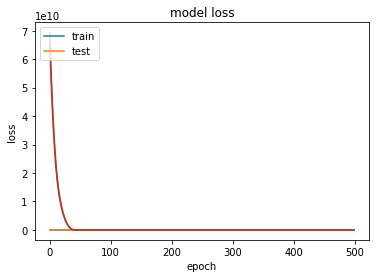

In [142]:
plot_training_history(history, 'corn_nn_clf')

Returns  -66.05 %
Number of trades:  200
Number of short trades:  89
Number of long trades:  111
Earnings per trade:  -33.03
Earnings per short trade:  -33.86
Earnings per long trade:  -32.36
Precision score:  [0.11235955 0.59615385 0.18018018]


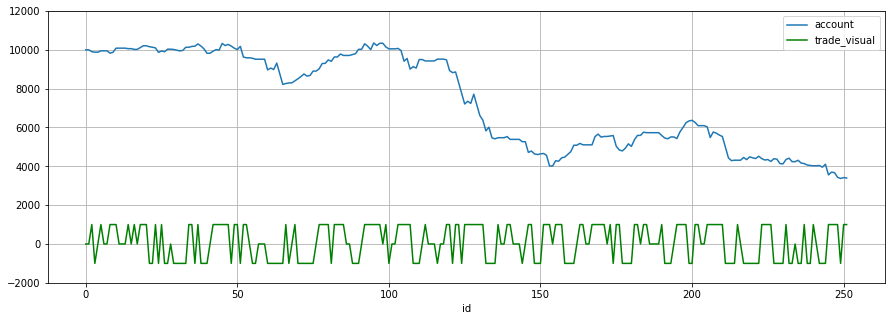

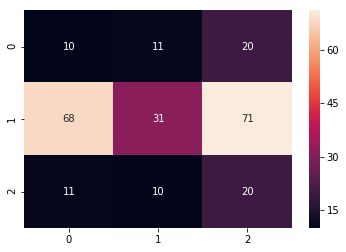

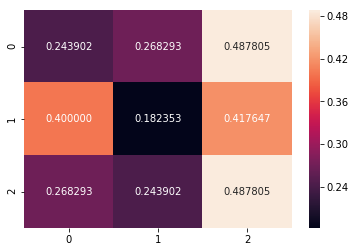

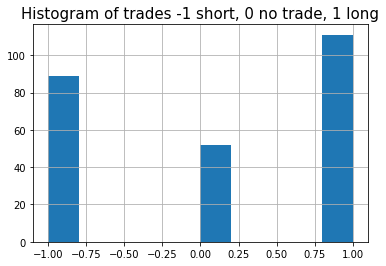

In [143]:
corn_account_nn = get_performance(corn_clf_nn, corn_pca, corn_gains.loc[corn_gains.index > validate_date], corn_validate, corn_label_validate, stop_loss_long=300, stop_loss_short=300, name='corn_nn_cls')

In [144]:
X = pca_transform(coffee_train, coffee_pca)
y = coffee_label_train
# remove outliers
X, y = remove_outliers(X, y, out_coffee)

X_test = pca_transform(coffee_test, coffee_pca)
y_test = coffee_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_coffee)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

model = define_model(input_shape, num_classes)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.coffee.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

history = model.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

model.summary()
model.load_weights('saved_models/weights.coffee.hdf5')
coffee_clf_nn = model

Train on 1923 samples, validate on 481 samples
Epoch 1/500
1923/1923 [==============================] - ETA: 2:41 - loss: 3959279616.0000 - acc: 0.35 - ETA: 12s - loss: 4023070528.0000 - acc: 0.2958 - ETA: 5s - loss: 3870014363.8261 - acc: 0.297 - ETA: 3s - loss: 4145145436.4444 - acc: 0.29 - ETA: 1s - loss: 4145211073.3061 - acc: 0.31 - ETA: 1s - loss: 4326340277.6774 - acc: 0.31 - ETA: 0s - loss: 4221145406.2703 - acc: 0.31 - ETA: 0s - loss: 4330765724.2791 - acc: 0.31 - 2s 1ms/step - loss: 4446923047.5382 - acc: 0.3172 - val_loss: 4330266424.1497 - val_acc: 0.3160

Epoch 00001: val_loss improved from inf to 4330266424.14969, saving model to saved_models/weights.coffee.hdf5
Epoch 2/500
1923/1923 [==============================] - ETA: 0s - loss: 4066137088.0000 - acc: 0.15 - ETA: 0s - loss: 4356194481.2308 - acc: 0.26 - ETA: 0s - loss: 4286309437.4400 - acc: 0.28 - ETA: 0s - loss: 4277345788.6316 - acc: 0.30 - ETA: 0s - loss: 4275650607.6863 - acc: 0.31 - ETA: 0s - loss: 4523230713.9

1923/1923 [==============================] - ETA: 0s - loss: 3560954368.0000 - acc: 0.40 - ETA: 0s - loss: 2806986715.4286 - acc: 0.31 - ETA: 0s - loss: 2901898792.2963 - acc: 0.31 - ETA: 0s - loss: 2853429036.3077 - acc: 0.31 - ETA: 0s - loss: 2955512711.3846 - acc: 0.33 - ETA: 0s - loss: 2906661501.0000 - acc: 0.33 - ETA: 0s - loss: 2919067522.5263 - acc: 0.32 - ETA: 0s - loss: 2890598590.5618 - acc: 0.32 - 0s 223us/step - loss: 2880935705.0276 - acc: 0.3229 - val_loss: 2798524282.6778 - val_acc: 0.3160

Epoch 00013: val_loss improved from 2905392363.24324 to 2798524282.67775, saving model to saved_models/weights.coffee.hdf5
Epoch 14/500
1923/1923 [==============================] - ETA: 0s - loss: 4492392448.0000 - acc: 0.20 - ETA: 0s - loss: 3407240438.8571 - acc: 0.28 - ETA: 0s - loss: 2774402712.8889 - acc: 0.30 - ETA: 0s - loss: 2636997124.0000 - acc: 0.30 - ETA: 0s - loss: 2787899211.4717 - acc: 0.30 - ETA: 0s - loss: 2820694831.0303 - acc: 0.30 - ETA: 0s - loss: 2805371639.4937


Epoch 00025: val_loss improved from 1794033413.18919 to 1716201073.23077, saving model to saved_models/weights.coffee.hdf5
Epoch 26/500
1923/1923 [==============================] - ETA: 0s - loss: 1658007424.0000 - acc: 0.45 - ETA: 0s - loss: 2007282038.8571 - acc: 0.32 - ETA: 0s - loss: 1729531189.7600 - acc: 0.32 - ETA: 0s - loss: 1780218706.5263 - acc: 0.31 - ETA: 0s - loss: 1718230792.7843 - acc: 0.31 - ETA: 0s - loss: 1751129129.0000 - acc: 0.31 - ETA: 0s - loss: 1733917421.4026 - acc: 0.31 - ETA: 0s - loss: 1703826647.9111 - acc: 0.32 - 0s 223us/step - loss: 1696918345.3188 - acc: 0.3193 - val_loss: 1640810016.0665 - val_acc: 0.2869

Epoch 00026: val_loss improved from 1716201073.23077 to 1640810016.06653, saving model to saved_models/weights.coffee.hdf5
Epoch 27/500
1923/1923 [==============================] - ETA: 0s - loss: 1948525952.0000 - acc: 0.30 - ETA: 0s - loss: 1298682205.5385 - acc: 0.32 - ETA: 0s - loss: 1387816085.3333 - acc: 0.31 - ETA: 0s - loss: 1402464762.6667 

1923/1923 [==============================] - ETA: 0s - loss: 947441792.0000 - acc: 0.300 - ETA: 0s - loss: 828038010.2857 - acc: 0.321 - ETA: 0s - loss: 878751871.4074 - acc: 0.331 - ETA: 0s - loss: 886784680.0000 - acc: 0.322 - ETA: 0s - loss: 900013558.7200 - acc: 0.322 - ETA: 0s - loss: 917441226.9206 - acc: 0.321 - ETA: 0s - loss: 917878977.4737 - acc: 0.315 - ETA: 0s - loss: 909267394.3371 - acc: 0.309 - 0s 225us/step - loss: 913483039.4841 - acc: 0.3120 - val_loss: 875465272.9480 - val_acc: 0.2765

Epoch 00038: val_loss improved from 929816995.62578 to 875465272.94802, saving model to saved_models/weights.coffee.hdf5
Epoch 39/500
1923/1923 [==============================] - ETA: 0s - loss: 718387840.0000 - acc: 0.200 - ETA: 0s - loss: 785893765.1429 - acc: 0.307 - ETA: 0s - loss: 814007711.1111 - acc: 0.292 - ETA: 0s - loss: 833580173.0000 - acc: 0.295 - ETA: 0s - loss: 864326427.2308 - acc: 0.293 - ETA: 0s - loss: 826554315.6923 - acc: 0.303 - ETA: 0s - loss: 867325069.8462 - ac


Epoch 00050: val_loss improved from 396819842.42827 to 362693225.61331, saving model to saved_models/weights.coffee.hdf5
Epoch 51/500
1923/1923 [==============================] - ETA: 0s - loss: 542097152.0000 - acc: 0.400 - ETA: 0s - loss: 426240468.5714 - acc: 0.317 - ETA: 0s - loss: 396944092.4444 - acc: 0.307 - ETA: 0s - loss: 361360638.3500 - acc: 0.305 - ETA: 0s - loss: 367077070.7547 - acc: 0.305 - ETA: 0s - loss: 360468669.7273 - acc: 0.301 - ETA: 0s - loss: 345951121.6456 - acc: 0.300 - ETA: 0s - loss: 351562793.9348 - acc: 0.300 - 0s 219us/step - loss: 353724330.4969 - acc: 0.2985 - val_loss: 330593629.4886 - val_acc: 0.2827

Epoch 00051: val_loss improved from 362693225.61331 to 330593629.48857, saving model to saved_models/weights.coffee.hdf5
Epoch 52/500
1923/1923 [==============================] - ETA: 0s - loss: 373449696.0000 - acc: 0.400 - ETA: 0s - loss: 327440294.8571 - acc: 0.271 - ETA: 0s - loss: 299999901.2593 - acc: 0.285 - ETA: 0s - loss: 319424383.3500 - acc: 

1923/1923 [==============================] - ETA: 0s - loss: 114542112.0000 - acc: 0.350 - ETA: 0s - loss: 91943325.7857 - acc: 0.275 - ETA: 0s - loss: 83496838.8519 - acc: 0.27 - ETA: 0s - loss: 77692289.4750 - acc: 0.28 - ETA: 0s - loss: 79696507.5000 - acc: 0.29 - ETA: 0s - loss: 79117287.1553 - acc: 0.29 - ETA: 0s - loss: 75980982.0285 - acc: 0.30 - ETA: 0s - loss: 75912107.8723 - acc: 0.31 - 0s 218us/step - loss: 75368893.0293 - acc: 0.3105 - val_loss: 65115457.6383 - val_acc: 0.2682

Epoch 00063: val_loss improved from 78926057.20790 to 65115457.63825, saving model to saved_models/weights.coffee.hdf5
Epoch 64/500
1923/1923 [==============================] - ETA: 0s - loss: 92141256.0000 - acc: 0.40 - ETA: 0s - loss: 66560032.0000 - acc: 0.32 - ETA: 0s - loss: 63514649.7778 - acc: 0.30 - ETA: 0s - loss: 61141471.2000 - acc: 0.29 - ETA: 0s - loss: 62253081.8491 - acc: 0.28 - ETA: 0s - loss: 63603497.6061 - acc: 0.29 - ETA: 0s - loss: 62394877.0823 - acc: 0.29 - ETA: 0s - loss: 6153

1923/1923 [==============================] - ETA: 0s - loss: 144420.3281 - acc: 0.35 - ETA: 0s - loss: 245644.1295 - acc: 0.33 - ETA: 0s - loss: 221112.8770 - acc: 0.30 - ETA: 0s - loss: 200766.1615 - acc: 0.30 - ETA: 0s - loss: 205524.4937 - acc: 0.29 - ETA: 0s - loss: 202617.8476 - acc: 0.29 - ETA: 0s - loss: 196957.4803 - acc: 0.30 - ETA: 0s - loss: 205195.8561 - acc: 0.29 - 0s 223us/step - loss: 202453.6893 - acc: 0.2980 - val_loss: 115284.6433 - val_acc: 0.2703

Epoch 00076: val_loss improved from 271016.08109 to 115284.64334, saving model to saved_models/weights.coffee.hdf5
Epoch 77/500
1923/1923 [==============================] - ETA: 0s - loss: 182749.7969 - acc: 0.35 - ETA: 0s - loss: 96013.3651 - acc: 0.2643 - ETA: 0s - loss: 94724.9883 - acc: 0.281 - ETA: 0s - loss: 97828.8729 - acc: 0.287 - ETA: 0s - loss: 98119.0113 - acc: 0.296 - ETA: 0s - loss: 94745.4735 - acc: 0.290 - ETA: 0s - loss: 90439.9525 - acc: 0.301 - ETA: 0s - loss: 90049.8892 - acc: 0.304 - 0s 219us/step - lo


Epoch 00090: val_loss did not improve from 48137.72358
Epoch 91/500
1923/1923 [==============================] - ETA: 0s - loss: 25727.4082 - acc: 0.250 - ETA: 0s - loss: 49107.3448 - acc: 0.285 - ETA: 0s - loss: 55142.8647 - acc: 0.282 - ETA: 0s - loss: 54167.5742 - acc: 0.280 - ETA: 0s - loss: 52873.9385 - acc: 0.272 - ETA: 0s - loss: 51583.4000 - acc: 0.282 - ETA: 0s - loss: 51411.5006 - acc: 0.285 - ETA: 0s - loss: 50635.0415 - acc: 0.282 - 0s 220us/step - loss: 52035.5858 - acc: 0.2876 - val_loss: 53157.6569 - val_acc: 0.2620

Epoch 00091: val_loss did not improve from 48137.72358
Epoch 92/500
1923/1923 [==============================] - ETA: 0s - loss: 84469.7734 - acc: 0.400 - ETA: 0s - loss: 61489.1448 - acc: 0.321 - ETA: 0s - loss: 55327.1464 - acc: 0.292 - ETA: 0s - loss: 52985.8047 - acc: 0.301 - ETA: 0s - loss: 53113.3806 - acc: 0.306 - ETA: 0s - loss: 51393.0205 - acc: 0.306 - ETA: 0s - loss: 50142.6123 - acc: 0.293 - ETA: 0s - loss: 50628.8291 - acc: 0.292 - 0s 220us/ste

Epoch 106/500
1923/1923 [==============================] - ETA: 0s - loss: 58271.1406 - acc: 0.250 - ETA: 0s - loss: 50012.2162 - acc: 0.303 - ETA: 0s - loss: 47453.9438 - acc: 0.290 - ETA: 0s - loss: 50838.5267 - acc: 0.285 - ETA: 0s - loss: 51029.9924 - acc: 0.268 - ETA: 0s - loss: 49715.6047 - acc: 0.281 - ETA: 0s - loss: 49396.8849 - acc: 0.285 - ETA: 0s - loss: 50255.1950 - acc: 0.283 - 0s 224us/step - loss: 50403.1240 - acc: 0.2829 - val_loss: 56270.7393 - val_acc: 0.2620

Epoch 00106: val_loss did not improve from 47609.55743
Epoch 107/500
1923/1923 [==============================] - ETA: 0s - loss: 60773.1680 - acc: 0.300 - ETA: 0s - loss: 54092.6949 - acc: 0.267 - ETA: 0s - loss: 55106.3252 - acc: 0.251 - ETA: 0s - loss: 55673.5858 - acc: 0.267 - ETA: 0s - loss: 55153.7833 - acc: 0.267 - ETA: 0s - loss: 53175.6625 - acc: 0.271 - ETA: 0s - loss: 51921.3552 - acc: 0.284 - ETA: 0s - loss: 50399.2651 - acc: 0.287 - 0s 221us/step - loss: 50357.1838 - acc: 0.2850 - val_loss: 56997.3

1923/1923 [==============================] - ETA: 0s - loss: 49093.7227 - acc: 0.450 - ETA: 0s - loss: 54892.1630 - acc: 0.314 - ETA: 0s - loss: 49951.1613 - acc: 0.279 - ETA: 0s - loss: 53758.4625 - acc: 0.278 - ETA: 0s - loss: 51829.4321 - acc: 0.282 - ETA: 0s - loss: 52821.5322 - acc: 0.277 - ETA: 0s - loss: 53116.4020 - acc: 0.282 - ETA: 0s - loss: 50873.5797 - acc: 0.279 - 0s 221us/step - loss: 50389.7218 - acc: 0.2772 - val_loss: 53241.8522 - val_acc: 0.2848

Epoch 00121: val_loss did not improve from 46835.58440
Epoch 122/500
1923/1923 [==============================] - ETA: 0s - loss: 42812.0859 - acc: 0.250 - ETA: 0s - loss: 63129.8111 - acc: 0.278 - ETA: 0s - loss: 59062.6310 - acc: 0.261 - ETA: 0s - loss: 53271.6093 - acc: 0.278 - ETA: 0s - loss: 51855.0200 - acc: 0.284 - ETA: 0s - loss: 51206.9164 - acc: 0.291 - ETA: 0s - loss: 51998.9672 - acc: 0.291 - ETA: 0s - loss: 51392.3773 - acc: 0.285 - 0s 220us/step - loss: 52029.1094 - acc: 0.2886 - val_loss: 57641.3478 - val_acc:

1923/1923 [==============================] - ETA: 0s - loss: 58499.4609 - acc: 0.250 - ETA: 0s - loss: 48622.5857 - acc: 0.307 - ETA: 0s - loss: 50000.7502 - acc: 0.294 - ETA: 0s - loss: 49932.1029 - acc: 0.288 - ETA: 0s - loss: 49304.4387 - acc: 0.279 - ETA: 0s - loss: 49777.6177 - acc: 0.291 - ETA: 0s - loss: 50972.9087 - acc: 0.289 - ETA: 0s - loss: 49430.0776 - acc: 0.286 - 0s 222us/step - loss: 49315.2813 - acc: 0.2845 - val_loss: 57298.7683 - val_acc: 0.2640

Epoch 00136: val_loss did not improve from 46835.58440
Epoch 137/500
1923/1923 [==============================] - ETA: 0s - loss: 46973.3789 - acc: 0.300 - ETA: 0s - loss: 62756.1724 - acc: 0.328 - ETA: 0s - loss: 57181.2419 - acc: 0.311 - ETA: 0s - loss: 56123.9138 - acc: 0.303 - ETA: 0s - loss: 53868.8762 - acc: 0.293 - ETA: 0s - loss: 52931.3148 - acc: 0.294 - ETA: 0s - loss: 52355.0711 - acc: 0.303 - ETA: 0s - loss: 52837.4890 - acc: 0.304 - 0s 220us/step - loss: 52693.8334 - acc: 0.2990 - val_loss: 53495.1282 - val_acc:

1923/1923 [==============================] - ETA: 0s - loss: 50626.4453 - acc: 0.150 - ETA: 0s - loss: 61236.0254 - acc: 0.250 - ETA: 0s - loss: 51167.0858 - acc: 0.277 - ETA: 0s - loss: 54336.6367 - acc: 0.271 - ETA: 0s - loss: 50204.3366 - acc: 0.270 - ETA: 0s - loss: 50029.6108 - acc: 0.268 - ETA: 0s - loss: 50972.2092 - acc: 0.267 - ETA: 0s - loss: 50276.2046 - acc: 0.272 - 0s 220us/step - loss: 50422.7410 - acc: 0.2694 - val_loss: 56018.3063 - val_acc: 0.2620

Epoch 00151: val_loss did not improve from 46835.58440
Epoch 152/500
1923/1923 [==============================] - ETA: 0s - loss: 34918.3086 - acc: 0.300 - ETA: 0s - loss: 53896.4623 - acc: 0.267 - ETA: 0s - loss: 56733.4833 - acc: 0.266 - ETA: 0s - loss: 55710.4409 - acc: 0.272 - ETA: 0s - loss: 53917.2730 - acc: 0.271 - ETA: 0s - loss: 53906.2802 - acc: 0.277 - ETA: 0s - loss: 52769.2386 - acc: 0.285 - ETA: 0s - loss: 52339.6405 - acc: 0.283 - 0s 218us/step - loss: 51854.1892 - acc: 0.2829 - val_loss: 55707.1895 - val_acc:

1923/1923 [==============================] - ETA: 0s - loss: 27558.0410 - acc: 0.350 - ETA: 0s - loss: 54297.3290 - acc: 0.292 - ETA: 0s - loss: 54893.6735 - acc: 0.311 - ETA: 0s - loss: 58407.8796 - acc: 0.300 - ETA: 0s - loss: 58949.2837 - acc: 0.291 - ETA: 0s - loss: 57133.4954 - acc: 0.288 - ETA: 0s - loss: 54837.2341 - acc: 0.281 - ETA: 0s - loss: 53225.6932 - acc: 0.285 - 0s 218us/step - loss: 52729.4237 - acc: 0.2839 - val_loss: 53893.9088 - val_acc: 0.2599

Epoch 00166: val_loss did not improve from 46835.58440
Epoch 167/500
1923/1923 [==============================] - ETA: 0s - loss: 45343.3828 - acc: 0.250 - ETA: 0s - loss: 52455.0875 - acc: 0.321 - ETA: 0s - loss: 51772.7379 - acc: 0.281 - ETA: 0s - loss: 51896.6106 - acc: 0.271 - ETA: 0s - loss: 52147.4748 - acc: 0.268 - ETA: 0s - loss: 51860.9461 - acc: 0.273 - ETA: 0s - loss: 53267.5276 - acc: 0.273 - ETA: 0s - loss: 54031.4616 - acc: 0.270 - 0s 219us/step - loss: 55213.8403 - acc: 0.2715 - val_loss: 49124.2166 - val_acc:

1923/1923 [==============================] - ETA: 0s - loss: 47420.5898 - acc: 0.450 - ETA: 0s - loss: 46920.0562 - acc: 0.325 - ETA: 0s - loss: 51908.0771 - acc: 0.284 - ETA: 0s - loss: 50218.6211 - acc: 0.285 - ETA: 0s - loss: 51953.4086 - acc: 0.280 - ETA: 0s - loss: 52637.7074 - acc: 0.274 - ETA: 0s - loss: 51765.9580 - acc: 0.277 - ETA: 0s - loss: 51671.7027 - acc: 0.279 - 0s 228us/step - loss: 51228.9077 - acc: 0.2777 - val_loss: 52230.9166 - val_acc: 0.2620

Epoch 00181: val_loss did not improve from 46835.58440
Epoch 182/500
1923/1923 [==============================] - ETA: 0s - loss: 53772.6367 - acc: 0.250 - ETA: 0s - loss: 46644.2746 - acc: 0.311 - ETA: 0s - loss: 48072.9351 - acc: 0.280 - ETA: 0s - loss: 50773.3590 - acc: 0.284 - ETA: 0s - loss: 54296.7875 - acc: 0.272 - ETA: 0s - loss: 54853.4967 - acc: 0.275 - ETA: 0s - loss: 54305.3506 - acc: 0.277 - ETA: 0s - loss: 52291.4597 - acc: 0.277 - 0s 222us/step - loss: 52283.5416 - acc: 0.2782 - val_loss: 49768.3532 - val_acc:

Epoch 00195: val_loss did not improve from 46835.58440
Epoch 196/500
1923/1923 [==============================] - ETA: 0s - loss: 25588.2266 - acc: 0.400 - ETA: 0s - loss: 43243.5728 - acc: 0.296 - ETA: 0s - loss: 50013.0586 - acc: 0.294 - ETA: 0s - loss: 50632.8548 - acc: 0.298 - ETA: 0s - loss: 47241.3353 - acc: 0.291 - ETA: 0s - loss: 48939.3311 - acc: 0.281 - ETA: 0s - loss: 50402.7625 - acc: 0.282 - ETA: 0s - loss: 50981.3516 - acc: 0.284 - 0s 221us/step - loss: 51820.4531 - acc: 0.2824 - val_loss: 53639.9713 - val_acc: 0.2703

Epoch 00196: val_loss did not improve from 46835.58440
Epoch 197/500
1923/1923 [==============================] - ETA: 0s - loss: 43527.2930 - acc: 0.150 - ETA: 0s - loss: 54314.5222 - acc: 0.250 - ETA: 0s - loss: 52813.3763 - acc: 0.267 - ETA: 0s - loss: 51405.3276 - acc: 0.264 - ETA: 0s - loss: 49498.0978 - acc: 0.268 - ETA: 0s - loss: 51837.7621 - acc: 0.271 - ETA: 0s - loss: 52297.2942 - acc: 0.278 - ETA: 0s - loss: 51810.6162 - acc: 0.275 - 0s 228us/st

1923/1923 [==============================] - ETA: 0s - loss: 34429.2617 - acc: 0.450 - ETA: 0s - loss: 52158.4002 - acc: 0.323 - ETA: 0s - loss: 48438.3197 - acc: 0.304 - ETA: 0s - loss: 49439.0590 - acc: 0.287 - ETA: 0s - loss: 48271.0044 - acc: 0.285 - ETA: 0s - loss: 48477.7575 - acc: 0.281 - ETA: 0s - loss: 50975.9836 - acc: 0.276 - ETA: 0s - loss: 52076.0430 - acc: 0.276 - 0s 231us/step - loss: 50251.1345 - acc: 0.2761 - val_loss: 50821.4214 - val_acc: 0.2786

Epoch 00210: val_loss did not improve from 39473.89622
Epoch 211/500
1923/1923 [==============================] - ETA: 0s - loss: 62555.7227 - acc: 0.350 - ETA: 0s - loss: 48876.4234 - acc: 0.287 - ETA: 0s - loss: 51779.7877 - acc: 0.292 - ETA: 0s - loss: 51870.0444 - acc: 0.298 - ETA: 0s - loss: 52016.2583 - acc: 0.283 - ETA: 0s - loss: 52079.6838 - acc: 0.287 - ETA: 0s - loss: 50328.8964 - acc: 0.286 - ETA: 0s - loss: 50781.1465 - acc: 0.279 - 0s 224us/step - loss: 51353.4345 - acc: 0.2782 - val_loss: 57266.2909 - val_acc:

Epoch 00224: val_loss did not improve from 39473.89622
Epoch 225/500
1923/1923 [==============================] - ETA: 0s - loss: 63926.9609 - acc: 0.300 - ETA: 0s - loss: 47569.8759 - acc: 0.280 - ETA: 0s - loss: 48617.2241 - acc: 0.298 - ETA: 0s - loss: 49077.5930 - acc: 0.289 - ETA: 0s - loss: 50871.1254 - acc: 0.288 - ETA: 0s - loss: 49833.5409 - acc: 0.289 - ETA: 0s - loss: 49490.8684 - acc: 0.287 - ETA: 0s - loss: 51915.8740 - acc: 0.284 - 0s 220us/step - loss: 52185.5090 - acc: 0.2803 - val_loss: 53963.2000 - val_acc: 0.2682

Epoch 00225: val_loss did not improve from 39473.89622
Epoch 226/500
1923/1923 [==============================] - ETA: 0s - loss: 41292.2422 - acc: 0.200 - ETA: 0s - loss: 46624.1422 - acc: 0.225 - ETA: 0s - loss: 48034.9041 - acc: 0.246 - ETA: 0s - loss: 49517.1818 - acc: 0.276 - ETA: 0s - loss: 47688.3662 - acc: 0.276 - ETA: 0s - loss: 48960.7557 - acc: 0.275 - ETA: 0s - loss: 51283.7696 - acc: 0.277 - ETA: 0s - loss: 50633.4648 - acc: 0.269 - 0s 229us/st

1923/1923 [==============================] - ETA: 0s - loss: 41841.8438 - acc: 0.200 - ETA: 0s - loss: 60664.8018 - acc: 0.332 - ETA: 0s - loss: 61854.5896 - acc: 0.315 - ETA: 0s - loss: 55172.3285 - acc: 0.303 - ETA: 0s - loss: 53058.5100 - acc: 0.305 - ETA: 0s - loss: 51803.6129 - acc: 0.295 - ETA: 0s - loss: 53705.1703 - acc: 0.285 - ETA: 0s - loss: 52178.9599 - acc: 0.280 - 0s 222us/step - loss: 52707.3861 - acc: 0.2803 - val_loss: 56098.1554 - val_acc: 0.2661

Epoch 00240: val_loss did not improve from 39473.89622
Epoch 241/500
1923/1923 [==============================] - ETA: 0s - loss: 32555.1836 - acc: 0.200 - ETA: 0s - loss: 55333.8867 - acc: 0.289 - ETA: 0s - loss: 55970.2880 - acc: 0.270 - ETA: 0s - loss: 57104.9849 - acc: 0.278 - ETA: 0s - loss: 55281.0640 - acc: 0.276 - ETA: 0s - loss: 53951.8915 - acc: 0.280 - ETA: 0s - loss: 52128.6467 - acc: 0.283 - ETA: 0s - loss: 50505.5953 - acc: 0.277 - 0s 223us/step - loss: 49987.2014 - acc: 0.2803 - val_loss: 55665.6675 - val_acc:

1923/1923 [==============================] - ETA: 0s - loss: 48616.5586 - acc: 0.400 - ETA: 0s - loss: 50936.0595 - acc: 0.253 - ETA: 0s - loss: 50645.2196 - acc: 0.266 - ETA: 0s - loss: 51525.7022 - acc: 0.273 - ETA: 0s - loss: 50156.9969 - acc: 0.278 - ETA: 0s - loss: 49523.6010 - acc: 0.290 - ETA: 0s - loss: 50288.9995 - acc: 0.282 - ETA: 0s - loss: 50157.9625 - acc: 0.286 - 0s 220us/step - loss: 49596.2230 - acc: 0.2871 - val_loss: 55871.3946 - val_acc: 0.2599

Epoch 00255: val_loss did not improve from 39473.89622
Epoch 256/500
1923/1923 [==============================] - ETA: 0s - loss: 55322.6094 - acc: 0.200 - ETA: 0s - loss: 49150.1627 - acc: 0.261 - ETA: 0s - loss: 52560.8138 - acc: 0.261 - ETA: 0s - loss: 50590.1085 - acc: 0.262 - ETA: 0s - loss: 52777.0150 - acc: 0.274 - ETA: 0s - loss: 52907.5945 - acc: 0.268 - ETA: 0s - loss: 55194.3942 - acc: 0.280 - ETA: 0s - loss: 54707.5801 - acc: 0.289 - 0s 222us/step - loss: 53923.1485 - acc: 0.2798 - val_loss: 46455.8249 - val_acc:

1923/1923 [==============================] - ETA: 0s - loss: 68235.7344 - acc: 0.250 - ETA: 0s - loss: 52897.4621 - acc: 0.326 - ETA: 0s - loss: 54669.9629 - acc: 0.317 - ETA: 0s - loss: 56192.9479 - acc: 0.305 - ETA: 0s - loss: 56358.1597 - acc: 0.298 - ETA: 0s - loss: 53574.3632 - acc: 0.302 - ETA: 0s - loss: 54091.4517 - acc: 0.298 - ETA: 0s - loss: 52799.8982 - acc: 0.291 - 0s 224us/step - loss: 52960.8383 - acc: 0.2897 - val_loss: 54394.1133 - val_acc: 0.2599

Epoch 00270: val_loss did not improve from 39473.89622
Epoch 271/500
1923/1923 [==============================] - ETA: 0s - loss: 70618.2578 - acc: 0.400 - ETA: 0s - loss: 58405.4202 - acc: 0.310 - ETA: 0s - loss: 56737.8123 - acc: 0.296 - ETA: 0s - loss: 54956.8711 - acc: 0.282 - ETA: 0s - loss: 52852.7941 - acc: 0.285 - ETA: 0s - loss: 52874.1082 - acc: 0.292 - ETA: 0s - loss: 52242.8487 - acc: 0.289 - ETA: 0s - loss: 52285.9060 - acc: 0.291 - 0s 221us/step - loss: 51839.7038 - acc: 0.2897 - val_loss: 53133.1916 - val_acc:

1923/1923 [==============================] - ETA: 0s - loss: 35457.6133 - acc: 0.400 - ETA: 0s - loss: 41192.0234 - acc: 0.250 - ETA: 0s - loss: 45093.9151 - acc: 0.268 - ETA: 0s - loss: 50228.2437 - acc: 0.277 - ETA: 0s - loss: 52041.9186 - acc: 0.281 - ETA: 0s - loss: 52310.0517 - acc: 0.285 - ETA: 0s - loss: 52263.3254 - acc: 0.282 - ETA: 0s - loss: 51883.2705 - acc: 0.284 - 0s 221us/step - loss: 51153.7525 - acc: 0.2865 - val_loss: 50176.9598 - val_acc: 0.2723

Epoch 00285: val_loss did not improve from 39473.89622
Epoch 286/500
1923/1923 [==============================] - ETA: 0s - loss: 51035.0898 - acc: 0.150 - ETA: 0s - loss: 48620.2395 - acc: 0.225 - ETA: 0s - loss: 48938.5994 - acc: 0.275 - ETA: 0s - loss: 51416.7899 - acc: 0.287 - ETA: 0s - loss: 49382.8408 - acc: 0.294 - ETA: 0s - loss: 51203.3140 - acc: 0.290 - ETA: 0s - loss: 53034.9457 - acc: 0.283 - ETA: 0s - loss: 51851.6771 - acc: 0.279 - 0s 219us/step - loss: 51892.9264 - acc: 0.2819 - val_loss: 51656.6106 - val_acc:

1923/1923 [==============================] - ETA: 0s - loss: 74651.0000 - acc: 0.450 - ETA: 0s - loss: 55813.5383 - acc: 0.326 - ETA: 0s - loss: 53098.0209 - acc: 0.328 - ETA: 0s - loss: 55759.6957 - acc: 0.334 - ETA: 0s - loss: 54886.9103 - acc: 0.334 - ETA: 0s - loss: 55331.5532 - acc: 0.322 - ETA: 0s - loss: 53757.3603 - acc: 0.313 - ETA: 0s - loss: 53312.0136 - acc: 0.310 - 0s 224us/step - loss: 53557.4511 - acc: 0.3110 - val_loss: 53073.2254 - val_acc: 0.2931

Epoch 00300: val_loss did not improve from 39473.89622
Epoch 301/500
1923/1923 [==============================] - ETA: 0s - loss: 51370.2227 - acc: 0.450 - ETA: 0s - loss: 48547.1450 - acc: 0.317 - ETA: 0s - loss: 49578.8620 - acc: 0.311 - ETA: 0s - loss: 49683.4988 - acc: 0.306 - ETA: 0s - loss: 49633.2243 - acc: 0.320 - ETA: 0s - loss: 51049.5818 - acc: 0.315 - ETA: 0s - loss: 52272.1529 - acc: 0.322 - ETA: 0s - loss: 53511.3141 - acc: 0.319 - 0s 221us/step - loss: 53145.3119 - acc: 0.3157 - val_loss: 51973.6087 - val_acc:


Epoch 00313: val_loss did not improve from 39473.89622
Epoch 314/500
1923/1923 [==============================] - ETA: 0s - loss: 67287.8438 - acc: 0.450 - ETA: 0s - loss: 53839.5098 - acc: 0.300 - ETA: 0s - loss: 58576.8462 - acc: 0.281 - ETA: 0s - loss: 57428.8659 - acc: 0.281 - ETA: 0s - loss: 55192.0583 - acc: 0.295 - ETA: 0s - loss: 54971.9366 - acc: 0.296 - ETA: 0s - loss: 55633.2190 - acc: 0.285 - ETA: 0s - loss: 54470.9112 - acc: 0.301 - ETA: 0s - loss: 52307.9894 - acc: 0.310 - ETA: 0s - loss: 52635.7722 - acc: 0.310 - ETA: 0s - loss: 51845.6988 - acc: 0.311 - ETA: 0s - loss: 51552.3029 - acc: 0.317 - ETA: 0s - loss: 51432.9212 - acc: 0.317 - ETA: 0s - loss: 51509.4058 - acc: 0.315 - ETA: 0s - loss: 51295.4565 - acc: 0.312 - ETA: 0s - loss: 50981.3630 - acc: 0.308 - 1s 463us/step - loss: 50521.2126 - acc: 0.3084 - val_loss: 55174.6687 - val_acc: 0.2911

Epoch 00314: val_loss did not improve from 39473.89622
Epoch 315/500
1923/1923 [==============================] - ETA: 0s - 


Epoch 00325: val_loss did not improve from 39473.89622
Epoch 326/500
1923/1923 [==============================] - ETA: 0s - loss: 78430.4531 - acc: 0.500 - ETA: 0s - loss: 56572.1731 - acc: 0.295 - ETA: 0s - loss: 55572.2342 - acc: 0.300 - ETA: 0s - loss: 57353.2882 - acc: 0.315 - ETA: 0s - loss: 55978.2382 - acc: 0.316 - ETA: 0s - loss: 55645.5176 - acc: 0.307 - ETA: 0s - loss: 54497.7990 - acc: 0.308 - ETA: 0s - loss: 53550.5493 - acc: 0.307 - ETA: 0s - loss: 52920.1363 - acc: 0.298 - ETA: 0s - loss: 50478.8373 - acc: 0.295 - 1s 277us/step - loss: 50134.1211 - acc: 0.2943 - val_loss: 51520.0822 - val_acc: 0.3264

Epoch 00326: val_loss did not improve from 39473.89622
Epoch 327/500
1923/1923 [==============================] - ETA: 0s - loss: 25226.7227 - acc: 0.200 - ETA: 0s - loss: 53687.8122 - acc: 0.209 - ETA: 0s - loss: 50807.3845 - acc: 0.271 - ETA: 0s - loss: 50766.0764 - acc: 0.273 - ETA: 0s - loss: 48836.1557 - acc: 0.283 - ETA: 0s - loss: 51588.9519 - acc: 0.278 - ETA: 0s - 

1923/1923 [==============================] - ETA: 0s - loss: 74781.7422 - acc: 0.300 - ETA: 0s - loss: 54895.9689 - acc: 0.350 - ETA: 0s - loss: 59831.6142 - acc: 0.350 - ETA: 0s - loss: 58913.9099 - acc: 0.341 - ETA: 0s - loss: 54459.3274 - acc: 0.334 - ETA: 0s - loss: 52700.8656 - acc: 0.335 - ETA: 0s - loss: 53918.2176 - acc: 0.332 - ETA: 0s - loss: 52346.9529 - acc: 0.339 - ETA: 0s - loss: 52097.6866 - acc: 0.337 - ETA: 0s - loss: 51319.5658 - acc: 0.331 - 1s 273us/step - loss: 51540.5922 - acc: 0.3313 - val_loss: 56077.9393 - val_acc: 0.3077

Epoch 00339: val_loss did not improve from 39473.89622
Epoch 340/500
1923/1923 [==============================] - ETA: 0s - loss: 54824.1914 - acc: 0.100 - ETA: 0s - loss: 57042.7744 - acc: 0.275 - ETA: 0s - loss: 56809.4325 - acc: 0.319 - ETA: 0s - loss: 55030.5083 - acc: 0.317 - ETA: 0s - loss: 55685.9051 - acc: 0.315 - ETA: 0s - loss: 54895.7431 - acc: 0.312 - ETA: 0s - loss: 53766.7796 - acc: 0.320 - ETA: 0s - loss: 52779.7532 - acc: 0.31

1923/1923 [==============================] - ETA: 0s - loss: 70632.6719 - acc: 0.250 - ETA: 0s - loss: 56715.8757 - acc: 0.327 - ETA: 0s - loss: 52676.8841 - acc: 0.336 - ETA: 0s - loss: 51359.5934 - acc: 0.327 - ETA: 0s - loss: 49799.1433 - acc: 0.320 - ETA: 0s - loss: 49921.4173 - acc: 0.322 - ETA: 0s - loss: 52160.5539 - acc: 0.319 - ETA: 0s - loss: 52591.3614 - acc: 0.321 - ETA: 0s - loss: 53206.1519 - acc: 0.322 - 0s 256us/step - loss: 52468.7209 - acc: 0.3193 - val_loss: 54849.9423 - val_acc: 0.3368

Epoch 00353: val_loss did not improve from 39473.89622
Epoch 354/500
1923/1923 [==============================] - ETA: 0s - loss: 4068.4734 - acc: 0.35 - ETA: 0s - loss: 51781.4887 - acc: 0.287 - ETA: 0s - loss: 55108.7368 - acc: 0.300 - ETA: 0s - loss: 56889.8750 - acc: 0.295 - ETA: 0s - loss: 52953.6256 - acc: 0.308 - ETA: 0s - loss: 52908.4791 - acc: 0.305 - ETA: 0s - loss: 52778.1699 - acc: 0.315 - ETA: 0s - loss: 51369.0218 - acc: 0.315 - ETA: 0s - loss: 50083.3346 - acc: 0.314 


Epoch 00366: val_loss did not improve from 39473.89622
Epoch 367/500
1923/1923 [==============================] - ETA: 0s - loss: 15689.5752 - acc: 0.200 - ETA: 0s - loss: 53598.9814 - acc: 0.312 - ETA: 0s - loss: 55248.3573 - acc: 0.302 - ETA: 0s - loss: 57743.7950 - acc: 0.308 - ETA: 0s - loss: 53911.9306 - acc: 0.304 - ETA: 0s - loss: 56252.8447 - acc: 0.304 - ETA: 0s - loss: 53917.6937 - acc: 0.310 - ETA: 0s - loss: 53178.0318 - acc: 0.322 - ETA: 0s - loss: 51238.7636 - acc: 0.320 - 0s 244us/step - loss: 50558.6958 - acc: 0.3177 - val_loss: 53549.6239 - val_acc: 0.3555

Epoch 00367: val_loss did not improve from 39473.89622
Epoch 368/500
1923/1923 [==============================] - ETA: 0s - loss: 78695.1250 - acc: 0.150 - ETA: 0s - loss: 62456.5138 - acc: 0.303 - ETA: 0s - loss: 63667.6277 - acc: 0.342 - ETA: 0s - loss: 59695.9751 - acc: 0.331 - ETA: 0s - loss: 59027.9904 - acc: 0.337 - ETA: 0s - loss: 55862.0274 - acc: 0.330 - ETA: 0s - loss: 52601.4323 - acc: 0.328 - ETA: 0s - 

1923/1923 [==============================] - ETA: 0s - loss: 39733.2930 - acc: 0.350 - ETA: 0s - loss: 54447.9799 - acc: 0.300 - ETA: 0s - loss: 46468.7913 - acc: 0.322 - ETA: 0s - loss: 48801.9175 - acc: 0.322 - ETA: 0s - loss: 50645.7068 - acc: 0.331 - ETA: 0s - loss: 49477.9652 - acc: 0.344 - ETA: 0s - loss: 48109.1335 - acc: 0.343 - ETA: 0s - loss: 50440.7492 - acc: 0.341 - 0s 234us/step - loss: 50643.8027 - acc: 0.3370 - val_loss: 50279.0009 - val_acc: 0.3430

Epoch 00381: val_loss did not improve from 39473.89622
Epoch 382/500
1923/1923 [==============================] - ETA: 0s - loss: 22655.0742 - acc: 0.200 - ETA: 0s - loss: 48143.3936 - acc: 0.342 - ETA: 0s - loss: 46460.4014 - acc: 0.314 - ETA: 0s - loss: 48102.4924 - acc: 0.338 - ETA: 0s - loss: 50851.0729 - acc: 0.347 - ETA: 0s - loss: 50268.0221 - acc: 0.358 - ETA: 0s - loss: 50936.0428 - acc: 0.355 - ETA: 0s - loss: 50940.6773 - acc: 0.357 - 0s 225us/step - loss: 52440.2997 - acc: 0.3547 - val_loss: 52459.5761 - val_acc:

1923/1923 [==============================] - ETA: 0s - loss: 45420.8125 - acc: 0.300 - ETA: 0s - loss: 45060.3538 - acc: 0.260 - ETA: 0s - loss: 48565.2471 - acc: 0.300 - ETA: 0s - loss: 50793.5982 - acc: 0.307 - ETA: 0s - loss: 53941.8120 - acc: 0.314 - ETA: 0s - loss: 51909.1652 - acc: 0.323 - ETA: 0s - loss: 50142.0600 - acc: 0.317 - ETA: 0s - loss: 50802.8733 - acc: 0.329 - 0s 221us/step - loss: 51266.5223 - acc: 0.3307 - val_loss: 55008.5430 - val_acc: 0.3181

Epoch 00396: val_loss did not improve from 39473.89622
Epoch 397/500
1923/1923 [==============================] - ETA: 0s - loss: 69427.0156 - acc: 0.400 - ETA: 0s - loss: 53927.1667 - acc: 0.317 - ETA: 0s - loss: 56698.2509 - acc: 0.331 - ETA: 0s - loss: 53935.5570 - acc: 0.335 - ETA: 0s - loss: 51974.5287 - acc: 0.337 - ETA: 0s - loss: 49729.3493 - acc: 0.335 - ETA: 0s - loss: 49233.3809 - acc: 0.343 - ETA: 0s - loss: 50664.6226 - acc: 0.351 - 0s 220us/step - loss: 51461.7256 - acc: 0.3479 - val_loss: 58148.9283 - val_acc:

1923/1923 [==============================] - ETA: 0s - loss: 97523.2422 - acc: 0.300 - ETA: 0s - loss: 55338.9392 - acc: 0.329 - ETA: 0s - loss: 54273.2272 - acc: 0.327 - ETA: 0s - loss: 58218.9432 - acc: 0.352 - ETA: 0s - loss: 58539.9682 - acc: 0.342 - ETA: 0s - loss: 56910.6856 - acc: 0.350 - ETA: 0s - loss: 55781.3456 - acc: 0.349 - ETA: 0s - loss: 52731.0466 - acc: 0.355 - 0s 232us/step - loss: 51141.5943 - acc: 0.3458 - val_loss: 58092.6656 - val_acc: 0.3742

Epoch 00410: val_loss did not improve from 39473.89622
Epoch 411/500
1923/1923 [==============================] - ETA: 0s - loss: 86063.1250 - acc: 0.300 - ETA: 0s - loss: 62523.7034 - acc: 0.346 - ETA: 0s - loss: 54236.8596 - acc: 0.348 - ETA: 0s - loss: 52024.9602 - acc: 0.346 - ETA: 0s - loss: 52649.0706 - acc: 0.346 - ETA: 0s - loss: 51614.0783 - acc: 0.343 - ETA: 0s - loss: 53032.2505 - acc: 0.335 - ETA: 0s - loss: 54552.1529 - acc: 0.332 - 0s 223us/step - loss: 54347.1630 - acc: 0.3354 - val_loss: 50791.9088 - val_acc:

1923/1923 [==============================] - ETA: 0s - loss: 51588.0273 - acc: 0.400 - ETA: 0s - loss: 57310.2398 - acc: 0.250 - ETA: 0s - loss: 51108.2280 - acc: 0.284 - ETA: 0s - loss: 48235.5493 - acc: 0.318 - ETA: 0s - loss: 49175.5728 - acc: 0.332 - ETA: 0s - loss: 50684.1466 - acc: 0.327 - ETA: 0s - loss: 51581.1262 - acc: 0.336 - ETA: 0s - loss: 52251.2087 - acc: 0.342 - 0s 223us/step - loss: 52183.9830 - acc: 0.3411 - val_loss: 52638.4542 - val_acc: 0.3347

Epoch 00425: val_loss did not improve from 39473.89622
Epoch 426/500
1923/1923 [==============================] - ETA: 0s - loss: 16255.6367 - acc: 0.150 - ETA: 0s - loss: 48814.4184 - acc: 0.335 - ETA: 0s - loss: 47856.2851 - acc: 0.311 - ETA: 0s - loss: 48505.0347 - acc: 0.326 - ETA: 0s - loss: 51794.4058 - acc: 0.327 - ETA: 0s - loss: 51682.5447 - acc: 0.323 - ETA: 0s - loss: 50824.9880 - acc: 0.328 - ETA: 0s - loss: 51044.7816 - acc: 0.330 - 0s 219us/step - loss: 51209.4819 - acc: 0.3323 - val_loss: 52525.7446 - val_acc:

1923/1923 [==============================] - ETA: 0s - loss: 34705.4531 - acc: 0.250 - ETA: 0s - loss: 50521.8743 - acc: 0.303 - ETA: 0s - loss: 56972.6064 - acc: 0.336 - ETA: 0s - loss: 57272.0298 - acc: 0.350 - ETA: 0s - loss: 57270.2262 - acc: 0.344 - ETA: 0s - loss: 54440.1675 - acc: 0.346 - ETA: 0s - loss: 52368.3535 - acc: 0.343 - ETA: 0s - loss: 51718.2333 - acc: 0.340 - 0s 222us/step - loss: 51896.2234 - acc: 0.3391 - val_loss: 55632.6917 - val_acc: 0.3576

Epoch 00440: val_loss did not improve from 39473.89622
Epoch 441/500
1923/1923 [==============================] - ETA: 0s - loss: 56467.7656 - acc: 0.350 - ETA: 0s - loss: 52781.7346 - acc: 0.378 - ETA: 0s - loss: 54654.6126 - acc: 0.361 - ETA: 0s - loss: 55367.4104 - acc: 0.366 - ETA: 0s - loss: 54944.7152 - acc: 0.364 - ETA: 0s - loss: 56232.4573 - acc: 0.359 - ETA: 0s - loss: 54157.7229 - acc: 0.354 - ETA: 0s - loss: 54240.8314 - acc: 0.352 - 0s 220us/step - loss: 53010.8097 - acc: 0.3536 - val_loss: 47340.6633 - val_acc:

1923/1923 [==============================] - ETA: 0s - loss: 69346.4766 - acc: 0.300 - ETA: 0s - loss: 56218.8018 - acc: 0.323 - ETA: 0s - loss: 51541.8391 - acc: 0.340 - ETA: 0s - loss: 53785.4391 - acc: 0.341 - ETA: 0s - loss: 54464.0388 - acc: 0.342 - ETA: 0s - loss: 54688.4271 - acc: 0.346 - ETA: 0s - loss: 55476.1307 - acc: 0.347 - ETA: 0s - loss: 54013.0200 - acc: 0.342 - ETA: 0s - loss: 52224.5408 - acc: 0.342 - 0s 244us/step - loss: 52371.9081 - acc: 0.3411 - val_loss: 56149.0306 - val_acc: 0.3909

Epoch 00454: val_loss did not improve from 39473.89622
Epoch 455/500
1923/1923 [==============================] - ETA: 0s - loss: 51494.5156 - acc: 0.300 - ETA: 0s - loss: 54752.0297 - acc: 0.342 - ETA: 0s - loss: 52487.4280 - acc: 0.338 - ETA: 0s - loss: 52772.1870 - acc: 0.337 - ETA: 0s - loss: 51418.3906 - acc: 0.336 - ETA: 0s - loss: 51641.5935 - acc: 0.327 - ETA: 0s - loss: 53466.5549 - acc: 0.328 - ETA: 0s - loss: 53524.2092 - acc: 0.322 - ETA: 0s - loss: 52976.2797 - acc: 0.32

1923/1923 [==============================] - ETA: 0s - loss: 130294.7969 - acc: 0.30 - ETA: 0s - loss: 67075.7563 - acc: 0.3577 - ETA: 0s - loss: 59592.9658 - acc: 0.356 - ETA: 0s - loss: 53764.4273 - acc: 0.340 - ETA: 0s - loss: 51173.5245 - acc: 0.359 - ETA: 0s - loss: 49145.8175 - acc: 0.364 - ETA: 0s - loss: 47830.9805 - acc: 0.369 - ETA: 0s - loss: 47508.9162 - acc: 0.363 - 0s 235us/step - loss: 47555.9738 - acc: 0.3630 - val_loss: 63188.5053 - val_acc: 0.3638

Epoch 00468: val_loss did not improve from 39473.89622
Epoch 469/500
1923/1923 [==============================] - ETA: 0s - loss: 91208.7812 - acc: 0.300 - ETA: 0s - loss: 62327.6308 - acc: 0.275 - ETA: 0s - loss: 63558.2810 - acc: 0.313 - ETA: 0s - loss: 60015.2679 - acc: 0.327 - ETA: 0s - loss: 60268.7264 - acc: 0.344 - ETA: 0s - loss: 58616.9707 - acc: 0.346 - ETA: 0s - loss: 55132.9290 - acc: 0.341 - ETA: 0s - loss: 55482.7272 - acc: 0.338 - 0s 230us/step - loss: 54912.9525 - acc: 0.3354 - val_loss: 50389.5382 - val_acc

1923/1923 [==============================] - ETA: 0s - loss: 44131.6914 - acc: 0.250 - ETA: 0s - loss: 48964.3640 - acc: 0.319 - ETA: 0s - loss: 51083.6446 - acc: 0.348 - ETA: 0s - loss: 51701.4429 - acc: 0.336 - ETA: 0s - loss: 50998.9261 - acc: 0.336 - ETA: 0s - loss: 48246.6670 - acc: 0.330 - ETA: 0s - loss: 47657.9700 - acc: 0.334 - ETA: 0s - loss: 48482.6298 - acc: 0.342 - ETA: 0s - loss: 48822.3275 - acc: 0.342 - 0s 242us/step - loss: 48770.3418 - acc: 0.3422 - val_loss: 63010.1161 - val_acc: 0.3680

Epoch 00482: val_loss did not improve from 39473.89622
Epoch 483/500
1923/1923 [==============================] - ETA: 0s - loss: 54149.1875 - acc: 0.250 - ETA: 0s - loss: 52905.7663 - acc: 0.304 - ETA: 0s - loss: 60580.4451 - acc: 0.321 - ETA: 0s - loss: 59129.6326 - acc: 0.340 - ETA: 0s - loss: 58079.3548 - acc: 0.343 - ETA: 0s - loss: 55185.9459 - acc: 0.344 - ETA: 0s - loss: 54033.6665 - acc: 0.348 - ETA: 0s - loss: 52227.1980 - acc: 0.347 - 0s 235us/step - loss: 52440.6062 - acc

1923/1923 [==============================] - ETA: 0s - loss: 29213.4492 - acc: 0.150 - ETA: 0s - loss: 45938.7366 - acc: 0.323 - ETA: 0s - loss: 48603.5323 - acc: 0.366 - ETA: 0s - loss: 46294.0812 - acc: 0.362 - ETA: 0s - loss: 49503.2670 - acc: 0.344 - ETA: 0s - loss: 49789.7576 - acc: 0.355 - ETA: 0s - loss: 51676.3085 - acc: 0.357 - ETA: 0s - loss: 51455.3100 - acc: 0.360 - 0s 224us/step - loss: 50918.1831 - acc: 0.3604 - val_loss: 48936.2975 - val_acc: 0.3680

Epoch 00497: val_loss did not improve from 39473.89622
Epoch 498/500
1923/1923 [==============================] - ETA: 0s - loss: 74149.8281 - acc: 0.300 - ETA: 0s - loss: 52916.5322 - acc: 0.303 - ETA: 0s - loss: 50606.8049 - acc: 0.314 - ETA: 0s - loss: 52684.0730 - acc: 0.327 - ETA: 0s - loss: 53208.6839 - acc: 0.335 - ETA: 0s - loss: 53095.8507 - acc: 0.338 - ETA: 0s - loss: 51500.5021 - acc: 0.344 - ETA: 0s - loss: 51326.6761 - acc: 0.345 - 0s 221us/step - loss: 50804.1870 - acc: 0.3479 - val_loss: 55705.0588 - val_acc:

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


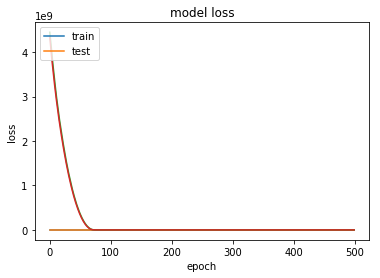

In [145]:
plot_training_history(history, 'coffee_nn_clf')

Returns  0.00 %
Number of trades:  0
Number of short trades:  0
Number of long trades:  0
Earnings per trade:  0.00
Earnings per short trade:  0.00
Earnings per long trade:  0.00


/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision score:  [0.         0.39285714 0.        ]


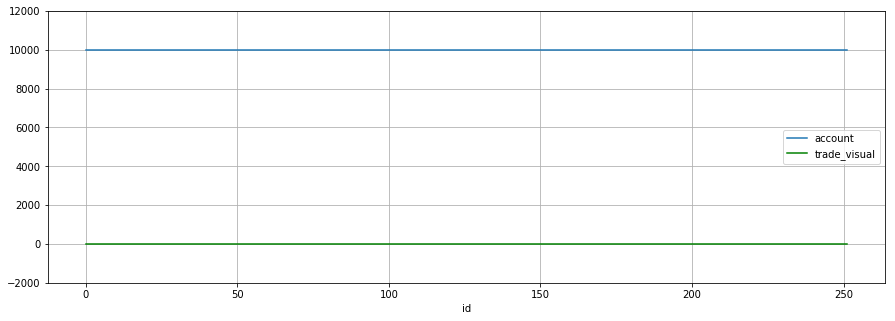

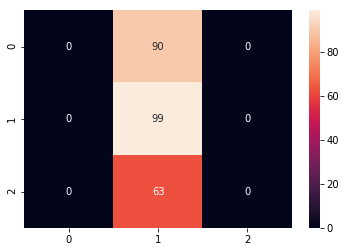

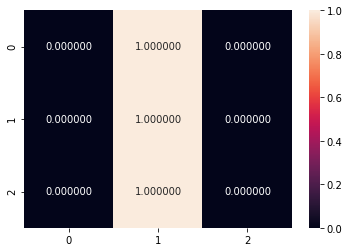

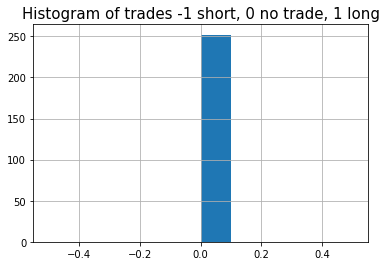

In [146]:
coffee_account_nn = get_performance(coffee_clf_nn, coffee_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_validate, coffee_label_validate, stop_loss_long=300, stop_loss_short=300, name='coffee_nn_cls')

# Neural network regressor

I have decided to use weighted in loss function with weight $0.75$. This is because errors around $0$ does not matter because I want to trigger trades when volatility reaches threshold.

Model performance
---


| commodity | gains % | earnings per trade | number of trades | test/real correlation |
|-----------|---------|--------------------|------------------|-----------------------|
| gold      | 232     | 180                | 129              | 0.14                  |
| corn      | -74     | -65                | 113              | -0.025                |
| coffee   | -12.92  | -56                | 23               | -0.020                |

In [91]:
import keras
import tensorflow as tf
from tensorflow.losses import mean_squared_error
from keras.optimizers import Nadam


def huber_loss(y_true, y_pred):
    return tf.losses.huber_loss(y_true,y_pred)


def weighted_mean_squared_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, weights=0.75)


# loss = huber_loss
loss = weighted_mean_squared_error
# optimizer = 'Adam'
optimizer = Nadam(lr=0.0001)

def regressor_model():
    global input_shape
    global loss
    global optimizer
    
    alpha=.0001
    model = Sequential()
    model.add(Dense(500, input_dim=input_shape, kernel_initializer='normal', activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dropout(0.4))
    model.add(Dense(128, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(64, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(32, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    return model

    # model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
    # model.compile(loss='l1', optimizer='sgd', metrics=['mse'])
    # return model

In [92]:
X = pca_transform(gold_reg_train, gold_reg_pca)
y = gold_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_gold)

X_test = pca_transform(gold_reg_test, gold_reg_pca)
y_test = gold_reg_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_gold)

epochs = 1000
batch_size = 50

checkpointer = ModelCheckpoint(filepath='saved_models/weights.gold_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

estimator = KerasRegressor(build_fn=regressor_model, epochs=epochs, batch_size=batch_size)

In [147]:
history = estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

Train on 1923 samples, validate on 481 samples
Epoch 1/500
1923/1923 [==============================] - ETA: 3:17 - loss: 0.303 - ETA: 18s - loss: 0.359 - ETA: 8s - loss: 0.3368 - ETA: 5s - loss: 0.322 - ETA: 3s - loss: 0.314 - ETA: 2s - loss: 0.304 - ETA: 1s - loss: 0.298 - ETA: 1s - loss: 0.292 - ETA: 0s - loss: 0.288 - ETA: 0s - loss: 0.283 - ETA: 0s - loss: 0.280 - 3s 1ms/step - loss: 0.2779 - val_loss: 0.2243

Epoch 00001: val_loss improved from 39473.89622 to 0.22432, saving model to saved_models/weights.coffee.hdf5
Epoch 2/500
1923/1923 [==============================] - ETA: 0s - loss: 0.274 - ETA: 0s - loss: 0.240 - ETA: 0s - loss: 0.239 - ETA: 0s - loss: 0.242 - ETA: 0s - loss: 0.242 - ETA: 0s - loss: 0.241 - ETA: 0s - loss: 0.239 - ETA: 0s - loss: 0.237 - ETA: 0s - loss: 0.235 - ETA: 0s - loss: 0.235 - ETA: 0s - loss: 0.234 - ETA: 0s - loss: 0.232 - 1s 328us/step - loss: 0.2321 - val_loss: 0.2108

Epoch 00002: val_loss improved from 0.22432 to 0.21076, saving model to saved_

1923/1923 [==============================] - ETA: 0s - loss: 0.171 - ETA: 0s - loss: 0.173 - ETA: 0s - loss: 0.173 - ETA: 0s - loss: 0.173 - ETA: 0s - loss: 0.174 - ETA: 0s - loss: 0.173 - ETA: 0s - loss: 0.173 - ETA: 0s - loss: 0.173 - ETA: 0s - loss: 0.173 - ETA: 0s - loss: 0.173 - ETA: 0s - loss: 0.173 - ETA: 0s - loss: 0.173 - ETA: 0s - loss: 0.173 - ETA: 0s - loss: 0.173 - 1s 412us/step - loss: 0.1734 - val_loss: 0.1716

Epoch 00017: val_loss improved from 0.17239 to 0.17161, saving model to saved_models/weights.coffee.hdf5
Epoch 18/500
1923/1923 [==============================] - ETA: 1s - loss: 0.173 - ETA: 1s - loss: 0.172 - ETA: 0s - loss: 0.173 - ETA: 0s - loss: 0.173 - ETA: 0s - loss: 0.173 - ETA: 0s - loss: 0.173 - ETA: 0s - loss: 0.173 - ETA: 0s - loss: 0.173 - ETA: 0s - loss: 0.173 - ETA: 0s - loss: 0.172 - ETA: 0s - loss: 0.172 - ETA: 0s - loss: 0.172 - ETA: 0s - loss: 0.172 - ETA: 0s - loss: 0.172 - ETA: 0s - loss: 0.172 - ETA: 0s - loss: 0.172 - ETA: 0s - loss: 0.172 -

1923/1923 [==============================] - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - 1s 479us/step - loss: 0.1683 - val_loss: 0.1679

Epoch 00030: val_loss improved from 0.16806 to 0.16792, saving model to saved_models/weights.coffee.hdf5
Epoch 31/500
1923/1923 [==============================] - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 -

1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.167 - ETA: 0s - loss: 0.167 - ETA: 0s - loss: 0.167 - ETA: 0s - loss: 0.167 - ETA: 0s - loss: 0.167 - ETA: 0s - loss: 0.167 - ETA: 0s - loss: 0.167 - ETA: 0s - loss: 0.167 - ETA: 0s - loss: 0.167 - ETA: 0s - loss: 0.167 - ETA: 0s - loss: 0.167 - 1s 377us/step - loss: 0.1670 - val_loss: 0.1669

Epoch 00044: val_loss improved from 0.16691 to 0.16687, saving model to saved_models/weights.coffee.hdf5
Epoch 45/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 317us/step - loss: 0.1669 - val_loss: 0.1668

Epoch 00045: val_loss improved from 0.16687 to 0.16684, saving model to saved_models/weights.coffee.hdf5
Epoch 46/500


Epoch 00059: val_loss improved from 0.16668 to 0.16667, saving model to saved_models/weights.coffee.hdf5
Epoch 60/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 313us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00060: val_loss improved from 0.16667 to 0.16667, saving model to saved_models/weights.coffee.hdf5
Epoch 61/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 310us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00061: val_loss improved from 0.16667 to 0

1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 313us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00076: val_loss improved from 0.16667 to 0.16667, saving model to saved_models/weights.coffee.hdf5
Epoch 77/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 312us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00077: val_loss improved from 0.16667 to 0.16667, saving model to saved_models/weights.coffee.hdf5
Epoch 78/500
1923/1923 [==============================] - ETA

1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 422us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00092: val_loss did not improve from 0.16667
Epoch 93/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 419us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00093: val_loss did not improve from 0.16667
Epoch 94/500
1923/1923 [=

1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 358us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00110: val_loss did not improve from 0.16667
Epoch 111/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 365us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00111: val_loss did not improve from 0.16667
Epoch 112/500
1923/1923 [==============================] - ETA: 0s - los

Epoch 00126: val_loss did not improve from 0.16667
Epoch 127/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 365us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00127: val_loss did not improve from 0.16667
Epoch 128/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 359us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00128: val_loss improved from 0.16667 to 0.16667, sa

1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 319us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00144: val_loss did not improve from 0.16667
Epoch 145/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 341us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00145: val_loss did not improve from 0.16667
Epoch 146/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - los

Epoch 00160: val_loss did not improve from 0.16667
Epoch 161/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 387us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00161: val_loss did not improve from 0.16667
Epoch 162/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 379us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00162: val_loss did not impr

1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 410us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00178: val_loss did not improve from 0.16667
Epoch 179/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 404us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00179: val_loss did not improve from 0.16667
Epoch 180/500
1923/1923 


Epoch 00195: val_loss did not improve from 0.16667
Epoch 196/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 319us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00196: val_loss did not improve from 0.16667
Epoch 197/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 350us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00197: val_loss did not improve from 0.16667
Epoch 198/500
1923/1923 [=============================

1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 336us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00212: val_loss did not improve from 0.16667
Epoch 213/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 320us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00213: val_loss did not improve from 0.16667
Epoch 214/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - los

1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 320us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00228: val_loss did not improve from 0.16667
Epoch 229/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 311us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00229: val_loss did not improve from 0.16667
Epoch 230/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - los

1923/1923 [==============================] - ETA: 1s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 464us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00243: val_loss did not improve from 0.16667
Epoch 244/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 458us/step - loss: 0.1667

Epoch 00257: val_loss did not improve from 0.16667
Epoch 258/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 444us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00258: val_loss did not improve from 0.16667
Epoch 259/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - l

1923/1923 [==============================] - ETA: 1s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 325us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00273: val_loss did not improve from 0.16667
Epoch 274/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 318us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00274: val_loss did not improve from 0.16667
Epoch 275/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - los

1923/1923 [==============================] - ETA: 1s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 418us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00290: val_loss did not improve from 0.16667
Epoch 291/500
1923/1923 [==============================] - ETA: 1s - loss: 0.166 - ETA: 1s - loss: 0.166 - ETA: 1s - loss: 0.166 - ETA: 1s - loss: 0.166 - ETA: 1s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 523us/step - loss: 0.1667

1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 359us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00307: val_loss did not improve from 0.16667
Epoch 308/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 353us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00308: val_loss did not improve from 0.16667
Epoch 309/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - los

Epoch 00324: val_loss did not improve from 0.16667
Epoch 325/500
1923/1923 [==============================] - ETA: 1s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 318us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00325: val_loss did not improve from 0.16667
Epoch 326/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 312us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00326: val_loss did not improve from 0.16667
Epoch 327/500
1923/1923 [==============================] - ETA: 1s - loss: 0.166 - ETA: 0s - loss: 0.16

1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 318us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00343: val_loss did not improve from 0.16667
Epoch 344/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - 1s 327us/step - loss: 0.1667 - val_loss: 0.1667

Epoch 00344: val_loss did not improve from 0.16667
Epoch 345/500
1923/1923 [==============================] - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.166 - ETA: 0s - los

KeyboardInterrupt: 

In [ ]:
plot_training_history(history, 'gold_nn_reg')

In [ ]:
model = regressor_model()
model.load_weights('saved_models/weights.gold_reg.hdf5')
gold_clf_reg_nn = model

In [ ]:
gold_account_nn = get_performance(gold_clf_reg_nn, gold_reg_pca, gold_gains.loc[gold_gains.index > validate_date], gold_reg_validate, gold_reg_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True, target=10, name='gold_nn_reg')

In [ ]:
X = pca_transform(corn_reg_train, corn_reg_pca)
y = corn_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(corn_reg_test, corn_reg_pca)
y_test = corn_reg_label_test
# remove outliers
X_test, y_test = remove_outliers(X_test, y_test, out_corn)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.corn_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

estimator = KerasRegressor(build_fn=regressor_model, epochs=50, batch_size=50)
history = estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

In [ ]:
plot_training_history(history, 'corn_nn_reg')

In [ ]:
model = regressor_model()
model.load_weights('saved_models/weights.corn_reg.hdf5')
corn_clf_reg_nn = model

In [ ]:
corn_account_nn = get_performance(corn_clf_reg_nn, corn_reg_pca, corn_gains.loc[corn_gains.index > validate_date], corn_reg_validate, corn_reg_label_validate, stop_loss_long=300, stop_loss_short=300, regression=True, target=0.1, name='corn_nn_reg')

In [ ]:
X = pca_transform(coffee_reg_train, coffee_reg_pca)
y = coffee_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(coffee_reg_test, coffee_reg_pca)
y_test = coffee_reg_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_corn)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.coffee_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

estimator = KerasRegressor(build_fn=regressor_model, epochs=epochs, batch_size=batch_size)
history = estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

In [ ]:
plot_training_history(history, 'coffee_nn_reg')

In [ ]:
model = regressor_model()
model.load_weights('saved_models/weights.coffee_reg.hdf5')
coffee_clf_reg_nn = model

In [ ]:
coffee_account_nn = get_performance(coffee_clf_reg_nn, coffee_reg_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_reg_validate, coffee_reg_label_validate, stop_loss_long=1000, stop_loss_short=1000, regression=True, target=0.1, name='coffee_nn_reg')

# Conclusions
Only Gold regressor has data that returns positive results. Correlation between actual gold price and predictions is around $0.15$ (depending on training).

Corn and Coffee has rather random correlation with actual performance (also training is not going well).
Last weights update for keras neural network regressor (1000 epochs):

| Gold | Corn | Coffee |
|------|------|--------|
| 512  |   32 | 1      |

I am surprised that I cannot achieve better results with corn. Since corn retained most information by PCA transformation. I expected to have best training results with corn.

# H2O AutoML experiment

In [102]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "10.0.2" 2018-07-17; OpenJDK Runtime Environment (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4); OpenJDK 64-Bit Server VM (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4, mixed mode)
  Starting server from /home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp1tv5gtx_
  JVM stdout: /tmp/tmp1tv5gtx_/h2o_martin_started_from_python.out
  JVM stderr: /tmp/tmp1tv5gtx_/h2o_martin_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Bratislava
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.2
H2O cluster version age:,"21 days, 10 hours and 59 minutes"
H2O cluster name:,H2O_from_python_martin_1l2s8c
H2O cluster total nodes:,1
H2O cluster free memory:,3.898 Gb
H2O cluster total cores:,6
H2O cluster allowed cores:,6
H2O cluster status:,"accepting new members, healthy"


### Classification
Based on the H2O documentation only 2 categories are supported for AutoML. This model was generated for long trades.

In [103]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_long_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_long_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_long_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
validation[y] = validation[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
XGBoost_1_AutoML_20190209_123434,0.5,0.693147,0.5,0.5,0.25
XRT_1_AutoML_20190209_123434,0.489358,0.649831,0.491267,0.47449,0.225141
StackedEnsemble_AllModels_AutoML_20190209_123434,0.482473,0.607319,0.5,0.456395,0.208296
StackedEnsemble_BestOfFamily_AutoML_20190209_123434,0.482473,0.607319,0.5,0.456395,0.208296
GLM_grid_1_AutoML_20190209_123434_model_1,0.479587,0.607513,0.49148,0.456493,0.208386
DRF_1_AutoML_20190209_123434,0.472127,0.650638,0.494616,0.474203,0.224868


xgboost prediction progress: |████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f60b98fe278>]],
      dtype=object)

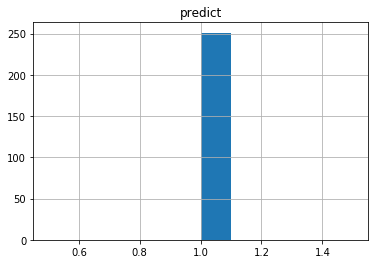

In [104]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

Returns  131.44 %
Number of trades:  251
Number of short trades:  0
Number of long trades:  251
Earnings per trade:  52.36
Earnings per short trade:  0.00
Earnings per long trade:  52.36


/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision score:  [0.         1.         0.21115538]


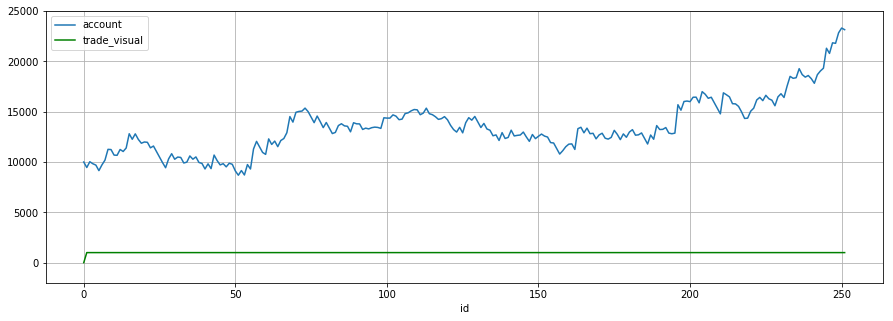

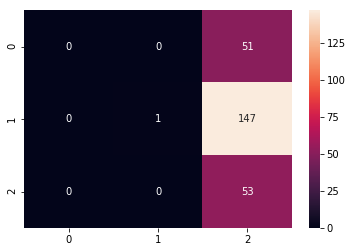

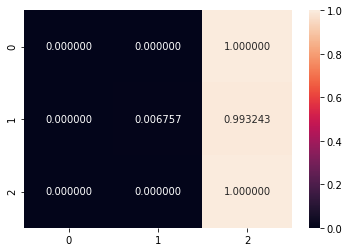

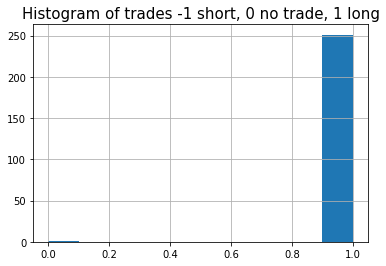

In [105]:
gold_account = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800, name='gold_long_automl_clf')

### H2O AutoML gold regressor

In [106]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_reg_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_reg_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_reg_test.csv", header=1)

# Identify predictors and response
print(train.head())
x = train.columns
y = "label"
x.remove(y)

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=40, max_runtime_secs=60, seed=1234, stopping_metric='deviance')
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
-331248,-27640.9,567537,65888,59525.3,252952,55627.9,-128754,107664,-216797,-88334.8,-158876,-132532,109755,-46152.6,-48243.4,102096,-26623.6,30557,96471.9,128856,-45498.6,7400.27,-52095.7,-102416,11413.4,193359,43174.8,2397.14,102818,51492,86161.9,36587.2,-431.163,-59398.9,-16408.3,-31970.8,7392.44,-41167.5,-38087.9,-79022.2,39880,74855.5,59099.8,-57810.6,4571.96,6865.5,69375.7,-24542.1,-2964.83,38010.9,50722.6,-49494,84525.8,-50325.3,1617.01,9757.53,40051,13361,28889.2,64254.2,-927.344,-13659.5,-973.585,57239.3,-14635.2,51039.1,-37447.1,71646.4,12300.9,7308.94,2995.98,66098,-25603.1,118375,-14342.2,23159.5,-106860,-30568.6,66324.5,-28319.3,-19414.8,74039.7,20878.1,-57363.5,-37656.5,15939.3,19836.3,52715.5,35991,40769.2,-14441.3,69806.5,36537.7,-44491.1,-57462,39878.1,25845.4,-8552.88,-6417.83,5903.48,-26696.2,6223.8,25249.4,16073.9,-3946.47,14822.4,-45238.9,-22718.6,-5387.21,63061.7,-21204.8,46718.1,-10246.8,-17679.4,82309.2,10278.2,33819.8,14791.7,-10318.9,38208.1,36031.4,-22415.4,-22948.7,9237.39,-46271.5,-16025.7,-32045.3,11528.7,-14694,-52873.6,65658.5,78371.1,-3786.76,15688.5,-13926,-47534.8,39424.6,-27202.7,-29934.4,-18343.1,20998.2,9208.38,-16001.3,43712.7,-4050.55,-25511,16382.3,-60760.7,3977.03,-19944.2,64013.7,-39727.3,-37917,-13036.8,52607.2,48494.9,38249.9,-88103.1,-40157.5,-36073.4,9875.56,42455.1,42717.8,-17228.2,-902.95,-28762.9,-41110.7,18957.3,-28820.2,15033.3,-17562.3,-8803.51,23882.9,37622.3,-16041.9,26617.1,15831.3,-1452.96,-24442.8,-13424.9,-17986.4,-54551.6,100337,-12982.5,-20857.6,-49309.7,-29425.2,9438.39,-31290.8,20001,74281.2,38789.7,34382.4,-2799.05,-39896.4,32486.2,74129.7,-38974.9,33943.5
-325632,-21861.3,570463,61896.1,12385.8,263138,67919.9,-122209,98093.1,-221691,-106287,-152934,-113510,123914,-42969.4,-38251.7,83308.7,-40120.2,40592,115483,118716,-59971.5,15404.1,-53785.8,-114764,16018.2,177401,-17123,17396.5,124792,34830.4,80182.2,61158.6,-37570.1,-29884.3,-1243.13,-41191.5,25931.6,198.042,-70567.6,2435.07,24739,104129,15369.9,-67739.2,-63275.3,41865.1,42055.7,458.742,-15286.7,3486.52,45515.7,-82916.5,55935.8,-75649.4,-26103.3,2369.58,42338.8,8161.88,64239.1,56469.8,14761.5,-45009.8,17551.6,24207.2,21459,97579.9,16854,104355,-10585.3,-15991.3,-10664.7,79435.3,1332.76,94045.8,-13272.3,40374.8,-26720.8,-46435.1,69752,-29560.7,-20420.7,15062.6,-49836.2,-69314.5,-75523.9,30552.3,30807.6,78707.6,20325.7,73373.8,-9184.14,23539.3,49531.5,-8248.75,-20231,7103.48,21536.8,-42549,12079.5,-10135.3,-38184.1,21524,40226.9,13054.8,38784.9,-46167.2,-17813.3,-19602,-25986.1,7817.18,-32128.9,-23314.1,-50007.2,-49561.8,26797.7,24791.3,78396.3,19204.7,21994.7,-62312.4,-39373.4,38829.6,10357.8,-792.608,163.776,17432.4,-69134,-45877.9,-39993.2,-11836,24834.9,29452.1,55929.8,39657.4,43875.6,31612.3,76769.7,14581.8,15596.5,36543.6,-14573.6,-387.628,23286.4,-29384.7,-7514.05,-19781.8,20652.3,2781.08,-13415.9,23300.7,46168.7,-48293.3,37659.9,68456.3,35566.7,-16892.2,-7713.68,7171.18,-13490.9,21885.4,29476.2,-18953.5,-19306.2,52039.9,-14114.8,-110200,-44815.4,-31763.5,15814.1,-13441.6,23622.1,30740.1,5327.42,45627.3,16424.6,34625.1,-8653.75,-18554,63492.4,28164.3,5081.91,1326.42,-41837,-30386,3184.34,-34923.6,-38657.6,-41088.3,-20688.8,-18062.2,5762.19,-46274.8,-456.058,-35580.8,-13500,-2665.41,15078.1,-39647.8,4789.56
-322972,-16385.8,56900


AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
XGBoost_1_AutoML_20190209_123557,1.68348e+06,1297.49,1.68348e+06,895.096,nan
GLM_grid_1_AutoML_20190209_123557_model_1,1.68431e+06,1297.81,1.68431e+06,895.899,nan
StackedEnsemble_AllModels_AutoML_20190209_123557,1.68533e+06,1298.2,1.68533e+06,896.418,nan
StackedEnsemble_BestOfFamily_AutoML_20190209_123557,1.68533e+06,1298.2,1.68533e+06,896.418,nan
XRT_1_AutoML_20190209_123557,1.86535e+06,1365.78,1.86535e+06,955.052,nan
DRF_1_AutoML_20190209_123557,1.91745e+06,1384.72,1.91745e+06,975.795,nan


xgboost prediction progress: |████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f60b96088d0>]],
      dtype=object)

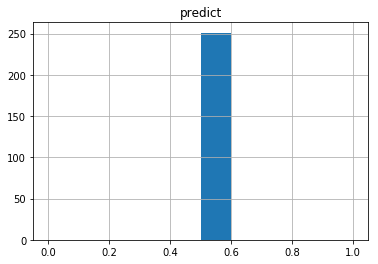

In [107]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

In [108]:
b

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.

In [109]:
def trade(x, treshold):
    ans = 0
    if abs(x) > treshold:
        if x > 0:
            ans = 1
        else:
            ans = -1
    return 0



preds = list(map(lambda x: trade(x, 200), b))

In [110]:
print(preds)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Returns  0.00 %
Number of trades:  251
Number of short trades:  0
Number of long trades:  0
Earnings per trade:  0.00
Earnings per short trade:  0.00
Earnings per long trade:  0.00


ValueError: Classification metrics can't handle a mix of binary and continuous targets

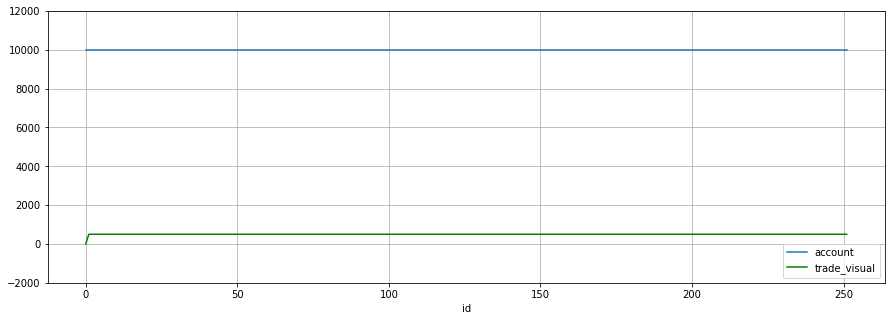

In [111]:
gold_account_reg = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True,  name='gold_automl_reg')

### H2O short trade

In [112]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_short_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_short_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_short_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
DRF_1_AutoML_20190209_125433,0.514799,0.644456,0.49188,0.470246,0.221131
XRT_1_AutoML_20190209_125433,0.512713,0.644007,0.490532,0.470221,0.221108
XGBoost_1_AutoML_20190209_125433,0.5,0.693147,0.5,0.5,0.25
GLM_grid_1_AutoML_20190209_125433_model_1,0.493468,0.604427,0.49927,0.454912,0.206945
StackedEnsemble_BestOfFamily_AutoML_20190209_125433,0.479506,0.604492,0.5,0.454945,0.206975
StackedEnsemble_AllModels_AutoML_20190209_125433,0.479506,0.604492,0.5,0.454945,0.206975


drf prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f60b9628588>]],
      dtype=object)

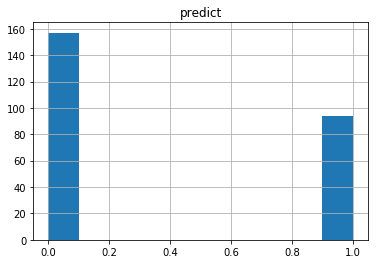

In [113]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = list(map(lambda x: -1 if x > 0 else 0, a.predict.values))
a.hist()

Returns  66.48 %
Number of trades:  94
Number of short trades:  94
Number of long trades:  0
Earnings per trade:  70.72
Earnings per short trade:  70.72
Earnings per long trade:  0.00
Precision score:  [0.21276596 0.59493671 0.        ]


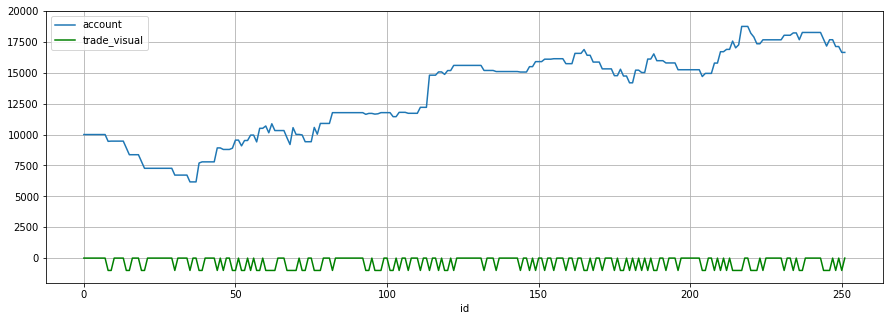

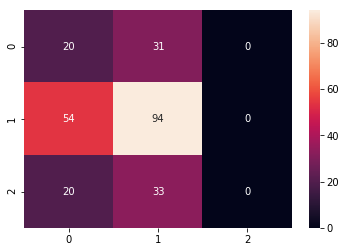

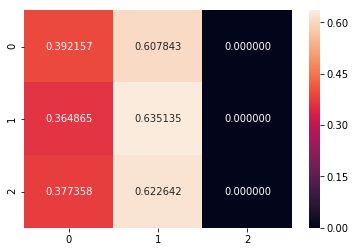

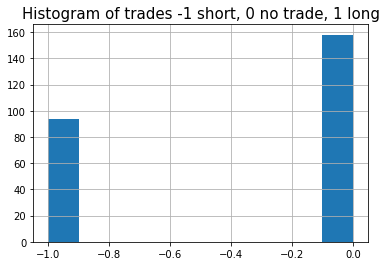

In [114]:
gold_account = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800,  name='gold_automl_short_clf')

In [115]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/corn_pca_short_train.csv", header=1)
validation = h2o.import_file("data/corn_pca_short_validation.csv", header=1)
test = h2o.import_file("data/corn_pca_short_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
DRF_1_AutoML_20190209_125550,0.528342,0.660491,0.5,0.464089,0.215378
GLM_grid_1_AutoML_20190209_125550_model_1,0.518063,0.60057,0.490497,0.452982,0.205193
XRT_1_AutoML_20190209_125550,0.514973,0.633006,0.499272,0.4651,0.216318
XGBoost_1_AutoML_20190209_125550,0.5,0.693147,0.5,0.5,0.25
StackedEnsemble_AllModels_AutoML_20190209_125550,0.471911,0.601609,0.5,0.453431,0.2056
StackedEnsemble_BestOfFamily_AutoML_20190209_125550,0.471911,0.601609,0.5,0.453431,0.2056


drf prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f60b84a07b8>]],
      dtype=object)

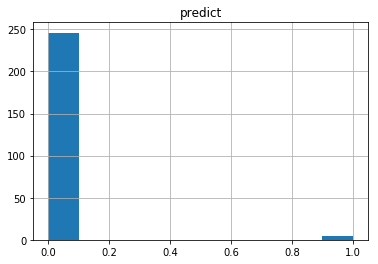

In [116]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.map(lambda x: -1 if x > 0 else 0).values
a.hist()

Returns  3.72 %
Number of trades:  5
Number of short trades:  5
Number of long trades:  0
Earnings per trade:  74.50
Earnings per short trade:  74.50
Earnings per long trade:  0.00
Precision score:  [0.2        0.67206478 0.        ]


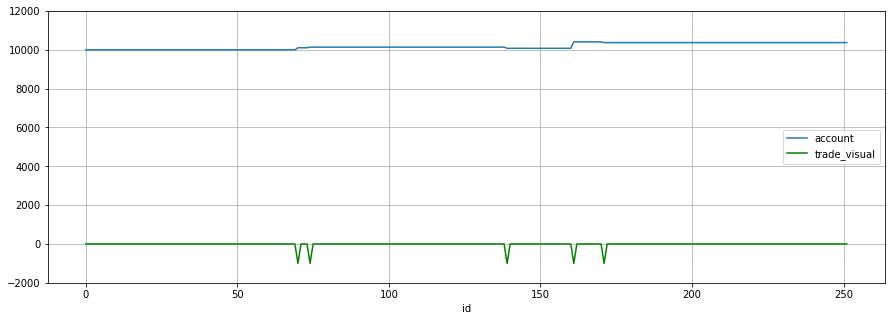

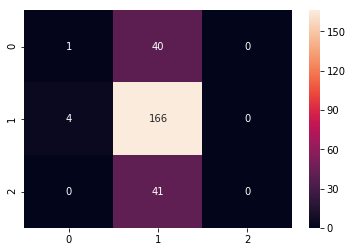

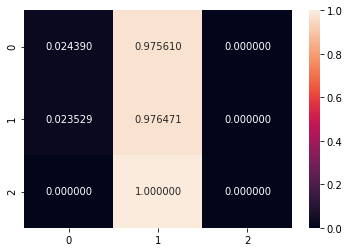

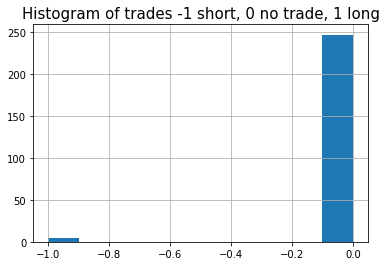

In [117]:
corn_account = get_account(b, corn_gains.loc[corn_gains.index > validate_date], corn_label_validate, stop_loss_long=300, stop_loss_short=300, name='corn_automl_short_clf')

In [118]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/corn_pca_long_train.csv", header=1)
validation = h2o.import_file("data/corn_pca_long_validation.csv", header=1)
test = h2o.import_file("data/corn_pca_long_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
XRT_1_AutoML_20190209_125709,0.506634,0.648925,0.498509,0.473999,0.224675
GLM_grid_1_AutoML_20190209_125709_model_1,0.503377,0.61554,0.498445,0.460647,0.212196
XGBoost_1_AutoML_20190209_125709,0.5,0.693147,0.5,0.5,0.25
DRF_1_AutoML_20190209_125709,0.494978,0.669528,0.495359,0.476381,0.226939
StackedEnsemble_BestOfFamily_AutoML_20190209_125709,0.472857,0.615789,0.495399,0.460761,0.212301
StackedEnsemble_AllModels_AutoML_20190209_125709,0.472857,0.615789,0.495399,0.460761,0.212301


drf prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f60b8232128>]],
      dtype=object)

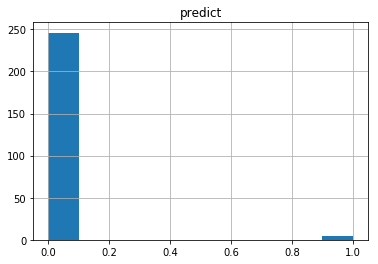

In [119]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

In [120]:
corn_account = get_account(b, corn_gains.loc[corn_gains.index > validate_date], corn_label_validate, stop_loss_long=300, stop_loss_short=300, , name='corn_automl_long_clf')

SyntaxError: invalid syntax (<ipython-input-120-194d17f90305>, line 1)

In [ ]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/coffee_pca_long_train.csv", header=1)
validation = h2o.import_file("data/coffee_pca_long_validation.csv", header=1)
test = h2o.import_file("data/coffee_pca_long_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

In [ ]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

coffee_account = get_account(b, coffee_gains.loc[coffee_gains.index > validate_date], coffee_label_validate, stop_loss_long=800, stop_loss_short=800, , name='coffee_automl_short_clf')

In [ ]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/coffee_pca_short_train.csv", header=1)
validation = h2o.import_file("data/coffee_pca_long_validation.csv", header=1)
test = h2o.import_file("data/coffee_pca_short_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

In [ ]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.map(lambda x: -1 if x == 1 else 0).values
a.hist()

coffee_account = get_account(b, coffee_gains.loc[coffee_gains.index > validate_date], coffee_label_validate, stop_loss_long=800, stop_loss_short=800, , name='coffee_automl_short_clf')

# H2O AutoML conclusion

AutoML regression results were very disappointing since all the predictions for gold were around -26 (which is mean value of training data). Classifiers seems to work better. I think you could get some information but overall I think it is necessary to get insight into the data.

In [ ]:
# mean reversal
# Compute the z-scores for each day using the historical data up to that day
def mean_reversal_account(df, df_gains, trade_days=1):
    account = 10000
    direction = gold['mean_direction'].values[0]
    dct = {}
    dct['account'] = [account]
    trade = 0
    for d, v in zip(df['mean_direction'].values, gold_gains.values):
        if d >= 0 and direction <= 0:
            account -= v[0]
            trade += 1
            if trade_days == trade:
                direction = d
                trade = 0
        elif d <= 0 and direction >= 0:
            direction = d
            account += v[0]
            trade += 1
            if trade_days == trade:
                direction = d
                trade = 0
        dct['account'].append(account)
        if account <= 0:
            break
    return pd.DataFrame.from_dict(dct)

def mean_calculation(df, big_range, small_range):
    big_mean = 'mean_' + str(big_range)
    small_mean = 'mean_' + str(small_range)
    df[big_mean] = df.rolling(str(big_range) + 'd')['Settle'].apply(np.mean, raw=False)
    df[small_mean] = df.rolling(str(small_range) + 'd')['Settle'].apply(np.mean, raw=False)
    df['mean_direction'] =  df[small_mean] - df[big_mean]
    return df

# Comparison of performances

Below we will look at the comparison of the best trading strategy for each commodity versus mean reversal strategy and Nasdaq.

In [ ]:
gold = mean_calculation(gold, 20, 10)
gold[['Settle', 'mean_20', 'mean_10']].loc[gold.index > validate_date].plot(figsize=(10,5), grid=True)
savefig('figures/gold_mean_reversal.eps')

In [ ]:
nasdaq_amount = 10000/nasdaq.loc[(nasdaq.index >= '2018-01-02') & (nasdaq.index < '2018-01-03')].Settle.values[0]

nasdaq = nasdaq.loc[(nasdaq.index <= '2018-12-30')]

In [ ]:
nasdaq.loc[(nasdaq.index >= '2018-01-02') & (nasdaq.index < '2018-01-03')].Settle.values[0]

In [ ]:
nasdaq_amount

In [ ]:
gold_mean = mean_reversal_account(gold.loc[gold.index > validate_date], gold_gains.loc[gold_gains.index > validate_date], trade_days=5)
gold_mean['base'] = gold_mean.account.apply(lambda x: 10000)
gold_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
gold_mean['Nasdaq'] = gold_mean['Nasdaq']*nasdaq_amount

# gold_account_nn = get_performance(gold_clf_reg_nn
ax = pd.concat([gold_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
               gold_account_nn.rename(columns={'account': 'Model Shorts'})[['Model Shorts']],
               ], axis=1).plot(figsize=(10,5), grid=True)

title = ax.set_title('Gold performance comparison', size=15)
savefig('figures/gold_benchmark_performance.eps')

In [ ]:
gold_mean.head()

In [ ]:
corn = mean_calculation(corn, 20, 10)
corn[['Settle', 'mean_10', 'mean_20']].loc[corn.index > validate_date].plot(figsize=(10,5), grid=True)

In [ ]:
corn_mean = mean_reversal_account(corn.loc[corn.index > validate_date], corn_gains.loc[corn_gains.index > validate_date], trade_days=3)
corn_mean['base'] = corn_mean.account.apply(lambda x: 10000)
corn_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
corn_mean['Nasdaq'] = corn_mean['Nasdaq']*nasdaq_amount

ax = pd.concat([corn_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
               corn_account_lgb.rename(columns={'account': 'Corn LightGBM'})[['Corn LightGBM']]], 
               axis=1).plot(figsize=(10,5), grid=True)

title = ax.set_title('Corn performance comparison', size=15)
savefig('figures/corn_benchmark_performance.eps')

In [ ]:
coffee = mean_calculation(coffee, 20, 10)
coffee[['Settle', 'mean_20', 'mean_10']].loc[coffee.index > validate_date].plot(figsize=(10,5), grid=True)

In [ ]:
coffee_mean = mean_reversal_account(coffee.loc[coffee.index > validate_date], 
                                    coffee_gains.loc[coffee_gains.index > validate_date], 
                                    trade_days=5)
coffee_mean['base'] = coffee_mean.account.apply(lambda x: 10000)
coffee_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
coffee_mean['Nasdaq'] = coffee_mean['Nasdaq']*nasdaq_amount

ax = pd.concat([coffee_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
                coffee_account_lgb.rename(columns={'account': 'Coffee LightGBM'})[['Coffee LightGBM']],
               ], axis=1).plot(figsize=(10,5), grid=True)
title = ax.set_title('Coffee performance comparison', size=15)
savefig('figures/coffee_benchmark_performance.eps')

# Conclusion

Trading is a difficult ML problem. Out of three compared commodities gold, corn and coffee we were able to predict performance with gold. Other commodities behaved randomly with approximately 0 correlation to the actual volatility.

In the beginning of project, I was thinking of a classifier (short, no trade, long) because it is closer to the usage of model. I tested regressor as well. Regressor works better because there is more information. I tried different loss function when training regressor. I decided to use weighted MSE. This could be further modified for better function omitting errors below threshold.

Gold trading is the most capital intensive with very big stop losses (1000 long, 800 short). This can be problem for trading with $10 000\$$ account.

In case of corn and coffee the data was almost impossible to classify. I suspect more data transformation is needed to get better results.